# Step 1: The measurement function

In [ ]:
import numpy as np
from qiskit.execute_function import execute

from qiskit import BasicAer
backend = BasicAer.get_backend('qasm_simulator')
from qiskit import QuantumCircuit
import qiskit

# qc = QuantumCircuit(7)
# qc.h(0)
# # qc.h(1)

# qc.draw()

def Measurement(operator, quantum_circuit, shots, backend):
    """
    operator: the Pauli matrix we want to measure for the Quantum Nature Gradient Descent with writing in this from (pauli_matrix+is_position). For exammple: (Z1Z2) or (X3)
    quantum_circuit: the circuit for measurement 
    shots: the number of shots that we want to executee
    !!!COMMENT: In my way of measurement, I reverse the qiskit-way of reprent a arbitrary state for more easily handle in my code, if I don't my code would be meesy and changing alot, and more I want measure the same as the we repsent them like XZZ to be X o Z o Z not be reversed like the qiskit does hmmmmmmmmmmmm
    """


    number_of_qubits = quantum_circuit.num_qubits

    cr = qiskit.ClassicalRegister(number_of_qubits)

    
    if len(operator) > (number_of_qubits):
        raise Exception("The position of Pauli matrix exceeds the number of qubits")

    quantum_circuit_to_measurement = QuantumCircuit(number_of_qubits)


    expectation_value = 0

    for i in range(len(operator)):
        if operator[i] == 'X':
            quantum_circuit_to_measurement.ry(-np.pi/2, i)
        if operator[i] == 'Y':
            quantum_circuit_to_measurement.rx(np.pi/2, i)

    new_quantum_circuit_to_measurement = quantum_circuit.compose(quantum_circuit_to_measurement)

    # new_quantum_circuit_to_measurement.add_register(cr)

    # if operator.count('I') == number_of_qubits:
    #     return 1
    # else:
    #     for i in range(len(operator)):
    #         if operator[i] != 'I':
    #             new_quantum_circuit_to_measurement.measure(i,i)
                

    new_quantum_circuit_to_measurement.measure_all()


    job = execute(new_quantum_circuit_to_measurement, backend, shots=shots)

    result = job.result()

    counts = result.get_counts()

    # Reversed the way qiskit represnts state
    counts_change =  {(key)[::-1] : value for key, value in counts.items()}

    

    # for i in range(len(counts)):
    #     if list(counts.keys())[i].count('1') % 2 == 0:
    #         expectation_value += counts[list(counts.keys())[i]]
    #     if list(counts.keys())[i].count('1') % 2 != 0:
    #         expectation_value -= counts[list(counts.keys())[i]]

    position_of_I_gate = np.where(np.array(list(operator)) == 'I')[0]
    # expectation_value = 0

    for i in range(len(counts_change)):
        extra_minus = 1
        for j in range(len(position_of_I_gate)):
            if list(counts_change.keys())[i][position_of_I_gate[j]] == '1':
                extra_minus *= -1
    
    # print(f'{list(counts.keys())[i]} ooo  {extra_minus}')

        if list(counts_change.keys())[i].count('1') % 2 == 0:
            expectation_value += counts_change[list(counts_change.keys())[i]]*extra_minus
            # print(f'{list(counts.keys())[i]} ++ {counts[list(counts.keys())[i]]*extra_minus}')
        if list(counts_change.keys())[i].count('1') % 2 != 0:
            expectation_value -= counts_change[list(counts_change.keys())[i]]*extra_minus
            # print(f'{list(counts.keys())[i]} -- {counts[list(counts.keys())[i]]*extra_minus}')

    expectation_value = expectation_value/shots

    return expectation_value, counts_change, new_quantum_circuit_to_measurement

In [83]:
import numpy as np

a = 'ZII'

# a = np.array(list(a))
print(np.where(a== 'I')[0])

[]


In [63]:
a[-3]

'I'

In [84]:
counts = {'111': 535, '100': 465, '011':300, '010':200}

In [85]:
list(counts.keys())[0].count('1')

3

In [86]:
position_of_I_gate = np.where(np.array(list(a)) == 'I')[0]
expectation_value = 0

for i in range(len(counts)):
    extra_minus = 1
    for j in range(len(position_of_I_gate)):
        if list(counts.keys())[i][position_of_I_gate[j]-len(np.array(list(a)))] == '1':
            extra_minus *= -1
    
    print(f'{list(counts.keys())[i]} ooo  {extra_minus}')

    if list(counts.keys())[i].count('1') % 2 == 0:
        expectation_value += counts[list(counts.keys())[i]]*extra_minus
        print(f'{list(counts.keys())[i]} ++ {counts[list(counts.keys())[i]]*extra_minus}')
    if list(counts.keys())[i].count('1') % 2 != 0:
        expectation_value -= counts[list(counts.keys())[i]]*extra_minus
        print(f'{list(counts.keys())[i]} -- {counts[list(counts.keys())[i]]*extra_minus}')

111 ooo  1
111 -- 535
100 ooo  1
100 -- 465
011 ooo  1
011 ++ 300
010 ooo  -1
010 -- -200


In [87]:
expectation_value

-500

In [115]:
qc = QuantumCircuit(3)

qc.x(0)
qc.x(1)
# qc.cx(0,1)
# qc.ry(np.pi,1)
# qc.x(2)

shots = 20000

from qiskit import Aer
backend = Aer.get_backend('qasm_simulator')

# new_qc = QuantumCircuit(2)

a =  Measurement('ZZI', qc, shots, backend)
# b = Measurement('YI', qc, shots, backend)
# c = Measurement('IY', qc, shots, backend)

# d = a[0] - b[0]**2

print(a[0])
print(a[1])

1.0
{'110': 20000}


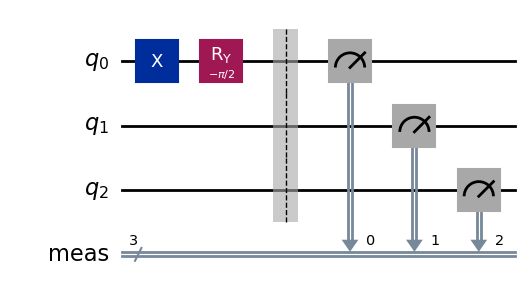

In [81]:
a[2].draw('mpl', style='iqx')

In [40]:
a[2].draw('mpl', style = 'iqx')

KeyboardInterrupt: 

# Step 2: The ansatz

In [151]:
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit

def Customize_EfficientSU2(number_qubits, number_of_subcircuit):
    """
    number_qubits: The amounts of qubits in out system
    number_of_subcircuit: The amounts of subcuirt for parameterized our system
    su2gate: is the gate we want to parameterized with
    insert_barriers: add barriers in our circuit for nice looking
    The function will return the circuit having the parameter and we can update these parameter in our code
    """
    circuit = QuantumCircuit(number_qubits)


    # Use for the 1-qubit case
    if number_qubits == 1:
        for i in range(number_of_subcircuit):
            theta1 = Parameter(r'$\theta[{}]$'.format(2*i))
            circuit.ry(theta1, 0)
            theta2 = Parameter(r'$\theta[{}]$'.format(2*i+1))
            circuit.rz(theta2, 0)

            if i != number_of_subcircuit - 1:
                circuit.barrier()
                circuit.barrier()
        
        return circuit

    
    def add_subcircuit(circuit, stop_barrier):
        sub_circuit = QuantumCircuit(number_qubits)
        number_parameter = circuit.num_parameters

        sub_circuit.barrier()

        # sub_circuit.cx(number_qubits-1, 0)    
        for i in (range(number_qubits-1)):
            sub_circuit.cx(i, i+1)

        sub_circuit.barrier()


        # hmm cause of lack of my knowledge, I will work with the RealAmplitudes ansat, circular entanglement
        for i in range(0, number_qubits):
            theta = Parameter(r'$\theta[{}]$'.format(number_parameter+i))
            sub_circuit.ry(theta, i)
        for i in range(0, number_qubits):
            theta = Parameter(r'$\theta[{}]$'.format(number_qubits+number_parameter+i))
            sub_circuit.rz(theta, i)       


        # if stop_barrier != number_of_subcircuit-1:
        #     sub_circuit.barrier()
        
        # sub_circuit.draw('mpl', style = 'iqx')

        return sub_circuit

    
    for i in range(0, number_qubits):
        theta = Parameter(r'$\theta[{}]$'.format(i))
        circuit.ry(theta, i)

    for i in range(0, number_qubits):
        theta = Parameter(r'$\theta[{}]$'.format(number_qubits+i))
        circuit.rz(theta, i)

    for i in range(number_of_subcircuit):
        circuit = circuit.compose(add_subcircuit(circuit, i))

    return circuit


def Customize_RealAmplidues(number_qubits, number_of_subcircuit):
    """
    number_qubits: The amounts of qubits in out system
    number_of_subcircuit: The amounts of subcuirt for parameterized our system
    su2gate: is the gate we want to parameterized with
    insert_barriers: add barriers in our circuit for nice looking
    The function will return the circuit having the parameter and we can update these parameter in our code
    """
    circuit = QuantumCircuit(number_qubits)


    # Use for the 1-qubit case
    if number_qubits == 1:
        for i in range(number_of_subcircuit):
            theta1 = Parameter(r'$\theta[{}]$'.format(i))
            circuit.ry(theta1, 0)

            if i != number_of_subcircuit - 1:
                circuit.barrier()
                circuit.barrier()
        
        return circuit

    
    def add_subcircuit(circuit, stop_barrier):
        sub_circuit = QuantumCircuit(number_qubits)
        number_parameter = circuit.num_parameters

        sub_circuit.barrier()

        # sub_circuit.cx(number_qubits-1, 0)    
        for i in (range(number_qubits-1)):
            sub_circuit.cx(i, i+1)

        sub_circuit.barrier()


        # hmm cause of lack of my knowledge, I will work with the RealAmplitudes ansat, circular entanglement
        for i in range(0, number_qubits):
            theta = Parameter(r'$\theta[{}]$'.format(number_parameter+i))
            sub_circuit.ry(theta, i)   


        # if stop_barrier != number_of_subcircuit-1:
        #     sub_circuit.barrier()
        
        # sub_circuit.draw('mpl', style = 'iqx')

        return sub_circuit

    
    for i in range(0, number_qubits):
        theta = Parameter(r'$\theta[{}]$'.format(i))
        circuit.ry(theta, i)

    # for i in range(0, number_qubits):
    #     theta = Parameter(r'$\theta[{}]$'.format(number_qubits+i))
    #     circuit.rz(theta, i)

    for i in range(number_of_subcircuit):
        circuit = circuit.compose(add_subcircuit(circuit, i))

    return circuit

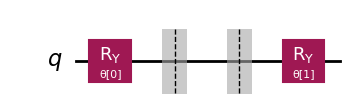

In [ ]:
from qiskit.circuit.library import RealAmplitudes

# the rotation gates are chosen randomly, so we set a seed for reproducibility
ansatz = RealAmplitudes(1, reps=1, entanglement='linear', insert_barriers = True) 
ansatz.decompose().draw('mpl', style='iqx')
# ansatz.count_ops()['barrier']

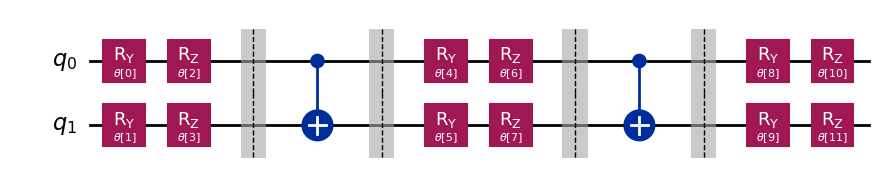

In [ ]:
ansatz = Customize_EfficientSU2(2,2)
ansatz.draw('mpl', style = 'iqx')

In [ ]:
ansatz_barrier = 0 

for i in range(len(ansatz)):
    if ansatz[i].operation.name == 'barrier':
        ansatz_barrier += 1

print(ansatz_barrier)


4


In [88]:
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit


# Step 3: Create the Customize Quantum Natural Gradient Descent

In [117]:
import numpy as np
from scipy.linalg import block_diag

# Parameter shift rule
def Customize_Parameter_Shift_Rule(operator, parameter, eta, ansatz, shots, backend, interation):
    """
    operator: The pauli operator
    parameter: the initial point that we will update until we end up with the desired point
    ansatz: the parameterized circuit that we want to update 
    eta: learning rate
    """
    number_of_parameters = len(parameter)
    grad = np.zeros(number_of_parameters)
    

    for i in range(len(operator)):
        grad_func = np.zeros(number_of_parameters)
        for j in range(number_of_parameters):
            plus_parameter = parameter.copy()
            plus_parameter[j] += np.pi/2
            minus_parameter = parameter.copy()
            minus_parameter[j] -= np.pi/2
            grad_func[j] = (eta*0.99**interation)*operator.coeffs.real[i]*(Measurement(str(operator.primitive._pauli_list[i]), ansatz.bind_parameters({theta: plus_parameter[i] for i, theta in enumerate(ansatz.parameters)}), shots, backend)[0] - Measurement(str(operator.primitive._pauli_list[i]), ansatz.bind_parameters({theta: minus_parameter[i] for i, theta in enumerate(ansatz.parameters)}), shots, backend)[0])/2
        grad = np.add(grad, grad_func)
    
    return np.array(grad)


# Gradient
def Customize_Gradient(operator, parameter, eta, ansatz, shots, backend, interation):
    """
    operator: The pauli operator
    parameter: the initial point that we will update until we end up with the desired point
    ansatz: the parameterized circuit that we want to update 
    eta: learning rate
    """
    number_of_parameters = len(parameter)
    grad = np.zeros(number_of_parameters)
    h = .01

    for i in range(len(operator)):
        grad_func = np.zeros(number_of_parameters)
        for j in range(number_of_parameters):
            plus_parameter = parameter.copy()
            plus_parameter[j] += h
            minus_parameter = parameter.copy()
            minus_parameter[j] -= h
            grad_func[j] = (eta*0.99**interation)*operator.coeffs.real[i]*(Measurement(str(operator.primitive._pauli_list[i]), ansatz.bind_parameters({theta: plus_parameter[i] for i,
             theta in enumerate(ansatz.parameters)}), shots, backend)[0] - Measurement(str(operator.primitive._pauli_list[i]), ansatz.bind_parameters({theta: minus_parameter[i] for i, theta in enumerate(ansatz.parameters)}), shots, backend)[0])/(2*h)
        grad = np.add(grad, grad_func)
    
    return np.array(grad)

def Seperate_Circuit_Apart(ansantz):
    # Divide the circuit to subcircuit of parameter circuit and non parameter circuit
    super_circuit = []
    no_name = 0

    ansatz_barrier = 0 

    for i in range(len(ansatz)):
        if ansatz[i].operation.name == 'barrier':
            ansatz_barrier += 1


    while no_name < (ansatz.size() + ansatz_barrier):
        if ansatz[no_name].operation.params:
            sub_circuit = QuantumCircuit(ansatz.num_qubits)
            for i in range(no_name, ansatz.num_qubits + no_name):
                sub_circuit.append(ansatz[i])
            super_circuit.append(sub_circuit)
            no_name += ansatz.num_qubits 
            
        elif ansatz[no_name].operation.name == 'barrier':
            no_name += 1
            
        else:
            sub_circuit = QuantumCircuit(ansatz.num_qubits)
            
            while not ansatz[no_name].operation.params:
                if ansatz[no_name].operation.name == 'barrier':
                    no_name += 1
                    break
                sub_circuit.append(ansatz[no_name])
                no_name += 1 

                if no_name == (ansatz.size() + ansatz_barrier - 1):
                    break

            super_circuit.append(sub_circuit)
    return super_circuit




def Customize_Quantum_Natural_Graident_Descent(operator, parameter, eta, ansatz, shots, backend, interation, super_circuit):
    """
    operator: The pauli operator
    parameter: the initial point that we will update until we end up with the desired point
    ansatz: the parameterized circuit that we want to update 
    """

    number_of_parameters = ansatz.num_parameters

    # return parameter_shift_rules(operator, parameter, ansatz)

    # Next, I will calculate the Fubini-Study metric, but first I would like to learn the way of extracting information from the ansatz, and calculate the Fubini-Study metric
    def fubini_stydy_metric(ansatz, parameter, shots, backend):
        def Measure_element_of_Fubini_Study_metric(circuit, circuit_for_measurement, i, j, shots, backend):
            if i != j:
                term1 = ['I']*len(circuit)
                term2 = ['I']*len(circuit)
                term3 = ['I']*len(circuit)
                
                # Change rotation gate to pauli gate
                # Term1
                if circuit[i].operation.name == 'rx':
                    term1[i] = 'X'
                    term2[i] = 'X'
                if circuit[i].operation.name == 'ry':
                    term1[i] = 'Y'
                    term2[i] = 'Y'
                if circuit[i].operation.name == 'rz':
                    term1[i] = 'Z'
                    term2[i] = 'Z'
                
                if circuit[j].operation.name == 'rx':
                    term1[j] = 'X'
                    term3[j] = 'X'
                if circuit[j].operation.name == 'ry':
                    term1[j] = 'Y'
                    term3[j] = 'Y'
                if circuit[j].operation.name == 'rz':
                    term1[j] = 'Z'
                    term3[j] = 'Z'

                # # Term 2
                # if circuit[i].operation.name == 'rx':
                #     term2[i] = 'X'
                # if circuit[i].operation.name == 'ry':
                #     term2[i] = 'Y'
                # if circuit[i].operation.name == 'rz':
                #     term2[i] = 'Z'

                # # Term 3
                # if circuit[j].operation.name == 'rx':
                #     term3[j] = 'X'
                # if circuit[j].operation.name == 'ry':
                #     term3[j] = 'Y'
                # if circuit[j].operation.name == 'rz':
                #     term3[j] = 'Z'
                

                term1 = ''.join(term1)
                term2 = ''.join(term2)
                term3 = ''.join(term3)

                return  (Measurement(term1, circuit_for_measurement, shots, backend)[0] - Measurement(term2, circuit_for_measurement, shots, backend)[0]*Measurement(term3, circuit_for_measurement, shots, backend)[0])/4
            else:
                # term1 = ['I']*len(circuit)
                term2 = ['I']*len(circuit)

                if circuit[i].operation.name == 'rx':
                    term2[i] = 'X'
                if circuit[i].operation.name == 'ry':
                    term2[i] = 'Y'
                if circuit[i].operation.name == 'rz':
                    term2[i] = 'Z'

                term2 = ''.join(term2)

                # new_gate = circuit_for_measurement.compose(new_gate)

                # return (Measurement(term1, circuit_for_measurement, shots, backend)[0] - Measurement(term2, circuit_for_measurement, shots, backend)[0].real**2)/4
                return (1 - Measurement(term2, circuit_for_measurement, shots, backend)[0].real**2)/4


        # Caculate the Fubini-Study metric in 1-qubit
        if ansatz.num_qubits == 1:
            initial_point = parameter
            # num_parameter = 0
            g = np.zeros((number_of_parameters, number_of_parameters))

            for i in range(len(super_circuit)):
                if super_circuit[i][0].operation.params:
                    internal_circuit = QuantumCircuit(super_circuit[i].num_qubits)
                    for j in range(i+1):
                        internal_circuit = internal_circuit.compose(super_circuit[j])

                    internal_circuit = internal_circuit.bind_parameters({theta: initial_point[i] for i, theta in enumerate(internal_circuit.parameters)})
                    # num_parameter += super_circuit[i].num_parameters

                    g[i][i] = Measure_element_of_Fubini_Study_metric(super_circuit[i], internal_circuit, 0, 0, shots, backend)
                    # print(np.round(g_internal,2))
            return g

        
        # Caculate the Fubini_study_metric
        g = []
        initial_point = parameter
        # num_parameter = 0


        for i in range(len(super_circuit)):
            if super_circuit[i][0].operation.params:
                g_internal = [[[] for _ in range(super_circuit[i].num_parameters)] for _ in range(super_circuit[i].num_parameters)]
                internal_circuit = QuantumCircuit(super_circuit[i].num_qubits)
                for j in range(i+1):
                    internal_circuit = internal_circuit.compose(super_circuit[j])

                internal_circuit = internal_circuit.bind_parameters({theta: initial_point[i] for i, theta in enumerate(internal_circuit.parameters)})
                # num_parameter += super_circuit[i].num_parameters

                # print(num_parameter)
                
                for l in range(super_circuit[i].num_parameters):
                    for m in range(super_circuit[i].num_parameters):
                        g_internal[l][m] = Measure_element_of_Fubini_Study_metric(super_circuit[i], internal_circuit, l, m, shots, backend)
                # print(np.round(g_internal,2))
                if g != []:
                    g = block_diag(g, g_internal)
                else:
                    g = block_diag(g_internal)
        
        return g
    
  
    # Gradient of the loss function
    grad = np.zeros(len(parameter))
    
    grad = Customize_Parameter_Shift_Rule(operator, parameter, eta, ansatz, shots, backend, interation)

    
    # grad = gradient(operator, parameter, ansatz)

    # Inverse of Fubini study metric
    FS_metric = np.linalg.pinv(fubini_stydy_metric(ansatz, parameter, shots, backend)).real
    # print(fubini_stydy_metric(ansatz, parameter, shots, backend))

    # print(FS_metric)

    combine = eta*FS_metric.dot(grad)

    
    return combine


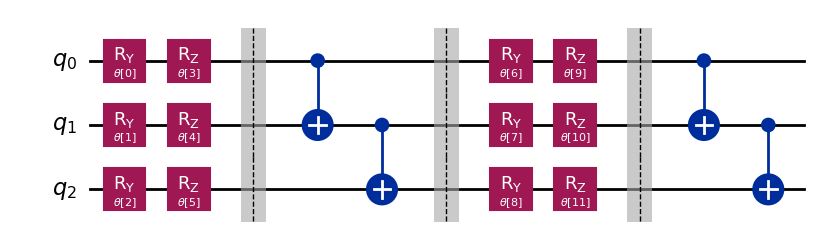

In [ ]:
qc = Customize_EfficientSU2(3,2)
qc.draw('mpl', style='iqx')

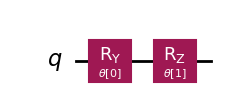

In [ ]:
ansatz = Customize_EfficientSU2(num_qubits, 1)
ansatz.draw('mpl', style = 'iqx')

# Customize SPSA optimize

In [ ]:
random = [np.random.uniform(-1,1) for _ in range(4)]
print(np.power(random, -1))

[10.12056719 -6.74415389  1.50822938  3.48070141]


In [351]:
import numpy as np 

def Customize_SPSA(operator, parameter, eta, ansatz, shots, backend, interation):
    """
    operator: The pauli operator
    parameter: the initial point that we will update until we end up with the desired point
    ansatz: the parameterized circuit that we want to update 
    eta: learning rate
    """


    # number_of_parameters = ansatz.num_parameters
    number_of_parameters = len(parameter)
    epsilon = 0.5

    grad = np.zeros(len(parameter))
    
    for i in range(len(operator)):
        random = [np.random.choice([-1,1])*epsilon for _ in range(number_of_parameters)]
        plus_parameter = np.array(parameter.copy())
        plus_parameter = np.add(plus_parameter,random)
        minus_parameter = np.array(parameter.copy())
        minus_parameter = np.subtract(minus_parameter,random)

        grad_func = (eta*0.99**interation)*operator.coeffs.real[i]*(Measurement(str(operator.primitive._pauli_list[i]), ansatz.bind_parameters({theta: plus_parameter[i] for i, theta in enumerate(ansatz.parameters)}), shots, backend)[0] - Measurement(str(operator.primitive._pauli_list[i]), ansatz.bind_parameters({theta: minus_parameter[i] for i, theta in enumerate(ansatz.parameters)}), shots, backend)[0])/(2*epsilon)

        grad = np.add(grad, grad_func*np.power(random, -1))



    return grad

In [8]:
from qiskit.opflow import Z, I
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit.opflow.primitive_ops.pauli_sum_op import PauliSumOp

hamiltonian = PauliSumOp(SparsePauliOp(['Z', 'X'],
              coeffs=[1,2]), coeff=1.0)

num_qubits = 1

eta = 0.01

shots = 2048

ansatz = Customize_EfficientSU2(num_qubits, 1)

from qiskit import Aer

backend = Aer.get_backend('qasm_simulator')

initial_point = (np.random.random(ansatz.num_parameters))
for i in range(5):
    Customize_Quantum_Natural_Graident_Descent(hamiltonian, initial_point, eta, ansatz, shots, backend)

TypeError: Customize_Quantum_Natural_Graident_Descent() missing 2 required positional arguments: 'interation' and 'super_circuit'

In [ ]:
a = [0, 0]
b = [-0.000283203125, -7.8125e-05]

c = np.add(a,b)

print(c)

[-2.83203125e-04 -7.81250000e-05]


# Step 4: Create the Custom VQE

In [166]:
def Customize_Variational_Quantum_EigenSolver(operator, optimize, interation, ansatz, eta, initial_point, shots, backend, callback):
    """
    operator: the pauli matrix
    interation: number of interations 
    ansatz: the ansatz for perparing the parameterized circuit
    eta: learning rate
    initial_points: random sample of number uses at the beggining of running
    shots: number of shots
    backend: the backend
    """

    energy = []

    internal_initial_point = initial_point.copy()
    

    for i in range(interation):
        print(f'{internal_initial_point} ---------')
        internal_anstaz = ansatz.bind_parameters({theta: internal_initial_point[k] for k, theta in enumerate(ansatz.parameters)})       
        # Measure the expectation of our hamiltonian
        internal_energy = 0
        for j in range(len(operator)):
            internal_energy += operator.coeffs.real[j] * Measurement(str(operator.primitive._pauli_list[j]), internal_anstaz, shots, backend)[0]
            # print( operator.coeffs.real[j])
            # print(operator.primitive._pauli_list[j])
            # print(internal_energy)
            
            # measure = Measurement('X', internal_anstaz, 10000, backend=Aer.get_backend('qasm_simulator'))[0]*10
            # print(f'///{measure}///')
        
        # print(f'{internal_initial_point} hmm')
        
        energy.append(internal_energy)
        print(internal_energy)


        if callback is not None:
            callback(internal_initial_point, internal_energy)

        # Update the parameter points
        if optimize == Customize_Quantum_Natural_Graident_Descent:
            super_circuit = Seperate_Circuit_Apart(ansatz)
            a = optimize(operator, internal_initial_point, eta, ansatz, shots, backend, interation, super_circuit)
            
            internal_initial_point =  np.subtract(internal_initial_point,a)
            print(internal_energy)

            continue

        a = optimize(operator, internal_initial_point, eta, ansatz, shots, backend, interation)
        internal_initial_point =  np.subtract(internal_initial_point,a)

        # print(internal_energy)

    if callback is None:
        return energy



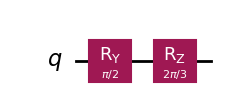

In [ ]:
ansatz = Customize_EfficientSU2(1, 1)
initial_point = np.array([np.pi/2, 2*np.pi/3])
# params = [1.11, 222]
internal = ansatz.bind_parameters({theta: initial_point[i] for i, theta in enumerate(ansatz.parameters)})

# internal = ansatz.bind_parameters({theta: params[i] for i, theta in enumerate(ansatz.parameters)})

internal.draw('mpl', style = 'iqx')



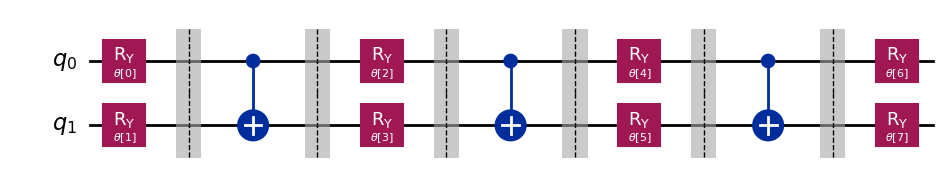

In [ ]:
ansatz = Customize_RealAmplidues(2,3)
ansatz.draw('mpl', style = 'iqx')

In [93]:
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit.opflow.primitive_ops.pauli_sum_op import PauliSumOp
from qiskit.algorithms import NumPyEigensolver


# hamiltonian = PauliSumOp(SparsePauliOp(['ZI', 'IX', 'ZX'],
#               coeffs=[1, -2, 2]), coeff=1.0)

hamiltonian = PauliSumOp(SparsePauliOp(['ZZI', 'IZZ', 'XII', 'IXI', 'IXX'],
                coeffs=[1, 1, 1, 1, 1]), coeff=1.0)

# hamiltonian = PauliSumOp(SparsePauliOp(['ZZZ', 'ZZZ', 'XZZ', 'ZXZ', 'ZXX'],
#                 coeffs=[1, 1, 1, 1, 1]), coeff=1.0)

# hamiltonian = PauliSumOp(SparsePauliOp(['ZZI', 'IZZ', 'XII', 'IXI', 'IXX'],
#                 coeffs=[1, 1, 1, 1, .11]), coeff=1.0)

# find the first three (k=3) eigenvalues
exact_solver = NumPyEigensolver(k=20)
exact_result = exact_solver.compute_eigenvalues(hamiltonian)
print(exact_result.eigenvalues.real)
# print(exact_result.eigenstates)


[-3.60555128 -2.23606798 -1.         -1.          1.          1.
  2.23606798  3.60555128]


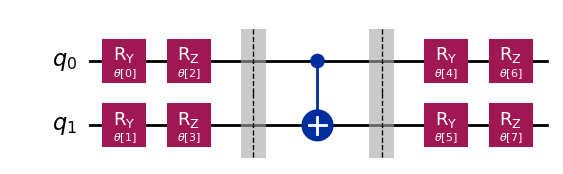

In [ ]:
num_qubits = 2
ansatz = Customize_EfficientSU2(num_qubits, 1)

ansatz.draw('mpl', style='iqx')

Ising hamiltonian

In [96]:
from qiskit.opflow import Z, I, X

def Ising_hamiltonian(num_qubits, h):
    hamiltonian = 0
    hamiltonian += Z^(I^(num_qubits-2))^Z
    for i in range(num_qubits-1):
        hamiltonian += (I^(i))^(Z^Z)^(I^(num_qubits-2-i))
    
    for i in range(num_qubits):
        hamiltonian += h*((I^(i))^(X)^(I^(num_qubits-1-i)))

    return hamiltonian.reduce()

hamiltonian = Ising_hamiltonian(3,2)

print(hamiltonian)



1.0 * ZIZ
+ 1.0 * ZZI
+ 1.0 * IZZ
+ 2.0 * XII
+ 2.0 * IXI
+ 2.0 * IIX


In [126]:
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit.opflow.primitive_ops.pauli_sum_op import PauliSumOp
from qiskit.algorithms import NumPyEigensolver


hamiltonian = PauliSumOp(SparsePauliOp(['Z', 'X'],
              coeffs=[-20, 10]), coeff=1.0)

# hamiltonian = PauliSumOp(SparsePauliOp(['ZZI', 'IZZ', 'XII', 'IXI', 'IXX'],
#                 coeffs=[1, 1, 1, 1, .11]), coeff=1.0)

# hamiltonian = PauliSumOp(SparsePauliOp(['ZZI', 'IZZ', 'XII', 'IXI', 'IXX'],
#                 coeffs=[1, 1, 1, 1, 1]), coeff=1.0)
                

# find the first three (k=3) eigenvalues
exact_solver = NumPyEigensolver(k=100)
exact_result = exact_solver.compute_eigenvalues(hamiltonian)
print(exact_result.eigenvalues.real)
# print(exact_result.eigenstates)


[-22.36067977  22.36067977]


# Test VQE

In [352]:
from qiskit.opflow import Z, I, X
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit.opflow.primitive_ops.pauli_sum_op import PauliSumOp
import time

start_time = time.time()

num_qubits = 1 # (N_p = num_qubit-1)


# Ising hamiltonian
def Ising_hamiltonian(num_qubits, h):
    hamiltonian = 0
    hamiltonian += Z^(I^(num_qubits-2))^Z
    for i in range(num_qubits-1):
        hamiltonian += (I^(i))^(Z^Z)^(I^(num_qubits-2-i))
    
    for i in range(num_qubits):
        hamiltonian += h*((I^(i))^(X)^(I^(num_qubits-1-i)))

    return hamiltonian.reduce()

# hamiltonian = Ising_hamiltonian(num_qubits,2)

# print(hamiltonian)



intermediate_info = {
    'parameters': [],
    'energy': [],
}

def callback(parameters, energy):
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)


# def QHO_hamiltionian(number_qubit, omegaQ, alpha):
    
#     def number_operator(theta):
#         n = 0
#         for i in range(1,theta):
#             n += (i*(I^(i))^(Z+I)^(I^(theta-i)))/2
#         n += (theta*(I^(theta))^(Z+I))/2

#         return n

#     hamiltonian = alpha/2*(number_operator(number_qubit-1) @ number_operator(number_qubit-1))
#     hamiltonian += (omegaQ-alpha/2)*number_operator(number_qubit-1)
#     return hamiltonian.reduce()
    

# hamiltonian = QHO_hamiltionian(num_qubits, 1, 1)

# hamiltonian = PauliSumOp(SparsePauliOp(['ZY', 'XX'],
#               coeffs=[10, -20]), coeff=1.0)


# hamiltonian = PauliSumOp(SparsePauliOp(['ZZI', 'IZZ', 'XII', 'IXI', 'IXX'],
#                 coeffs=[1, 1, 1, 1, 1]), coeff=1.0)
                
hamiltonian = PauliSumOp(SparsePauliOp(['X', 'Z'],
              coeffs=[-20, 10]), coeff=1.0)

# hamiltonian = PauliSumOp(SparsePauliOp(['Z'],
#               coeffs=[10]), coeff=1.0)
              

# hamiltonian = PauliSumOp(SparsePauliOp(['Z'],
#               coeffs=[10]), coeff=1.0)

# hamiltonian = PauliSumOp(SparsePauliOp(['X','Z'],
#               coeffs=[10, -20]), coeff=1.0)


# hamiltonian = PauliSumOp(SparsePauliOp(['Z', 'X'],
#               coeffs=[10, -20]), coeff=1.0)

# ansatz = Customize_EfficientSU2(num_qubits, 1)
# ansatz.cx(0,1)
# ansatz.cx(1,2)
ansatz = Customize_EfficientSU2(1, 1)

interation = 20

eta = .01

# eta = 0.1
# 2pi - pi
initial_point = np.array([2*np.pi*85/100, np.pi*.4])
# initial_point = np.array([-0.86194811,  2.3760609,   0.04877189,  1.07293971,  1.26281746,  0.81641837,
#   1.06472061,  0.11116556,  1.92938462,  0.563808,    3.20344537,  0.30303574])
# initial_point = np.array([ 2.84375697e+00, -1.0127

shots = 40000

from qiskit import Aer

backend = Aer.get_backend('qasm_simulator')

VQE_runtime = Customize_Variational_Quantum_EigenSolver(hamiltonian, Customize_SPSA, interation, ansatz, eta, initial_point, shots, backend, callback)

# print(VQE_runtime)

print(time.time() - start_time)

# print(VQE_runtime[-1])

[5.34070751 1.25663706] ---------
10.988
[5.47512234 1.39105189] ---------
9.2875
[5.20298834 1.66318588] ---------
2.9159999999999995
[5.29559994 1.75579749] ---------
2.458
[5.35957662 1.81977417] ---------
1.9449999999999994
[5.40537941 1.86557696] ---------
1.9020000000000001
[5.03252836 1.99901029] ---------
-4.614000000000001
[5.08748352 2.34842832] ---------
-9.412
[5.05042416 2.31136895] ---------
-9.462
[4.64423522 2.41650271] ---------
-15.5165
[4.32007416 2.74066377] ---------
-20.845499999999998
[4.37106248 2.79165209] ---------
-21.110999999999997
[4.22160634 2.64599104] ---------
-20.274
[4.31310559 2.73749029] ---------
-20.805
[4.16603775 2.88455813] ---------
-21.735500000000002
[4.11012563 2.67186961] ---------
-20.3365
[4.01679427 2.76520098] ---------
-20.689999999999998
[3.9829002  2.79909504] ---------
-20.7895
[3.97035351 2.57503761] ---------
-19.0995
[4.1217808  2.95587144] ---------
-21.8125
14.529673337936401


In [182]:
intermediate_info['parameters'][0]

array([3.14159265, 0.        ])

In [213]:
H = {'X':20, 'Z':-10}

In [214]:
H.keys()

dict_keys(['X', 'Z'])

In [261]:
import numpy as np
from qiskit import Aer
backend = Aer.get_backend('qasm_simulator')

t = 100
shots = 20000

Parameter_Space = np.zeros((t,t))



for i in range(t):
    
    ansatz = Customize_EfficientSU2(1, 1)
    phi = 2*np.pi*(i/t)
    for j in range(t):
        theta = np.pi*(j/t)
        bind_ansatz = QuantumCircuit(1)
        bind_ansatz.ry(phi, 0)
        bind_ansatz.rz(theta, 0)
        Parameter_Space[i][j] = -20*Measurement('Z', bind_ansatz, shots, backend)[0] +  10*Measurement('X', bind_ansatz, shots, backend)[0]

        


In [245]:
phi = 3
theta = 3
bind_ansatz = QuantumCircuit(1)
bind_ansatz.ry(phi, 0)
bind_ansatz.rz(theta, 0)
print(-20*Measurement('Z', bind_ansatz, shots, backend)[0] +  10*Measurement('X', bind_ansatz, shots, backend)[0])

18.55


In [247]:
Parameter_Space

array([[-19.979, -19.959, -19.997, ..., -19.868, -20.015, -19.867],
       [-19.315, -19.257, -19.338, ..., -20.541, -20.615, -20.552],
       [-18.598, -18.658, -18.547, ..., -21.019, -21.012, -21.16 ],
       ...,
       [-21.531, -21.591, -21.55 , ..., -17.67 , -17.788, -17.799],
       [-21.146, -21.027, -21.039, ..., -18.734, -18.55 , -18.59 ],
       [-20.649, -20.554, -20.67 , ..., -19.27 , -19.281, -19.22 ]])

In [353]:
x = np.zeros(len(intermediate_info['parameters']))
y = np.zeros(len(intermediate_info['parameters']))

data = intermediate_info['parameters']

for i in range(len(intermediate_info['parameters'])):
    x[i] = data[i][0]
    y[i] = data[i][1]

In [354]:
x

array([5.34070751, 5.47512234, 5.20298834, 5.29559994, 5.35957662,
       5.40537941, 5.03252836, 5.08748352, 5.05042416, 4.64423522,
       4.32007416, 4.37106248, 4.22160634, 4.31310559, 4.16603775,
       4.11012563, 4.01679427, 3.9829002 , 3.97035351, 4.1217808 ])

In [355]:
y

array([1.25663706, 1.39105189, 1.66318588, 1.75579749, 1.81977417,
       1.86557696, 1.99901029, 2.34842832, 2.31136895, 2.41650271,
       2.74066377, 2.79165209, 2.64599104, 2.73749029, 2.88455813,
       2.67186961, 2.76520098, 2.79909504, 2.57503761, 2.95587144])

In [180]:
intermediate_info['energy']

[19.926,
 18.146,
 14.884999999999998,
 9.764000000000001,
 2.9640000000000004,
 -5.293,
 -12.417,
 -17.491,
 -20.114,
 -21.571,
 -21.822,
 -22.073,
 -22.417,
 -22.326999999999998,
 -22.383000000000003,
 -22.317,
 -22.255000000000003,
 -22.392,
 -22.256999999999998,
 -22.278]

In [ ]:
data = [1.8435, 1.64385, 1.48295, 1.2423499999999998, 1.0141, 0.7488499999999998, 0.4646499999999999, 0.18555, -0.08034999999999995, -0.35185, -0.58485, -0.8206999999999999, -1.01185, -1.20155, -1.3255, -1.4866, -1.56695, -1.6390500000000001, -1.73395, -1.8027000000000002, -1.8685000000000003, -1.9377499999999999, -1.9872, -2.0617, -2.10435, -2.152, -2.217, -2.2674499999999997, -2.32335, -2.3653999999999997, -2.4309000000000003, -2.46625, -2.5132, -2.5466, -2.60375, -2.6619, -2.6866000000000003, -2.7265999999999995, -2.7529, -2.7994499999999998, -2.8381999999999996, -2.86375, -2.9006499999999997, -2.9164000000000003, -2.9536000000000002, -2.9637999999999995, -2.99095, -3.00965, -3.02555, -3.03475, -3.0526, -3.0573499999999996, -3.07565, -3.0707999999999998, -3.0922, -3.1081499999999997, -3.1, -3.1188000000000002, -3.1467, -3.13615, -3.1414, -3.1498999999999997, -3.1622999999999997, -3.15945, -3.1700500000000003, -3.1669, -3.1542999999999997, -3.1658, -3.1606, -3.1832000000000003, -3.18405, -3.1980999999999997, -3.1959, -3.21075, -3.19765, -3.2186000000000003, -3.19965, -3.2094500000000004, -3.2069999999999994, -3.2131999999999996, -3.2250500000000004, -3.2221, -3.22175, -3.2330000000000005, -3.2382999999999997, -3.2308000000000003, -3.23565, -3.2485000000000004, -3.2545, -3.2656, -3.26425, -3.2645999999999997, -3.2714999999999996, -3.2840999999999996, -3.2716000000000003, -3.28065, -3.3059999999999996, -3.2893, -3.3073499999999996, -3.3064000000000004, -3.3103, -3.30605, -3.3249999999999997, -3.3083, -3.3253500000000003, -3.33155, -3.3343499999999997, -3.3312999999999997, -3.3382, -3.2104000000000004, -2.5495, -0.2988999999999999, -0.47650000000000003, -2.29495, -3.25035, -3.3375, -3.3399, -2.12975, -3.30695, -1.1154, -1.2699500000000001, -1.32595, -2.9345499999999998, -2.8979, -0.61185, -3.0581499999999995, -0.7578499999999999, -3.29655, -0.8328, -1.38605, -2.26505, -3.2464999999999997, -2.8868, -2.38375, -1.35275, -3.2787000000000006, -3.06035, -2.45825, -2.75415, -1.8259499999999997, -3.3718500000000002, -3.2727, -2.96655, -1.9577499999999999, -2.7764499999999996, -2.1477, -2.9685, -2.24355, -2.83355, -2.02405, -2.74925, -1.2996, -2.3449999999999998, -2.5060499999999997, -1.4375, -2.9205, -2.42485, -1.29775, -1.4304000000000001, -2.39415, -2.8124999999999996, -3.3158000000000003, -3.1752499999999997, -2.9038, -2.2583500000000005, -2.6794000000000002, -2.17775, -3.0692500000000003, -1.8455500000000002, -2.99845, -1.7234999999999998, -3.2845000000000004, -2.9469000000000003, -1.3805, -2.0559, -1.5958500000000002, -3.1338500000000002, -2.7973000000000003, -1.83785, -3.3057499999999997, -2.8015, -1.4044500000000002, -2.8428000000000004, -1.3768, -1.72765, -3.3763, -3.4036, -3.41255, -3.3857999999999997, -3.2558, -1.78515, -2.6276, -1.3672000000000002, -1.7635, -3.3314, -3.16305, -2.5131500000000004, -2.18285, -1.67625, -3.3710000000000004]


In [ ]:
a = np.array([[1,2], [-1,2]])
print(np.p)

In [ ]:
print(np.dot(b,a))
print(np.dot(a,b))

[[-1  6]
 [-8  4]]
[[-5 12]
 [-7  8]]


In [ ]:
print(VQE_runtime)

[0.28159999999999996, -0.8338, -1.8353, -1.9748999999999999, -0.8373000000000002, -0.15300000000000005, -0.5754000000000001, -0.25460000000000005, -0.7692999999999998, -1.5819, -2.3581999999999996, -2.6546999999999996, -2.7766, -2.7859, -2.4106, -1.7168999999999999, -2.1854, -1.5399, -2.4297, -0.6551, -1.6259000000000001, -2.5625999999999998, -2.6837999999999997, -2.8482000000000003, -2.4818, -1.5265000000000002, -1.22, 0.029700000000000018, -1.4196, -1.9233, -2.4061000000000003, -2.6712000000000002, -2.8701999999999996, -2.9959, -2.9774, -2.5705999999999998, -1.4841, -2.3501, -2.4301, -2.0991, -2.2827, -2.4247, -2.7283, -2.8796, -2.9873000000000003, -3.0940000000000003, -3.1626, -3.2131, -3.2149, -3.2535, -3.2615, -3.2910000000000004, -3.2721999999999998, -3.2879999999999994, -3.2776, -3.3171999999999997, -3.2885999999999997, -3.291, -3.3072999999999997, -3.3154, -3.2885, -3.3048, -3.3095999999999997, -3.3125999999999998, -3.326, -3.3068, -3.3089000000000004, -3.3240999999999996, -3.3

In [ ]:
print(VQE_runtime[-1])

-3.5833999999999997


# Test Swap test

{'0': 1511, '1': 489}


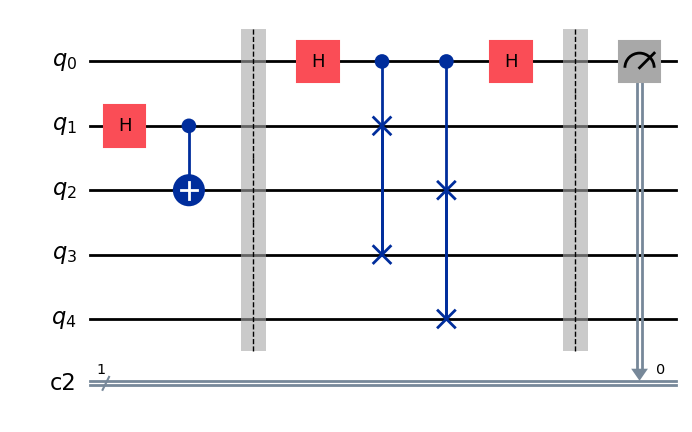

In [ ]:
from qiskit import QuantumCircuit
from qiskit import ClassicalRegister
from qiskit import Aer

qc1 = QuantumCircuit(2)
qc1.h(0)
# qc1.h(1)
qc1.cx(0,1)

qc2 = QuantumCircuit(2)
# qc2.h(0)
# qc2.x(1)

circ = QuantumCircuit(5)

circ = circ.compose(qc1, [1,2])

circ = circ.compose(qc2, [3,4])

circ.barrier()

circ.h(0)
circ.cswap(0, 1, 3)
circ.cswap(0, 2, 4)
circ.h(0)

circ. barrier()
# # First measurement
CR2 = ClassicalRegister(1)

circ.add_register(CR2)

circ.measure(0, 0)

simulator = Aer.get_backend('aer_simulator')
result = simulator.run(circ, shots = 2000).result()

counts = result.get_counts()

# print(result)
print(counts)

circ.draw('mpl', style='iqx')

489

0.2469


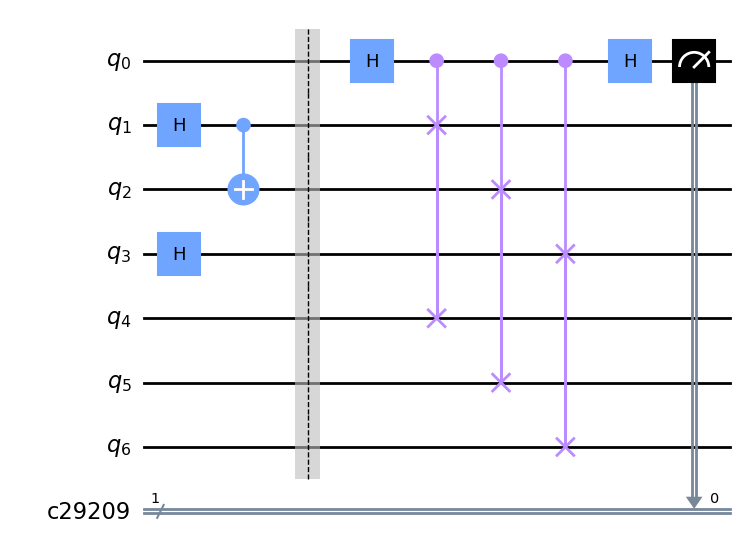

In [ ]:
from qiskit import QuantumCircuit
from qiskit import ClassicalRegister
from qiskit import Aer

def SwapTestCircuit(circ1, circ2):
    """
    circ1: for the parameter circuit of VQD
    circ2: for the parameter circuit of VQE, this circuit have the infromation from the VQE running, or the k-1 of VQD running
    shots: number of shots
    backend: backend for running
    """

    # Perpare the circuit
    num_qubits = circ1.num_qubits
    circ = QuantumCircuit(2*num_qubits+1) # Plus one for the ancilla qubit

    circ = circ.compose(circ1, [i for i in range(1, num_qubits+1)])
    circ = circ.compose(circ2, [i for i in range(num_qubits+1, num_qubits*2+1)])
    circ.barrier()

    circ.h(0)

    for i in range(1, num_qubits+1):
        circ.cswap(0, i, i+num_qubits)

    circ.h(0) 


    # Make measurement
    measurement = ClassicalRegister(1)
    circ.add_register(measurement)
    circ.measure(0, 0)

    # result = simulator.run(circ, shots = shots).result()

    # counts = result.get_counts()

    # overlap_value = 1 - 2*counts['1']/shots

    
    return circ
        
simulator = Aer.get_backend('aer_simulator')

qc1 = QuantumCircuit(3)
qc1.h(0)
qc1.h(2)
qc1.cx(0,1)

qc2 = QuantumCircuit(3)
# qc2.x(0)

circ12 = SwapTestCircuit(qc1, qc2)

print(overlap_value)
circ12.draw('mpl')

# Overlap circuit

In [15]:
# gradient of overlap term
from qiskit import QuantumCircuit


def Overlap_Circuit(super_circuit, compared_circuit):
    """
    super_circuit: ansatz circuit for perparing k-state perpare form the seprerate circuit apart
    compared_circuit: ansatz circuit from the data of 0-(k-1) state
    return the overlap term of them
    """
    gradient_overlap_term_circuit = []

    for i in range(len(super_circuit)):
        if super_circuit[i][0].operation.params:
            for j in range(super_circuit[i].num_qubits):
                if super_circuit[i][j].operation.name == 'rx':
                    qc = QuantumCircuit(super_circuit[i].num_qubits)
                    qc.x(j)

                    internal_circuit = QuantumCircuit(super_circuit[i].num_qubits)
                    for k in range(i+1):
                        internal_circuit = internal_circuit.compose(super_circuit[k])
                    
                    internal_circuit = internal_circuit.compose(qc)

                    for k in range(i+1, len(super_circuit)):
                        internal_circuit = internal_circuit.compose(super_circuit[k])
                    
                    gradient_overlap_term_circuit.append(internal_circuit) 


                if super_circuit[i][j].operation.name == 'ry':
                    qc = QuantumCircuit(super_circuit[i].num_qubits)
                    qc.y(j)
                    internal_circuit = QuantumCircuit(super_circuit[i].num_qubits)
                    for k in range(i+1):
                        internal_circuit = internal_circuit.compose(super_circuit[k])
                    
                    internal_circuit = internal_circuit.compose(qc)

                    for k in range(i+1, len(super_circuit)):
                        internal_circuit = internal_circuit.compose(super_circuit[k])
                    
                    gradient_overlap_term_circuit.append(internal_circuit)
                        
                if super_circuit[i][j].operation.name == 'rz':
                    qc = QuantumCircuit(super_circuit[i].num_qubits)
                    qc.z(j)
                    internal_circuit = QuantumCircuit(super_circuit[i].num_qubits)
                    for k in range(i+1):
                        internal_circuit = internal_circuit.compose(super_circuit[k])
                    
                    internal_circuit = internal_circuit.compose(qc)

                    for k in range(i+1, len(super_circuit)):
                        internal_circuit = internal_circuit.compose(super_circuit[k])

                    gradient_overlap_term_circuit.append(internal_circuit)



    for i in range(len(gradient_overlap_term_circuit)):
        gradient_overlap_term_circuit[i] = (SwapTestCircuit(gradient_overlap_term_circuit[i], compared_circuit))
    return gradient_overlap_term_circuit

# STEP 6: SWAP TEST

In [1]:
from qiskit import QuantumCircuit
from qiskit import ClassicalRegister
from qiskit import Aer

def SwapTestCircuit(circ1, circ2):
    """
    circ1: for the parameter circuit of VQD
    circ2: for the parameter circuit of VQE, this circuit have the infromation from the VQE running, or the k-1 of VQD running
    shots: number of shots
    backend: backend for running
    """

    # Perpare the circuit
    num_qubits = circ1.num_qubits
    circ = QuantumCircuit(2*num_qubits+1) # Plus one for the ancilla qubit

    circ = circ.compose(circ1, [i for i in range(1, num_qubits+1)])
    circ = circ.compose(circ2, [i for i in range(num_qubits+1, num_qubits*2+1)])
    circ.barrier()

    circ.h(0)
    for i in range(1, num_qubits+1):
        circ.cswap(0, i, i+num_qubits)
    circ.h(0) 

    # Make measurement
    measurement = ClassicalRegister(1)
    circ.add_register(measurement)
    circ.measure(0, 0)  

    return circ


class Customize_Variational_Quantum_Deflation:
    """
    operator: the pauli operator for finding the ground and excited energy
    interation: number interation for finding ground state energy
    ansatz the parameter circuit from the prerious VQE_runtime
    eta: the learning rate
    initial point: the random point for running
    data_from_VQE: the optimal parameter from VQE runtime
    shots: number of shots
    backend: the backend for simulate quantum computing
    callback: storage data
    """

    def __init__(self, operator: str, interation: int, ansatz, optimize, k, eta: float, initial_point, data_from_VQE, shots, backend, callback):
        # super().__init__()
        # we can add assert for aditional condition for our variable
        # Run validations to the recevied aguments
        assert interation >= 0, f'number of interation need to be greater than 0'


        self.operator = operator
        self.interation = interation
        self.ansatz = ansatz
        self.optimize = optimize
        self.k = k
        self.eta = eta
        self.initial_point = initial_point
        self.data_from_VQE = data_from_VQE
        self.shots = shots
        self.backend = backend
        self.callback = backend

    def __repr__(self):
        return f"VQD('{self.operator}', '{self.interation}', '{self.shots}', '{self.eta}')"
    
    def run_VQD(self):
        
        energy = []
        internal_initial_point = self.initial_point.copy()

        overlap_Gradient_circuit = Overlap_Circuit(Seperate_Circuit_Apart(self.ansatz), self.ansatz.bind_parameters({theta: self.data_from_VQE[k] for k, theta in enumerate(ansatz.parameters)}))
        
        for j in range(interation):
            print(f'{internal_initial_point} ---------')
            # Ansatz for the VQE-like term
            internal_anstaz = self.ansatz.bind_parameters({theta: internal_initial_point[k] for k, theta in enumerate(ansatz.parameters)})       
            
            # Calculate the cost function of the VQD or excited-k energy
            internal_energy = 0
            overlap_value = 0
            beta = 50
            

            b = 0
            for j in range(len(self.operator)):
                internal_energy += self.operator.coeffs.real[j] * Measurement(str(self.operator.primitive._pauli_list[j]), internal_anstaz, self.shots, self.backend)[0]

        
            for i in range((self.k)): # I will start with the simple one first
                overlap_circuit = SwapTestCircuit(internal_anstaz, ansatz.bind_parameters({theta: self.data_from_VQE[k] for k, theta in enumerate(ansatz.parameters)}))
                # measure the overlap value
                simulator = self.backend
                result = simulator.run(overlap_circuit, shots = self.shots).result()
                counts = result.get_counts()
                overlap_value += 1 - 2*counts['1']/self.shots




                overlap_Gradient_value = np.zeros(self.ansatz.num_parameters)

                # measurement the gradient of the overlap term
                for k in range(self.ansatz.num_parameters):
                    simulator = self.backend
                    result = simulator.run(overlap_Gradient_circuit[k].bind_parameters({theta: internal_initial_point[k] for k, theta in enumerate(ansatz.parameters)}), shots = self.shots*10).result()
                    counts = result.get_counts()
                    
                    # Add gradient of
                    overlap_Gradient_value[k] =  (1 - 2*counts['1']/(self.shots*10))*beta/4
                
                print(f'overlap gradient value {overlap_Gradient_value}')

                b = np.add(overlap_Gradient_value, b)
                    
            
            
            internal_energy += beta*overlap_value
            
            energy.append(internal_energy)

            b += self.optimize(self.operator, internal_initial_point, self.eta, self.ansatz, self.shots, self.backend, interation)

            print(f'gradient of usual {self.optimize(self.operator, internal_initial_point, self.eta, self.ansatz, self.shots, self.backend, interation)}')
            
            internal_initial_point = np.subtract(internal_initial_point, b)

            print(internal_energy)

    


# intermediate_info_of_VQE = {
# 'parameters': [],
# 'energy': [],
# 'steps': [],
# }

# def callback(energy, parameters=None):
#     intermediate_info['parameters'].append(parameters)
#     intermediate_info['energy'].append(energy)  


    

In [18]:
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit.opflow.primitive_ops.pauli_sum_op import PauliSumOp
from qiskit.algorithms import NumPyEigensolver

# hamiltonian = PauliSumOp(SparsePauliOp(['Z', 'X'],
#               coeffs=[1, -2]), coeff=1.0)

hamiltonian = PauliSumOp(SparsePauliOp(['Z', 'X'],
              coeffs=[10, -20]), coeff=1.0)

exact_solver = NumPyEigensolver(k=16)
exact_result = exact_solver.compute_eigenvalues(hamiltonian)
print(exact_result.eigenvalues.real)

[-22.36067977  22.36067977]


In [19]:
# hamiltonian = PauliSumOp(SparsePauliOp(['Z', 'X'],
#               coeffs=[1, -2]), coeff=1.0)

# hamiltonian = PauliSumOp(SparsePauliOp(['Z'],
#               coeffs=[1]), coeff=1.0)

hamiltonian = PauliSumOp(SparsePauliOp(['Z', 'X'],
              coeffs=[10, -20]), coeff=1.0)
              
ansatz = Customize_RealAmplidues(1, 2)

interation = 10
eta = 0.01

initial_point = np.array([0.0, 0.68032529])
data_from_VQE = np.array([2.03246511, 0.00350029])

shots = 20000


from qiskit import Aer

backend = Aer.get_backend('qasm_simulator')
            
runningVQD = Customize_Variational_Quantum_Deflation(hamiltonian, interation, ansatz, Customize_Parameter_Shift_Rule, 1, eta, initial_point, data_from_VQE, shots, backend, callback=None)

In [20]:
runningVQD.run_VQD()

[0.         0.68032529] ---------
overlap gradient value [4.8885  4.87225]
gradient of usual [-0.19780193 -0.1959389 ]
25.284000000000002
[-4.69001074 -3.99466089] ---------
overlap gradient value [7.9525 7.944 ]
gradient of usual [0.19478129 0.19449641]
24.232999999999997
[-12.83761309 -12.13305782] ---------
overlap gradient value [8.098375 8.1245  ]
gradient of usual [-0.19322123 -0.19366438]
24.944
[-20.74321001 -20.06441798] ---------
overlap gradient value [3.6235   3.602875]
gradient of usual [0.18410958 0.18454368]
26.096999999999994
[-24.55043522 -23.85160153] ---------
overlap gradient value [0.063125 0.07425 ]
gradient of usual [-0.03607128 -0.03365206]
27.624
[-24.58044627 -23.89166589] ---------
overlap gradient value [0.174375 0.135125]
gradient of usual [-0.04828496 -0.04722683]
27.523000000000007
[-24.70598464 -23.97906212] ---------
overlap gradient value [0.66375 0.61775]
gradient of usual [-0.0881863  -0.08711008]
27.287000000000003
[-25.28094241 -24.50779379] ------

KeyboardInterrupt: 

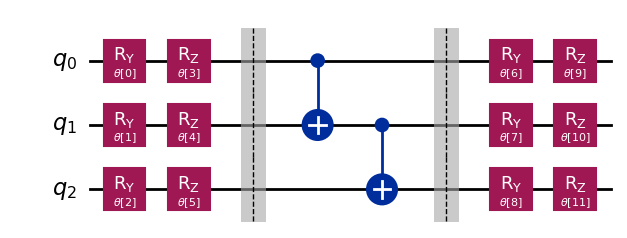

In [111]:
ansatz = Customize_EfficientSU2(3,1)
ansatz.draw('mpl', style='iqx')

In [114]:
# Gradient of the overlap circuit
super_circuit = Seperate_Circuit_Apart(ansatz)

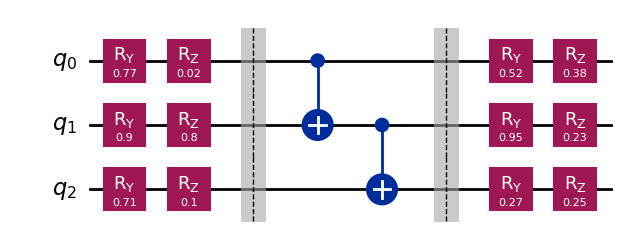

In [167]:
data_from_VQE = np.round((np.random.random(ansatz.num_parameters)),2)
qc_circuit = ansatz.bind_parameters({theta: data_from_VQE[k] for k, theta in enumerate(ansatz.parameters)})
qc_circuit.draw('mpl', style='iqx')

In [200]:
qc12 = Overlap_Circuit(super_circuit, qc_circuit)

In [177]:

gradient_overlap_term_circuit2 = []

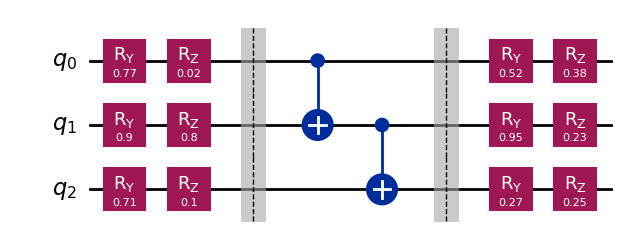

In [174]:
qc_circuit.draw('mpl', style='iqx')

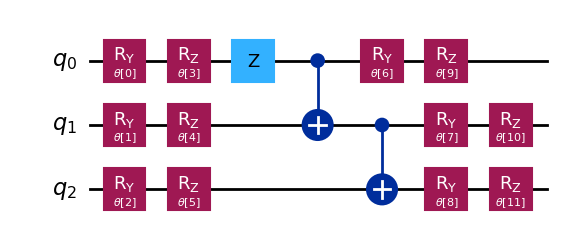

In [173]:
gradient_overlap_term_circuit1[0].draw('mpl', style='iqx')

In [178]:
gradient_overlap_term_circuit2.append(SwapTestCircuit(gradient_overlap_term_circuit1[0], qc_circuit))

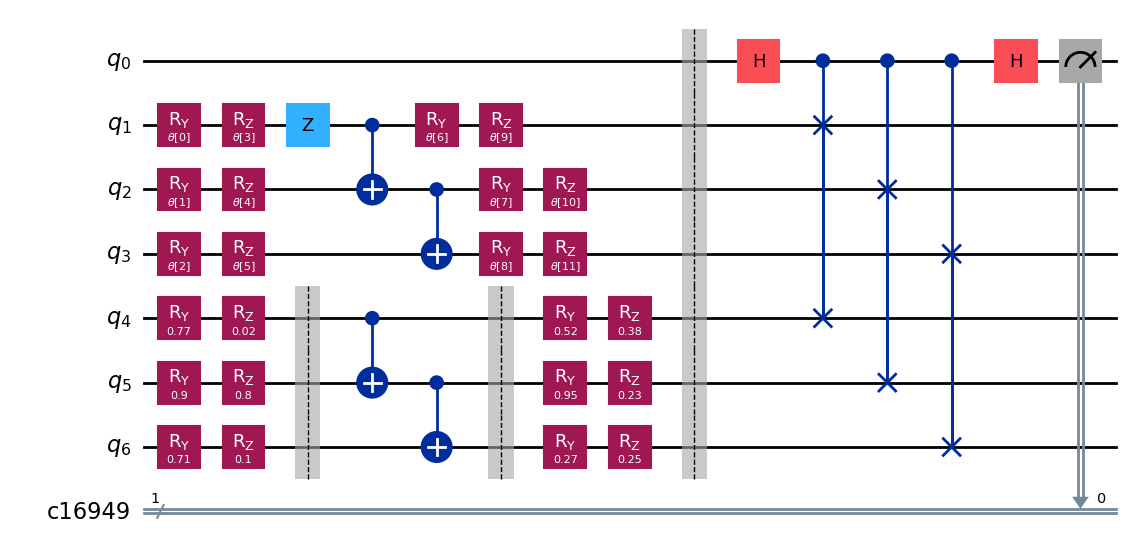

In [180]:
gradient_overlap_term_circuit2[0].draw('mpl', style='iqx')

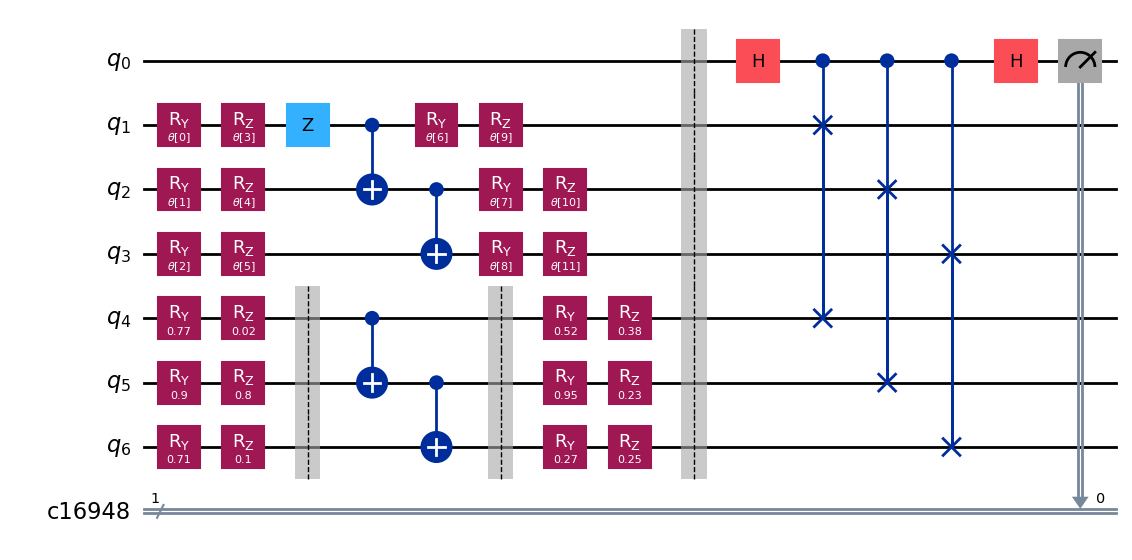

In [176]:
asndsdoks = SwapTestCircuit(gradient_overlap_term_circuit1[0], qc_circuit)

asndsdoks.draw('mpl', style='iqx')

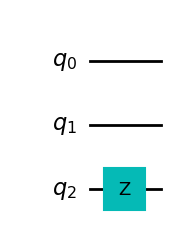

In [166]:
qc.draw('mpl')

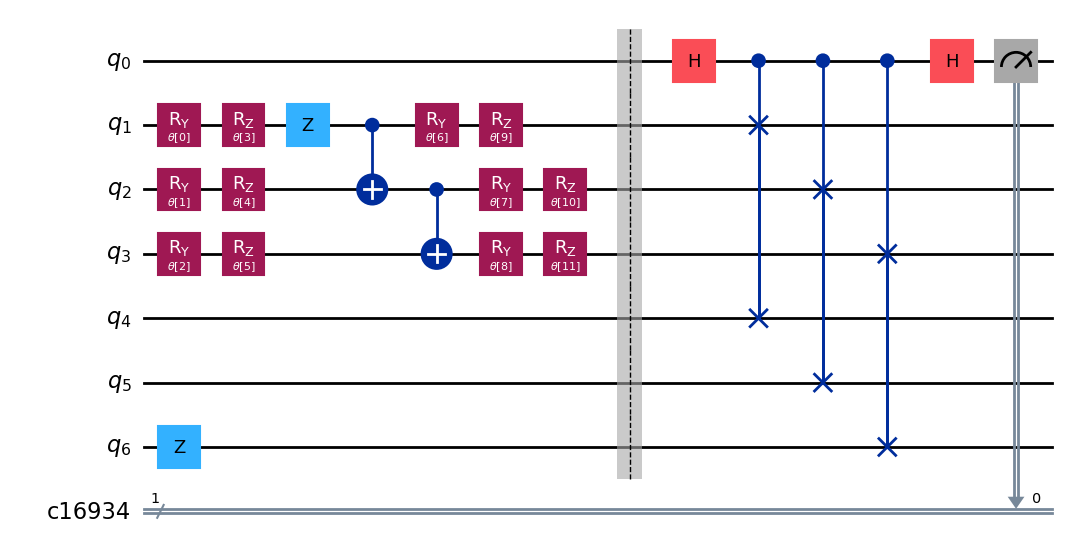

In [165]:
aaaa = SwapTestCircuit(gradient_overlap_term_circuit1[0],qc)
aaaa.draw('mpl', style='iqx')

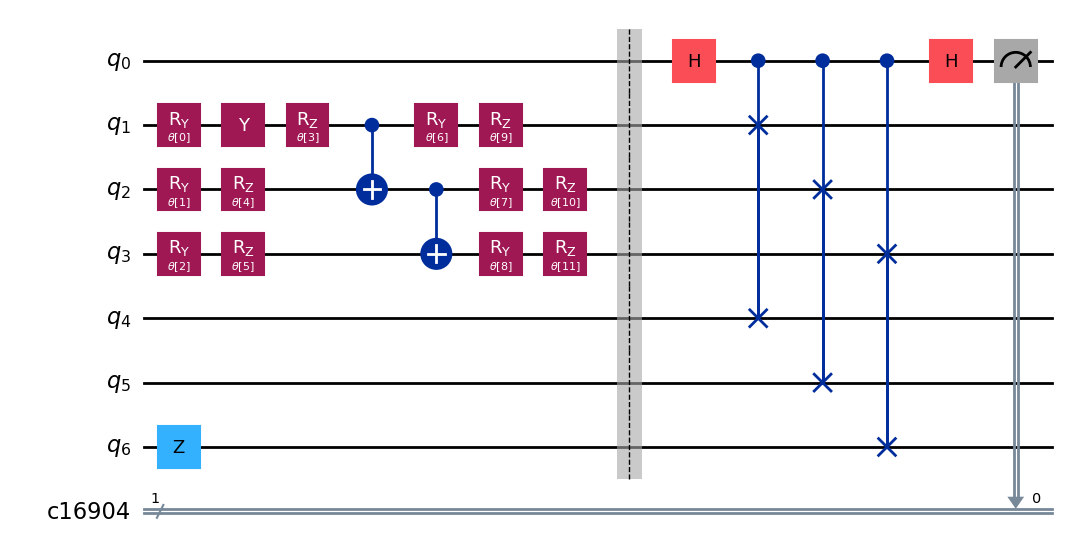

In [150]:
gradient_overlap_term_circuit[0].draw('mpl', style='iqx')

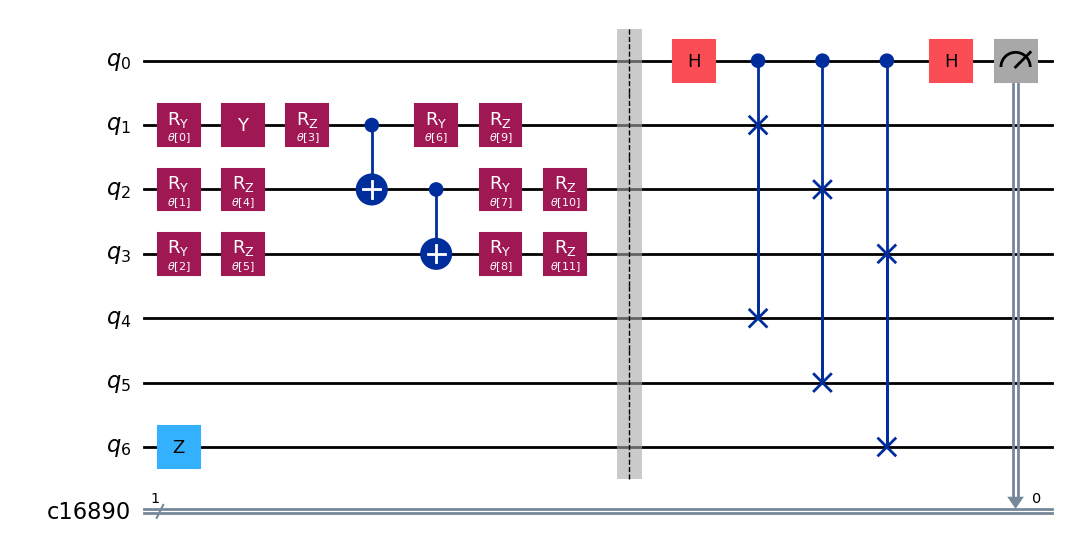

In [136]:
gradient_overlap_term_circuit[0].draw('mpl', style='iqx')

In [92]:
super_circuit[1][0].operation.name

'rz'

In [153]:
runningVQD.run_VQD()

[0.27439011 0.68032529] ---------
24.287
[-0.62023686  1.0485886 ] ---------
22.173
[-0.10830951  1.03973062] ---------
23.586
[-0.10827657  1.33579221] ---------
24.481
[0.27863059 0.72209873] ---------
24.283
[1.19272865 1.05814753] ---------
26.319
[1.56401356 1.30093862] ---------
25.185999999999996
[1.81873912 1.20302862] ---------
26.458
[1.47445825 1.29080135] ---------
24.987000000000002
[1.41401533 1.31917801] ---------
24.907999999999998
[1.69252568 1.00904063] ---------
26.340999999999998
[1.40719432 0.7881511 ] ---------
26.697999999999993
[1.32716501 0.32626404] ---------
27.191
[1.30456068 0.3782205 ] ---------
26.836
[0.81187932 0.89725253] ---------
25.735000000000007
[0.85353197 0.8725307 ] ---------
25.632
[0.47992642 0.53680767] ---------
24.68
[0.18492449 0.75144537] ---------
23.942
[0.46045899 0.95808344] ---------
24.561
[0.6830158  1.48113817] ---------
23.799999999999997
[0.87073732 1.00140886] ---------
24.579
[0.836495   0.86619651] ---------
25.242
[1.043683

In [3]:
from qiskit.algorithms import NumPyEigensolver

# hamiltonian = PauliSumOp(SparsePauliOp(['X'],
#               coeffs=[-20]), coeff=1.0)

hamiltonian = PauliSumOp(SparsePauliOp(['Z','X'],
              coeffs=[10, -20]), coeff=1.0)

# find the first three (k=3) eigenvalues
exact_solver = NumPyEigensolver(k=16)
exact_result = exact_solver.compute_eigenvalues(hamiltonian)
print(exact_result.eigenvalues.real)

NameError: name 'PauliSumOp' is not defined

In [ ]:
from qiskit.algorithms import NumPyEigensolver


# find the first three (k=3) eigenvalues
exact_solver = NumPyEigensolver(k=16)
exact_result = exact_solver.compute_eigenvalues(hamiltonian)
print(exact_result.eigenvalues.real)

In [ ]:
VQE_runtime

[5.58544921875,
 1.7734375,
 -5.35791015625,
 -0.85546875,
 2.068359375,
 -5.482421875,
 -1.99267578125,
 5.2607421875,
 1.00146484375,
 -3.5029296875,
 5.708984375,
 3.4697265625,
 -5.9365234375,
 -5.21728515625,
 -0.9873046875,
 1.4970703125,
 -4.23974609375,
 4.10009765625,
 -4.91259765625,
 5.7333984375,
 3.54248046875,
 -5.76904296875,
 -4.0283203125,
 4.76416015625,
 -1.85546875,
 4.58447265625,
 -3.21875,
 5.9296875,
 5.5029296875,
 2.171875,
 -5.95556640625,
 -5.11328125,
 3.8076171875,
 -5.30419921875,
 1.08544921875,
 -2.84033203125,
 -3.44140625,
 5.6708984375,
 3.01806640625,
 -2.97705078125,
 -0.17822265625,
 1.71435546875,
 -5.99609375,
 -5.90234375,
 2.4326171875,
 1.3935546875,
 -4.126953125,
 3.90087890625,
 -5.1298828125,
 -3.02734375,
 5.998046875,
 5.95556640625,
 -2.8466796875,
 5.97216796875,
 5.75048828125,
 -1.26171875,
 3.28662109375,
 5.2470703125,
 0.12353515625,
 -4.091796875,
 -5.748046875,
 -3.98583984375,
 5.08447265625,
 3.62646484375,
 5.69091796875,
 3

In [ ]:
data1 = [0.44244900000000004, 0.38654399999999994, 0.5592809999999999, 0.5740649999999998, 0.581166, 0.593184, -0.600714, -0.611118, -0.6791099999999999, -0.6782579999999999, -0.6711239999999998, -0.6588179999999999, -0.6564629999999999, -0.6558239999999997, -0.6808319999999999, -0.678207, -0.6725730000000001, -0.6763559999999998, -0.6725579999999998, -0.67416, -0.6488339999999999, -0.6453119999999999, -0.6515340000000001, -0.648717, -0.6597329999999999, -0.667944, -0.6613109999999999, -0.6439920000000001, -0.628863, -0.598962, -0.577305, -0.583641, -0.5820869999999998, -0.5848649999999999, -0.5650229999999999, -0.613941, -0.5966999999999999, -0.6110550000000001, -0.6582299999999999, -0.6623669999999999, -0.6587969999999999, -0.6672899999999999, -0.664533, -0.650163, -0.6548609999999999, -0.6615330000000001, -0.6592289999999998, -0.6584099999999999, -0.661392, -0.6525089999999999, -0.66258, -0.6567989999999999, -0.646398, -0.6476219999999999, -0.6432989999999998, -0.640671, -0.6306990000000001, -0.6342509999999999, -0.6340889999999999, -0.5807519999999998, -0.589398, -0.5997510000000001, -0.5885999999999999, -0.5923709999999999, -0.5806290000000001, -0.5896110000000001, -0.6039660000000001, -0.593418, -0.5900549999999999, -0.582492, -0.5966159999999998, -0.625284, -0.637149, -0.6334439999999999, -0.640701, -0.642015, -0.6297479999999998, -0.636255, -0.6502379999999999, -0.653367, -0.6593279999999998, -0.6474629999999999, -0.672411, -0.676845, -0.6797249999999998, -0.679665, -0.669432, -0.465279, -0.498927, -0.44302800000000003, -0.4807620000000001, -0.313458, -0.5918309999999999, -0.622104, -0.6335159999999999, -0.6210209999999999, -0.637575, -0.6249419999999999, -0.6146940000000001, -0.6011849999999999, -0.5939819999999999, -0.6010199999999999, -0.5891129999999998, -0.6432959999999999, -0.6407129999999999, -0.654153, -0.659094, -0.667581, -0.680082, -0.683745, -0.6832050000000001, -0.678465, -0.675162, -0.6520380000000001, -0.684015, -0.6784379999999999, -0.6828179999999998, -0.6816869999999999, -0.682653, -0.6827099999999998, -0.682338, -0.682623, -0.6812699999999999, -0.683238, -0.68409, -0.6811109999999999, -0.684363, -0.68352, -0.682119, -0.6843239999999999, -0.683538, -0.6849929999999999, -0.6801149999999999, -0.678279, -0.6751949999999999, -0.6762299999999999, -0.6759900000000001, -0.684318, -0.680307, -0.6789089999999999, -0.6797460000000001, -0.67671, -0.689037, -0.688968, -0.68943, -0.688314, -0.6889649999999999, -0.688728, -0.689274, -0.6883829999999999, -0.6884189999999999, -0.688518, -0.6879149999999999, -0.688344, -0.6881189999999999, -0.6879299999999999, -0.689001, -0.6884819999999999, -0.6889079999999999, -0.6874349999999999, -0.6883019999999999, -0.6878249999999999, -0.687738, -0.688773, -0.687672, -0.6885479999999999, -0.6877409999999998, -0.6870719999999998, -0.391782, -0.39422099999999993, -0.42231299999999994, -0.430773, -0.6880620000000001, -0.6878970000000001, -0.6877919999999998, -0.6870029999999999, -0.6869669999999999, -0.6868409999999999, -0.6761549999999998, -0.673872, -0.6738569999999999, -0.6709049999999999, -0.6667049999999999, -0.6595289999999998, -0.6682139999999999, -0.6587669999999999, -0.6639959999999998, -0.6521459999999999, -0.659751, -0.6602759999999999, -0.656172, -0.6559349999999999, -0.658794, -0.6846239999999999, -0.685824, -0.688011, -0.687549, -0.68571, -0.6891689999999999, -0.6886409999999998]

In [ ]:
data2 = [0.626517, 0.618192, 0.631917, 0.6381749999999999, 0.6320730000000001, 0.6236309999999998, 0.629295, 0.4505189999999999, 0.45108899999999985, 0.42282299999999995, 0.425652, 0.44298299999999996, 0.44070299999999996, 0.376224, 0.41664899999999994, 0.41862900000000003, 0.41395499999999996, 0.429006, 0.4480289999999999, 0.4509930000000001, 0.44619300000000006, 0.44158500000000006, 0.443892, 0.34251599999999993, 0.230874, 0.141018, 0.21005100000000002, 0.25764599999999993, 0.2655449999999999, 0.20548800000000003, 0.20438399999999993, 0.19787399999999997, 0.43926899999999997, 0.4088400000000001, 0.4165439999999999, 0.3751230000000001, 0.39625799999999994, 0.383583, 0.38412899999999994, 0.40152899999999997, 0.4574819999999999, 0.33011999999999997, 0.32724899999999996, 0.30672599999999994, 0.269211, -0.041192999999999994, -0.008511, 0.041697, -0.022418999999999994, 0.12491699999999999, 0.13154099999999996, 0.240807, 0.232137, 0.144276, 0.16655399999999995, -0.016686, -0.00041700000000000027, -0.0042120000000000005, -0.014835, -0.09220799999999998, -0.04988099999999999, -0.10151700000000002, -0.16230899999999998, -0.12588899999999997, -0.09200700000000002, -0.121239, -0.18101399999999998, -0.24327899999999997, -0.17668499999999998, -0.198063, -0.235047, -0.231099, -0.23091899999999996, -0.31312500000000004, -0.33, -0.35164500000000004, -0.336792, -0.278625, -0.250425, -0.19836599999999996, -0.22363800000000003, -0.09077699999999998, 0.08873699999999998, 0.019212, 0.017228999999999998, -0.030515999999999998, -0.058760999999999994, -0.31996499999999994, -0.317736, -0.337548, -0.30537899999999996, -0.28790099999999996, -0.3201209999999999, -0.37077, -0.428616, -0.44360999999999995, -0.4046219999999999, -0.38298899999999997, -0.37234199999999995, -0.39803099999999997]

In [ ]:
data3 = [0.5643029999999999, 0.5600069999999999, 0.572781, 0.516591, 0.420873, 0.404418, 0.40271399999999996, 0.43347299999999994, 0.4549889999999999, 0.45837599999999995, 0.43723800000000007, 0.6896729999999999, 0.6894, 0.690135, 0.6896729999999999, 0.689241, 0.68649, 0.6872400000000001, 0.6872759999999999, 0.6888989999999999, 0.689175, 0.6901679999999999, 0.6896219999999998, 0.654123, 0.6570329999999999, 0.650505, 0.64107, 0.6421889999999998, 0.640356, 0.6393690000000001, 0.6448319999999998, 0.635802, 0.6633359999999998, 0.6656099999999999, 0.6638160000000001, 0.656652, 0.6615959999999999, 0.6653549999999999, 0.667068, 0.6631560000000001, 0.6471899999999999, 0.6495329999999999, 0.6544859999999999, 0.6489389999999999, 0.6374850000000001, 0.6348989999999999, 0.6368130000000001, 0.642582, 0.64467, 0.6540029999999999, 0.6450629999999999, 0.6392789999999998, 0.6435599999999999, 0.646593, 0.5742569999999998, 0.5884769999999999, 0.5853809999999999, 0.5754809999999999, 0.5765549999999999, 0.569532, 0.575925, 0.42244499999999996, 0.6763739999999999, 0.6750509999999998, 0.6776760000000001, 0.6678239999999999, 0.6720959999999998, 0.6692579999999999, 0.687606, 0.6891059999999999, 0.690012, 0.6899279999999999, 0.6898919999999998, 0.6897389999999999, 0.6892589999999998, 0.69, 0.690051, 0.68988, 0.690051, 0.6901019999999999, 0.6902039999999999, 0.689691, 0.690033, 0.690051, 0.68988, 0.690051, 0.68988, 0.690051, 0.68988, 0.6897599999999999, 0.6895709999999999, 0.6897599999999999, 0.689691, 0.6897599999999999, 0.6897239999999999, 0.6897599999999999, 0.6892439999999999, 0.689604, 0.689379, 0.6892589999999998, 0.6882809999999999, 0.689961, 0.690012, 0.689961, 0.69, 0.69, 0.69, 0.69, 0.68988, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.690051, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69]


In [ ]:
data4 = [0.590448, 0.603966, 0.6397649999999999, 0.6408780000000001, 0.649551, 0.6493169999999998, 0.6487590000000001, 0.6534179999999998, 0.640242, 0.685593, 0.6841470000000001, 0.68016, 0.6803699999999998, 0.6843809999999998, 0.681054, 0.6823649999999999, 0.6832079999999999, 0.688173, 0.688788, 0.6871950000000001, 0.688821, 0.6888059999999999, 0.6885150000000001, 0.6870629999999999, 0.6855180000000001, 0.6854549999999999, 0.686754, 0.685848, 0.6857460000000001, 0.6888479999999999, 0.687321, 0.6863819999999999, 0.6892469999999999, 0.6862320000000001, 0.6833579999999999, 0.6849989999999999, 0.6849630000000001, 0.685353, 0.685014, 0.6845519999999999, 0.6880560000000001, 0.6897, 0.688605, 0.6888779999999999, 0.6889469999999999, 0.689286, 0.6407700000000001, 0.4877459999999999, 0.4872389999999999, 0.496743, 0.5419679999999999, 0.566376, 0.5721990000000001, 0.594951, 0.5728889999999999, 0.6204540000000001, 0.6169979999999999, 0.599313, 0.6187860000000001, 0.599397, 0.588078, 0.678072, 0.6750929999999999, 0.6760079999999998, 0.6795420000000001, 0.6829919999999998, 0.68697, 0.6882240000000001, 0.6869910000000001, 0.687726, 0.688887, 0.6874229999999998, 0.6873119999999998, 0.688737, 0.687177, 0.689196, 0.6874649999999998, 0.688428, 0.6881640000000001, 0.196635, 0.200454, 0.186144, 0.23526600000000006, 0.19873800000000003, 0.12320399999999998, -0.19084500000000004, -0.187716, -0.20934, -0.258957, -0.252606, -0.23118, -0.13821299999999997, -0.11767799999999999, -0.11499599999999999, -0.11244299999999999, -0.20259299999999997, -0.198606, -0.17792699999999995, -0.103713, -0.07686299999999997, 0.03072, 0.05920800000000001, -0.0001739999999999988, 0.10083299999999999, 0.093246, 0.072252, 0.316683, 0.291456, 0.37302300000000005, 0.386775, 0.38133, 0.389874, 0.35378099999999996, 0.38222399999999995, 0.6045809999999998, 0.5768880000000001, 0.570804, 0.569841, 0.5570579999999998, 0.5844689999999999, 0.577512, 0.5691569999999999, 0.5906939999999999, 0.599154, 0.5933729999999999, 0.57834, 0.5777969999999999, 0.6278399999999998, 0.6204749999999999, 0.628668, 0.581925, 0.582177, 0.5767739999999999, 0.587127, 0.585702, 0.5878320000000001, 0.568692, 0.431823, 0.432702, 0.4512569999999999, 0.429444, 0.40524599999999994, 0.44657999999999987, 0.4478549999999999, 0.463392, 0.45548999999999995, 0.432015, 0.49159200000000003, 0.479061, 0.478074, 0.490545, 0.49903199999999986, 0.483951, 0.48958199999999996, 0.59562, 0.5928899999999999, 0.5811959999999999, 0.5784419999999999, -0.10387499999999998, -0.140253, -0.20909400000000006, -0.23122799999999996, -0.22174199999999997, -0.25443299999999996, -0.18405599999999997, -0.14582099999999998, -0.14922300000000002, -0.12289799999999998, -0.125703, 0.09569999999999998, 0.10052100000000001, 0.208194, 0.23567699999999997, 0.09694199999999999, 0.11730600000000001, 0.3267599999999999, 0.32568299999999994, 0.2916869999999999, 0.494289, 0.489078, 0.5106359999999999, 0.4848719999999999, 0.512022, 0.499137, 0.522465, 0.4928369999999999, 0.49135200000000007, 0.47938800000000004, 0.48383999999999994, 0.48985799999999985, 0.4940939999999999, 0.49760699999999997, -0.1296, -0.091236, -0.10975500000000002, -0.12022199999999998, -0.212433, -0.234891, -0.23552999999999996, -0.233391, -0.39238799999999996, -0.3838079999999999, -0.36504, -0.3676949999999999, -0.3635519999999999, -0.14271299999999998, -0.11265300000000002, -0.053796, -0.126195, -0.10127699999999998, -0.10877700000000001, -0.08516999999999998, -0.042003, -0.11649899999999998, -0.09888599999999999, -0.019226999999999994, -0.031083000000000003, -0.027048, -0.016070999999999995, -0.116616, -0.07839, -0.017175, -0.016013999999999994, -0.036948, -0.039489, -0.053780999999999995, -0.07995299999999998, -0.12475499999999998, -0.07693799999999998, -0.07877399999999998, -0.308955, -0.3185009999999999, -0.31754099999999996, -0.3242609999999999, -0.369045, -0.3434429999999999, -0.359172, -0.311079, -0.3119489999999999, -0.38324400000000003, -0.39556499999999994, -0.31821900000000003, -0.227241, -0.23651999999999998, -0.276852, 0.518463, 0.312696, 0.34971, 0.34108499999999997, 0.4242239999999999, 0.25936499999999996, 0.258873, 0.24864599999999998, 0.25929599999999997, 0.232263, 0.27505499999999994, 0.32510999999999995, 0.326457, 0.35864999999999997, 0.3447, 0.37536899999999995, 0.40743299999999993, 0.41935799999999995, 0.4109999999999999, 0.41998800000000003, 0.6492239999999998, 0.654309, 0.6565889999999998, 0.670377, 0.66792, 0.668319, 0.659862, 0.6593699999999998, 0.670317, 0.6673769999999999, 0.6657299999999999, 0.665643, 0.6628079999999998, 0.667065, 0.6606479999999999, 0.659211, 0.6565020000000001, 0.677643, 0.6804839999999999, 0.6768959999999998, 0.679575, 0.6815699999999999, 0.680289, 0.681324, 0.676734, 0.6665159999999999, 0.673935, 0.677913, 0.6767399999999999, 0.6764189999999999, 0.6774899999999999, 0.67503, 0.673071, 0.6742469999999998, 0.6756179999999998]


In [ ]:
data = [0.344214, 0.3751139999999999, 0.3615419999999999, 0.355644, 0.330729, 0.3349559999999999, 0.3535709999999999, 0.38076600000000005, 0.375033, 0.35915400000000003, 0.3664499999999999, 0.370683, 0.37343099999999996, 0.3724169999999999, 0.3816179999999999, 0.36023999999999984, 0.373662, 0.379911, 0.38970299999999997, 0.377922, 0.3829769999999999, 0.36866999999999983, 0.40664999999999996, 0.407907, 0.3868559999999999, 0.39506099999999994, 0.373458, 0.3591209999999999, 0.363396, 0.356919, 0.37929599999999997, 0.36658199999999996, 0.3935099999999999, 0.38090399999999996, 0.38043, 0.380022, 0.39420599999999995, 0.387423, 0.3660929999999999, 0.332205, 0.337479, 0.3243359999999999, 0.34702199999999994, 0.35101799999999994, 0.320076, 0.32667899999999994, 0.322086, 0.3227879999999999, 0.20330099999999998, 0.204888, 0.19662, 0.20415599999999995, 0.22703699999999993, 0.183495, 0.18810299999999996, 0.16369199999999995, 0.16308299999999998, 0.181566, 0.172272, 0.17187, 0.19079399999999996, 0.18637199999999998, 0.16501200000000002, 0.167178, 0.17255999999999996, 0.15158999999999995, 0.15271199999999996, 0.156468, 0.106734, 0.08999700000000001, 0.09519299999999999, 0.07672799999999998, 0.062439, 0.06536399999999998, 0.021342000000000003, 0.024300000000000002, 0.007430999999999999, 0.014378999999999996, 0.012594000000000001, 0.027593999999999994, 0.023960999999999996, 0.013248, 0.010622999999999997, 0.016871999999999995, 0.014682, 0.021383999999999997, 0.028536000000000002, 0.012170999999999996, 0.029910000000000006, 0.019334999999999995, 0.005937, 0.016364999999999998, 0.010409999999999999, 0.009624, -0.00816, 0.014127, 0.0029490000000000002, -0.004851, -0.025185, -0.026627999999999995, -0.023274, -0.031217999999999996, -0.016859999999999997, -0.032172, 0.010022999999999999, -0.001797, -0.004793999999999999, -0.019218, -0.006969, -0.010247999999999998, -0.015366000000000001, -0.011061, -0.014739000000000002, -0.005045999999999998, -0.029691, -0.011454, -0.013193999999999999, -0.02343, -0.020930999999999998, -0.011448000000000003, -0.030687, -0.015707999999999993, -0.015495, -0.056756999999999995, -0.057738000000000005, -0.066828, -0.06667199999999998, -0.045822, -0.084243, -0.06818100000000002, -0.096219, -0.08683499999999998, -0.13107599999999997, -0.10763700000000001, -0.10581599999999998, -0.112428, -0.122214, -0.135768, -0.14325, -0.11974199999999999, -0.13606799999999997, -0.139212, -0.16232699999999994, -0.18331799999999998, -0.17237699999999995, -0.16629000000000005, -0.157413, -0.15736500000000003, -0.191481, -0.16139699999999996, -0.166413, -0.17156999999999997, -0.17522099999999993, -0.185553, -0.179484, -0.203682, -0.177618, -0.183582, -0.197631, -0.18943499999999994, -0.202668, -0.19396799999999997, -0.16384500000000002, -0.15539399999999995, -0.17814, -0.18491699999999997, -0.16631100000000001, -0.15630300000000003, -0.18610799999999997, -0.19325999999999996, -0.211014, -0.20863199999999998, -0.18707099999999996, -0.184083, -0.16872299999999998, -0.18770399999999998, -0.19296599999999997, -0.180903, -0.19334699999999996, -0.204708, -0.187659, -0.17201400000000003, -0.185919, -0.20817300000000002, -0.195411, -0.17212200000000002, -0.20721299999999998, -0.18350999999999998, -0.19437899999999997, -0.182877, -0.17824799999999996, -0.20197500000000002, -0.19120199999999998, -0.19962, -0.171072, -0.186732, -0.17838900000000002, -0.19499400000000003, -0.18569100000000002, -0.19443, -0.20406, -0.191298, -0.20119799999999996, -0.18712799999999993, -0.20587499999999997, -0.21396299999999993, -0.212565, -0.17786999999999997, -0.19884600000000002, -0.170862, -0.183558, -0.17965199999999998, -0.18405899999999997, -0.18701099999999996, -0.17994599999999994, -0.206397, -0.20587200000000003, -0.20324099999999998, -0.21444899999999997, -0.20670000000000002, -0.226263, -0.23588699999999996, -0.24000000000000002, -0.22509899999999994, -0.231894, -0.19619399999999998, -0.20444400000000004, -0.20742899999999997, -0.203025, -0.118944, -0.11256599999999999, -0.11720399999999999, -0.11902499999999999, -0.12367800000000001, -0.12669, -0.131601, -0.13035, -0.11594100000000002, -0.11563499999999996, -0.086124, -0.09576299999999997, -0.092625, -0.08500799999999999, -0.07173299999999998, -0.07688099999999999, -0.08710799999999999, -0.047496000000000003, -0.07813499999999998, -0.07885500000000001, -0.06398999999999999, -0.06411299999999999, -0.06648299999999999, -0.063843, -0.072381, -0.06511799999999998, -0.005028000000000001, -0.016634999999999997, -0.006791999999999999, -0.033315, -0.018882, -0.03549599999999999, -0.029108999999999996, -0.038903999999999994, -0.026105999999999997, 0.012693, 8.100000000000013e-05, 0.03488699999999999, 0.034775999999999994, 0.04780500000000001, 0.02759099999999999, 0.050358, 0.048221999999999994, 0.035391000000000006, 0.05275499999999999, 0.06023699999999999, 0.026565, 0.062184, 0.03269099999999999, 0.029274, 0.056586, 0.040604999999999995, 0.035646000000000004, 0.031434, 0.06772199999999999, 0.033024, -0.00012599999999999938, 0.010296, -0.004181999999999999, 0.009111000000000001, 0.011267999999999999, 0.012431999999999999, 0.017873999999999998, -0.0004920000000000002, 0.001691999999999999, 0.044303999999999996, 0.038643, 0.048341999999999996, 0.07561499999999999, 0.06919799999999998, 0.07414499999999999, 0.066075, 0.09406499999999998, 0.075129, 0.07596599999999999, 0.08393699999999998, 0.06930899999999998, 0.07269599999999998, 0.05508600000000001, 0.03591599999999999, 0.07666200000000001, 0.06600600000000001, 0.067704, 0.08605199999999998, 0.086043, 0.085119, 0.08589899999999999, 0.033606, 0.024746999999999998, 0.013742999999999998, 0.021945, 0.012509999999999997, 0.029223000000000006, 0.031973999999999995, 0.041427, 0.033831, 0.039036, 0.013982999999999995, 0.024249, 0.07780199999999998, 0.07897199999999999, 0.09477, 0.08516099999999999, 0.08550899999999999, 0.10400100000000001, 0.09800999999999999, 0.095934, 0.14473799999999998, 0.13238999999999998, 0.134856, 0.151251, 0.163182, 0.15009599999999995, 0.153264, 0.14354699999999998, 0.12438900000000001, 0.141507, 0.14950499999999997, 0.149949, 0.15286800000000003, 0.148032, 0.130062, 0.146454, 0.143733, 0.14816100000000001, 0.108474, 0.13343699999999997, 0.11793900000000003, 0.11637599999999998, 0.10031099999999997, 0.11227800000000003, 0.11367899999999999, 0.131883, 0.128166, 0.115884, 0.11117099999999998, 0.11027099999999998, 0.137982, 0.11573099999999999, 0.10891799999999997, 0.152292, 0.12147, 0.140127, 0.126597, 0.133152, 0.12164699999999999, 0.13935299999999998, 0.13114799999999996, 0.14676299999999998, 0.14556599999999997, 0.16236, 0.14331599999999997, 0.157959, 0.15343799999999996, 0.19264199999999995, 0.20057999999999998, 0.195564, 0.19560900000000003, 0.21004499999999998, 0.195459, 0.186912, 0.19269899999999995, 0.188676, 0.17642400000000003, 0.16366199999999997, 0.16208699999999998, 0.165456, 0.170904, 0.190347, 0.20691899999999996, 0.182838, 0.19745999999999994, 0.19703700000000002, 0.18079799999999996, 0.17912699999999998, 0.19361099999999995, 0.17936999999999997, 0.202632, 0.18834899999999993, 0.18758699999999998, 0.182421, 0.195657, 0.19446, 0.21080999999999997, 0.22388999999999995, 0.22223399999999996, 0.25087799999999993, 0.24652199999999996, 0.25293299999999996, 0.27460799999999996, 0.24758099999999997, 0.25536000000000003, 0.24377400000000002, 0.25250100000000003, 0.2551589999999999, 0.23769600000000002, 0.25730699999999995, 0.25514100000000006, 0.26882399999999995, 0.257814, 0.26055900000000004, 0.26898, 0.25533300000000003, 0.25787400000000005, 0.270057, 0.273099, 0.220233, 0.23588099999999995, 0.23199899999999996, 0.23249399999999998, 0.17195399999999997, 0.17787000000000003, 0.17083499999999996, 0.169008, 0.15205500000000002, 0.13075799999999999, 0.13951199999999997, 0.16037099999999999, 0.158661, 0.16025399999999998, 0.15077999999999997, 0.165624, 0.17026499999999997, 0.16199699999999995, 0.16254000000000002, 0.121425, 0.128652, 0.103335, 0.10632299999999999, 0.10257599999999997, 0.09174299999999999, 0.12125699999999999, 0.08599199999999999, 0.11569199999999999, 0.06578999999999999, 0.06956399999999999, 0.056768999999999986, 0.04561499999999999, 0.03865799999999999, 0.05082599999999998, 0.049293000000000003, 0.05086799999999999, 0.021807, 0.011361, 0.039114, 0.03604199999999999, 0.039722999999999994, 0.038241, 0.024260999999999998, 0.015725999999999997, 0.021174, 0.044403, 0.022146, 0.028044, 0.01629, 0.017964, 0.028652999999999998, 0.082032, 0.07373099999999999, 0.06429599999999999, 0.042776999999999996, 0.045222, 0.03767999999999999, 0.05410499999999999, -0.026744999999999998, -0.036171, -0.06608999999999998, -0.06287699999999999, -0.068337, -0.043374, -0.036599999999999994, -0.010256999999999999, -0.0011429999999999982, -0.009906000000000002, -0.022670999999999997, -0.010818, -0.028572, -0.015207, -0.027525, -0.024675, -0.14455799999999996, -0.14023199999999997, -0.128523, -0.12741000000000002, -0.11264400000000001, -0.10661399999999999, -0.12129899999999999, -0.12746699999999997, -0.10125300000000001, -0.10851900000000002, -0.13251, -0.135756, -0.11913, -0.12960900000000003, -0.13694999999999996, -0.134706, -0.13023599999999996, -0.11628899999999999, -0.12062999999999999, -0.11033100000000001, -0.11560499999999999, -0.11414100000000002, -0.12712199999999999, -0.13721699999999998, -0.123246, -0.105111, -0.11623799999999998, -0.10169099999999999, -0.247158, -0.23209199999999996, -0.240909, -0.24689699999999995, -0.25601399999999996, -0.248601, -0.2345939999999999, -0.24210299999999998, -0.241971, -0.237312, -0.253506, -0.240921, -0.242613, -0.23875799999999994, -0.254691, -0.23338499999999995, -0.23865000000000003, -0.24945, -0.243234, -0.252204, -0.254721, -0.24352799999999997, -0.24617999999999995, -0.23553299999999996, -0.242604, -0.25176, -0.23613299999999995, -0.24081299999999997, -0.242499, -0.21485700000000002, -0.348654, -0.346437, -0.33313499999999996, -0.33904199999999995, -0.33388500000000004, -0.33823499999999995, -0.335823, -0.33266399999999996, -0.28864500000000004, -0.271068, -0.27469199999999994, -0.28733699999999995, -0.266127, -0.27263699999999996, -0.259791, -0.266424, -0.310104, -0.300348, -0.30086999999999997, -0.30223500000000003, -0.3003239999999999, -0.325773, -0.32484899999999994, -0.3153659999999999, -0.33667800000000003, -0.343242, -0.33802800000000005, -0.330777, -0.33554100000000003, -0.340986, -0.337635, -0.337263, -0.34393499999999994, -0.32881499999999997, -0.31706399999999996, -0.315087, -0.33309300000000003, -0.30011099999999996, -0.320847, -0.31307999999999997, -0.32658599999999993, -0.310245, -0.315516, -0.2922779999999999, -0.284451, -0.273375, -0.29154899999999995, -0.30144899999999997, -0.28790099999999996, -0.29143499999999994, -0.2995619999999999, -0.3049740000000001, -0.32173500000000005, -0.3354959999999999, -0.388407, -0.38411400000000007, -0.38692800000000005, -0.38525399999999993, -0.366057, -0.35539199999999993, -0.37103699999999995, -0.3581909999999999, -0.38634899999999994, -0.4023689999999999, -0.3871649999999999, -0.380898, -0.365112, -0.38244, -0.37813800000000003, -0.3549, -0.386787, -0.3663269999999999, -0.37803299999999995, -0.38146800000000003, -0.39152099999999995, -0.385137, -0.410757, -0.3672, -0.28588199999999997, -0.311511, -0.2938679999999999, -0.304182, -0.300168, -0.3139139999999999, -0.29943299999999995, -0.28771499999999994, -0.270003, -0.258729, -0.27946499999999996, -0.29413799999999996, -0.269721, -0.265338, -0.273696, -0.28028999999999993, -0.266664, -0.274323, -0.267825, -0.252822, -0.268926, -0.27378, -0.263823, -0.27853799999999995, -0.314685, -0.32025899999999996, -0.334296, -0.31575, -0.32139299999999993, -0.33266999999999997, -0.34664999999999996, -0.34146, -0.34018799999999993, -0.33504899999999993, -0.332082, -0.348954, -0.3349349999999999, -0.32651399999999997, -0.33980699999999997, -0.3428789999999999, -0.3474239999999999, -0.35605799999999993, -0.369759, -0.35060699999999995, -0.3102539999999999, -0.370965, -0.34984199999999993, -0.34720500000000004, -0.3647729999999999, -0.4443659999999999, -0.4533330000000001, -0.46058400000000005, -0.440304, -0.43377899999999997, -0.42896399999999996, -0.4333619999999999, -0.5326589999999998, -0.5376299999999998, -0.5745869999999998, -0.5862149999999999, -0.581172, -0.5883719999999998, -0.581958, -0.5799209999999999, -0.5832899999999999, -0.5785049999999998, -0.583968, -0.5785199999999999, -0.5827800000000001, -0.5721479999999999, -0.5817629999999999, -0.5771249999999999, -0.5786819999999999, -0.5704259999999999, -0.578295, -0.5733929999999998, -0.5773379999999999, -0.5708579999999999, -0.5713950000000001, -0.5698349999999999, -0.5674259999999999, -0.567912, -0.5804309999999999, -0.5753309999999999, -0.563523, -0.5704019999999999, -0.5717249999999998, -0.581307, -0.575856, -0.5817060000000001, -0.577227, -0.566892, -0.582345, -0.575406, -0.5726279999999999, -0.5717189999999999, -0.574125, -0.566697, -0.5762189999999999, -0.5760749999999999, -0.566427, -0.603267, -0.608094, -0.604896, -0.599487, -0.5998139999999998, -0.6022589999999999, -0.6066539999999998, -0.6075539999999998, -0.606822, -0.6031799999999998, -0.6010709999999999, -0.608733, -0.6052439999999999, -0.608724, -0.6064350000000001, -0.6081479999999999, -0.6106199999999999, -0.6074579999999999, -0.593709, -0.5922959999999999, -0.6054899999999999, -0.588549, -0.5868179999999998, -0.5947829999999998, -0.6010409999999999, -0.6002639999999999, -0.59697, -0.5943539999999998, -0.595092, -0.5916029999999999, -0.599013, -0.6004109999999998, -0.600258, -0.5392889999999999, -0.5346150000000001, -0.547491, -0.5229630000000001, -0.5337510000000001, -0.5481569999999999, -0.5445089999999999, -0.5468459999999999, -0.5289869999999999, -0.544287, -0.546078, -0.5539589999999999, -0.544218, -0.5486909999999998, -0.5556059999999999, -0.5419829999999999, -0.5461019999999999, -0.5456429999999999, -0.5556510000000001, -0.5589959999999998, -0.549276, -0.5511569999999999, -0.538326, -0.540384, -0.534417, -0.5416829999999999, -0.545925, -0.5426759999999999, -0.5425679999999999, -0.5370779999999999, -0.548118, -0.540468, -0.5475869999999998, -0.5606399999999998, -0.5584499999999999, -0.5543909999999999, -0.5578319999999999, -0.543957, -0.527961, -0.5402459999999999, -0.534588, -0.535089, -0.538953, -0.5344979999999999, -0.5522009999999999, -0.5388930000000001, -0.532044, -0.536124, -0.543696, -0.5349269999999999, -0.541716, -0.557322, -0.5532569999999999, -0.563781, -0.5497679999999999, -0.551571, -0.5546369999999999, -0.551979, -0.5505359999999999, -0.5463479999999998, -0.5499779999999999, -0.547239, -0.5547839999999999, -0.57456, -0.5663999999999999, -0.5648639999999999, -0.572751, -0.5836319999999999, -0.572904, -0.5720879999999999, -0.5928389999999999, -0.59181, -0.5832930000000001, -0.574071, -0.5786820000000001, -0.56727, -0.5793630000000001, -0.5703, -0.575796, -0.589347, -0.573249, -0.41129399999999994, -0.4108199999999999, -0.4172549999999999, -0.41495399999999993, -0.42141899999999993, -0.403221, -0.42265499999999995, -0.4196909999999999, -0.4180529999999999, -0.4189109999999999, -0.41362200000000005, -0.42271800000000004, -0.40774499999999997, -0.41103899999999993, -0.4135649999999999, -0.408066, -0.431208, -0.43573799999999996, -0.45355500000000004, -0.424944, -0.433707, -0.43887299999999996, -0.42993899999999996, -0.43577699999999997, -0.4291979999999999, -0.422925, -0.494769, -0.47482799999999986, -0.473271, -0.46997699999999987, -0.465762, -0.49316999999999994, -0.47904, -0.457332, -0.44952599999999987, -0.45490799999999987, -0.4571549999999999, -0.45392699999999997, -0.454989, -0.4565459999999999, -0.44992499999999996, -0.444483, -0.45912899999999995, -0.46479300000000007, -0.450363, -0.468585, -0.4774769999999999, -0.4531259999999999, -0.481632, -0.48312000000000005, -0.470001, -0.481236, -0.48864, -0.472293, -0.48914099999999994, -0.48230699999999993, -0.46574699999999997, -0.4735019999999999, -0.476247, -0.472728, -0.47085, -0.48030599999999984, -0.463155, -0.464892, -0.4649999999999999, -0.46134, -0.46867200000000003, -0.47739899999999996, -0.472365, -0.47547599999999995, -0.46220400000000006, -0.4798140000000001, -0.467268, -0.47389499999999996, -0.45907799999999993, -0.4571309999999999, -0.450366, -0.46028999999999987, -0.446784, -0.365952, -0.36807300000000004, -0.39360600000000007, -0.37989599999999996, -0.39536999999999994, -0.3690900000000001, -0.390264, -0.38837999999999995, -0.37923599999999996, -0.366462, -0.35745899999999986, -0.37895400000000007, -0.375327, -0.382878, -0.38497499999999996, -0.37953600000000004, -0.382611, -0.384381, -0.37075500000000006, -0.36520800000000003, -0.38022, -0.36559200000000003, -0.3788369999999999, -0.33080400000000004, -0.340209, -0.31976400000000005, -0.327036, -0.32971799999999996, -0.317214, -0.31815299999999996, -0.30477299999999996, -0.306852, -0.3318749999999999, -0.327966, -0.311106, -0.369198, -0.371991, -0.36825299999999994, -0.379443, -0.37240799999999996, -0.3797850000000001, -0.379884, -0.38760599999999995, -0.3731969999999999, -0.37484999999999996, -0.370842, -0.373449, -0.38459099999999985, -0.37988999999999995, -0.3847109999999999, -0.376542, -0.3699059999999999, -0.387126, -0.366693, -0.35950199999999993, -0.3699179999999999, -0.35601599999999994, -0.38368800000000003, -0.38897999999999994, -0.3875819999999999, -0.38597999999999993]

In [ ]:
data5 = [0.49091699999999994, 0.49344, 0.47452799999999995, 0.4650539999999999, 0.46474200000000004, 0.441309, 0.427629, 0.4418849999999999, 0.44310299999999997, 0.40850100000000006, 0.430092, 0.445323, 0.44245500000000004, 0.419139, 0.425508, 0.6422849999999999, 0.6427080000000001, 0.639921, 0.640773, 0.634293, 0.640131, 0.639726, 0.640434, 0.6531989999999999, 0.653184, 0.6508229999999999, 0.6514589999999998, 0.647403, 0.6542069999999999, 0.6563579999999998, 0.6483840000000001, 0.653073, 0.652782, 0.648876, 0.6475439999999999, 0.6506519999999998, 0.652914, 0.6504030000000001, 0.6425639999999999, 0.6482789999999998, 0.6473819999999999, 0.6469739999999999, 0.61785, 0.6192899999999998, 0.6281220000000001, 0.613962, 0.6054390000000001, 0.613377, 0.60759, 0.6120209999999999, 0.5933399999999999, 0.583038, 0.600849, 0.40708799999999995, 0.41847, 0.39702000000000004, 0.4281479999999999, 0.533328, 0.575865, 0.5839110000000001, 0.593847, 0.6092699999999998, 0.6135299999999999, 0.6210060000000002, 0.48625499999999994, 0.5218529999999999, 0.52101, 0.5669489999999999, 0.5438580000000001, 0.51396, 0.44950499999999993, 0.39149699999999993, 0.40784999999999993, -0.09974699999999997, -0.09270299999999998, -0.086535, -0.06142499999999999, -0.08923500000000001, -0.166632, -0.18725999999999998, -0.17677799999999996, -0.13929, -0.19694399999999998, -0.282096, -0.32183399999999995, -0.31658699999999995, 0.21795, 0.208119, 0.24762599999999996, 0.243396, 0.5269499999999999, 0.488409, 0.509814, 0.46716899999999995, 0.436239, 0.431679, 0.425409, 0.531495, 0.5267099999999998, 0.5687309999999999, 0.5105250000000001, 0.5054399999999999, 0.511551, 0.4162349999999999, 0.43796699999999994, 0.49246799999999996, 0.47002499999999997, 0.472026, 0.5544089999999999, 0.535728, 0.5150669999999999, 0.4761929999999999, 0.5372159999999999, 0.526851, 0.542247, 0.5649899999999999, 0.5637179999999999, 0.5681069999999999, 0.569043, 0.599331, 0.5846580000000001, 0.5841059999999999, 0.581199, 0.5699399999999999, 0.575418, 0.5600459999999999, 0.5662589999999998, 0.514605, 0.5226239999999999, 0.4932839999999999, 0.503118, 0.497901, 0.4814669999999999, 0.49034999999999995, 0.4776029999999999, 0.47543399999999997, 0.5213549999999999, 0.4626450000000001, 0.457809, 0.44294999999999995, 0.41916, 0.43238099999999996, 0.437727, 0.428817, 0.42805799999999994, 0.408732, 0.170301, 0.18742499999999992, 0.18733799999999998, 0.20939400000000002, 0.18648599999999999, 0.179268, 0.19970999999999997, 0.22990500000000003, 0.28452, 0.5446979999999999, 0.5527470000000001, -0.5234789999999999, -0.536724, -0.5250689999999998, -0.5389709999999999, -0.537693, -0.5112000000000001, -0.5320319999999998, -0.54321, -0.5259479999999999, -0.502821, -0.5200919999999999, -0.5255159999999999, -0.536082, -0.5821529999999999, -0.5724149999999999, -0.548637, -0.528816, -0.528195, -0.5459099999999999, -0.5244359999999999, -0.52017, -0.5198669999999999, -0.4824989999999999, 0.476211, 0.44722799999999996, 0.488835, 0.45594000000000007, 0.455304, 0.42291000000000006, 0.44919299999999995, 0.49214699999999995, 0.4988069999999999, 0.599037, 0.6210929999999998, 0.6153899999999999, 0.6111389999999999, 0.617175, 0.609996, 0.6154650000000002, 0.615381, 0.6119489999999999, 0.6183119999999998, 0.613953]

In [ ]:
data6 = [0.29768399999999995, 0.29626199999999997, 0.025194000000000005, -0.025505999999999994, 0.17388599999999999, 0.16688699999999995, 0.148167, 0.12666299999999997, 0.169446, 0.173187, 0.139866, 0.10766099999999997, 0.11419499999999999, 0.12594, 0.102855, 0.132291, 0.12312899999999999, 0.12338099999999999, 0.11853899999999999, -0.043496999999999994, -0.014706, -0.020180999999999998, -0.012915, -0.0025229999999999996, 0.0025770000000000003, -0.0029100000000000003, 0.011303999999999998, 0.038118, 0.20585099999999992, 0.197871, 0.20260799999999998, 0.20119799999999993, 0.200958, 0.140445, 0.145779, 0.13493699999999997, 0.176172, 0.16594499999999995, 0.16399199999999997, 0.167754, 0.145752, 0.158379, 0.16974899999999998, 0.169812, 0.168609, 0.16707, 0.17734499999999997, 0.149439, 0.15376199999999995, 0.15534299999999998, 0.13493099999999997, 0.151344, 0.15915300000000002, 0.16022999999999996, 0.16770899999999997, 0.170679, 0.18201299999999995, 0.18568199999999999, 0.195909, 0.18779699999999996, 0.178101, 0.17696699999999999, 0.175593, 0.191142, 0.196929, 0.18858899999999995, 0.195135, 0.162096, 0.17708100000000002, 0.16918499999999997, 0.04159499999999999, 0.026561999999999995, 0.060794999999999995, 0.07075199999999998, 0.079587, 0.069882, 0.09796799999999999, 0.11615999999999999, 0.10763099999999999, 0.11467499999999999, 0.11939399999999999, 0.124449, 0.14626199999999995, 0.14647499999999997, 0.08672399999999998, 0.07668299999999999, 0.056010000000000004, 0.071673, 0.05454, 0.045501, 0.051486, 0.033873, 0.07606199999999999, 0.06209399999999999, 0.054666, 0.054645, 0.06036599999999999, 0.0597, 0.042864, -0.04394099999999999, -0.05395199999999999, -0.08259299999999999, -0.10415099999999998, -0.08450999999999999, -0.09151799999999999, -0.048264, -0.056271, -0.05468100000000001, -0.065421, -0.04237499999999999, -0.015438, 0.002373, 0.007730999999999998, 0.002402999999999999, 0.018282, 0.216579, 0.22811099999999998, 0.23813699999999996, 0.23102099999999998, 0.230841, 0.23291999999999996, 0.23154599999999997, 0.26838000000000006, 0.24441, 0.259575, 0.21831599999999995, 0.216441, 0.16061999999999996, 0.16337700000000002, 0.17350200000000002, 0.16602599999999998, 0.167193, 0.19332299999999997, 0.24251099999999998, 0.25165499999999996, 0.222606, 0.22947, 0.20666399999999996, 0.175455, 0.17940299999999998, 0.15805799999999998, 0.257997, 0.262752, 0.23265, 0.26718299999999995, 0.24609599999999995, 0.24144899999999997, 0.25583700000000004, 0.25442099999999995, 0.273111, 0.26604, 0.24487499999999998, 0.25204799999999994, 0.22964099999999998, 0.193941, 0.17378699999999997, 0.18531299999999998, 0.050199, 0.05612999999999999, 0.11238900000000002, 0.09356700000000001, 0.102504, 0.078684, 0.09730799999999998, 0.106302, 0.096231, 0.10842000000000002, 0.10550999999999996, 0.09311699999999999, 0.104223, 0.07696499999999999, 0.08286900000000001, 0.091137, 0.082866, 0.08061299999999998, 0.090033, 0.07710299999999999, 0.074379, -0.080652, -0.06988799999999999, -0.06806699999999999, -0.047532000000000005, -0.057756, -0.057435, -0.043164, -0.048494999999999996, -0.025713, -0.020745, -0.027848999999999995, -0.040212, -0.261582, -0.23550899999999994, -0.230904, -0.24762299999999993, -0.25068, -0.24353699999999998, -0.226845, -0.204141, -0.20926499999999998, -0.20952299999999996]

In [ ]:
data7 = [0.309693, 0.288471, 0.26157300000000006, 0.35198100000000004, 0.34329899999999997, 0.34320000000000006, 0.325917, 0.320673, 0.326856, 0.31144499999999997, -0.23593799999999998, -0.26024400000000003, -0.28152, -0.303147, -0.29924400000000007, -0.3743699999999999, -0.3944789999999999, -0.3668669999999999, -0.36371699999999996, -0.403599, -0.3992519999999999, -0.39970799999999995, -0.4008569999999999, -0.40118699999999996, -0.3521249999999999, -0.36114300000000005, -0.34637999999999997, -0.37554599999999994, -0.36078299999999996, -0.342813, -0.3298110000000001, -0.31037099999999995, -0.3107789999999999, -0.280641, -0.28670699999999993, -0.2852969999999999, -0.28328699999999996, -0.287157, -0.199554, -0.182439, -0.193581, -0.15378599999999995, -0.11179499999999999, -0.09705899999999999, -0.14473200000000003, -0.110649, 0.3587369999999999, 0.339393, 0.34716299999999994, 0.35735100000000003, 0.34399199999999996, 0.33615, 0.3117899999999999, 0.33110400000000006, 0.3118709999999999, 0.318816, 0.35513100000000003, 0.28280099999999997, 0.264714, 0.229716, 0.24797100000000002, 0.25199400000000005, 0.22802099999999997, 0.3141299999999999, 0.311478, 0.326145, 0.33277500000000004, 0.334827, 0.35761800000000005, 0.339549, 0.32997299999999996, 0.257694, 0.22939500000000004, 0.20922, 0.215265, 0.210591, 0.22685099999999997, -0.21617999999999998, -0.28699199999999997, -0.13641299999999998, -0.17247900000000002, -0.24770399999999995, 0.269988, -0.102774, -0.10897800000000002, -0.09782100000000002, -0.09769199999999999, -0.06139200000000001, -0.05609399999999999, -0.07316099999999998, -0.07758599999999999, -0.11136599999999999, -0.13621799999999998, -0.15152999999999997, -0.193329, -0.27306600000000003, -0.23423999999999998, -0.22480199999999997, -0.13061699999999998, -0.13352999999999998, -0.077592, -0.06232200000000001, -0.08289599999999998, -0.05043600000000001, -0.010167, -0.043977, -0.07089899999999999, -0.072615, -0.049101000000000006, -0.013059, 0.011852999999999999, 0.28945199999999993, 0.302625, 0.25571099999999997, 0.28021199999999996, -0.4194299999999999, -0.403275, -0.39157200000000003, -0.398847, -0.39212399999999986, -0.42030000000000006, -0.408702, -0.4033739999999999, -0.396045, -0.397635, -0.42181499999999994, -0.38481299999999996, -0.37743000000000004, -0.3919499999999999, -0.38668499999999983, -0.36351, -0.32994, -0.29080799999999996, -0.292188, -0.24907200000000004, -0.27646499999999996, -0.22781999999999994, -0.23780399999999996, -0.235671, -0.242151, -0.22266300000000003, -0.177969, -0.214737, -0.171399, -0.07123499999999999, -0.062352, -0.116463, -0.11818199999999998, -0.12623099999999998, -0.13776, -0.23482499999999998, -0.2504759999999999, -0.28939799999999993, -0.289539, -0.27222899999999994, -0.247287, -0.24037199999999995, -0.233742, -0.14848499999999998, -0.094131, -0.115434, -0.04706099999999999, 0.023919000000000003, -0.15227099999999996, -0.16590299999999997, -0.15324599999999997, -0.112341, -0.008198999999999996, -0.028266, -0.15116399999999997, -0.16042799999999996, -0.13812, -0.174987, -0.301221, -0.3068129999999999, -0.29795399999999994, -0.28798499999999994, -0.26769299999999996, -0.2776949999999999, -0.4088669999999999, -0.39885, -0.3857849999999999, -0.41921699999999995, -0.25366199999999994, -0.27775799999999995, -0.27344999999999997, -0.18582899999999997, -0.18656399999999995, -0.16122299999999995, -0.16172699999999995, -0.188748, -0.168378, -0.18773700000000001, -0.211929, -0.21913799999999997, -0.209595, 0.302952, 0.28467, 0.310875, 0.249381, 0.2598809999999999, 0.261918, 0.055593, 0.095808, 0.170151, 0.10979399999999999, -0.07036199999999998, -0.08362799999999998, -0.073617, -0.044918999999999994, -0.19486199999999998, -0.003731999999999999, 0.0008909999999999999, 0.001053, 0.01760999999999999, 0.050031000000000006, 0.207513, 0.181569, 0.188757, -0.38246699999999995, -0.3850499999999999, -0.38621099999999997, -0.348858, -0.307071, -0.25600199999999995, -0.24291000000000004, -0.20663400000000004, -0.210888, -0.254142, -0.291324, -0.2985749999999999, -0.298956, -0.22603199999999996, -0.24395699999999998, -0.21212699999999998, -0.11015399999999999, -0.18857099999999996, -0.164703, -0.20223, -0.15780899999999998, -0.030920999999999994, -0.08652299999999999, -0.004211999999999999, -0.0003270000000000009, -0.026591999999999994, -0.08666100000000002, -0.076173, 0.267348, 0.188061, 0.176532, 0.16750499999999996, 0.129627, 0.12149100000000002, 0.14207699999999995, 0.13020900000000002, 0.136119, 0.07964099999999999, 0.048896999999999996, 0.039104999999999994, 0.032649, 0.03340799999999999, 0.024669, 0.035199, 0.04875900000000001, 0.009081, -0.027411, -0.005783999999999999, -0.005523, -0.024492, 0.007317, -0.028842000000000003, -0.05789400000000001, 0.10355099999999999, 0.12214199999999999, 0.18217799999999998, 0.19153799999999999, 0.331098, 0.33756600000000003, 0.31666199999999994, 0.328362, 0.36791099999999993, 0.3562739999999999, 0.35524199999999995, 0.37458600000000003, 0.257019, 0.22693499999999997, 0.24171299999999998, 0.200946, 0.168267, 0.18604800000000002, 0.17329499999999995, -0.081654, 0.08435099999999998, 0.116028, 0.119511, 0.10687199999999998, 0.12458099999999998, 0.11240999999999998, 0.203184, 0.192552, -0.309834, -0.29885699999999993, -0.288234, -0.306072, -0.32134799999999997, -0.329067, -0.29682, -0.312891, -0.459528, -0.46004099999999987, -0.45681599999999994, -0.46015500000000004, -0.4544789999999999, -0.47042999999999996, -0.45434399999999997, -0.459105, -0.46290600000000004, -0.46731000000000006, -0.461211, -0.467844, -0.470802, -0.47396400000000005, -0.46791599999999994, -0.45869699999999997, -0.45936899999999997, -0.470043, -0.44088599999999994, -0.43689899999999987, -0.4520039999999999, -0.436599, -0.42057599999999995, -0.4179239999999999, -0.42616800000000005, -0.43012199999999995, -0.4374629999999999, -0.30210899999999996, -0.30145799999999995, -0.281265, -0.33149399999999996, -0.23444399999999993, -0.223833, -0.25121699999999997, -0.20234999999999997, -0.12833099999999997, 0.015860999999999997, 0.033882, 0.057615, 0.044064, 0.027846000000000003, 0.04710899999999999, 0.05876700000000001, 0.070506, 0.155229, 0.149055, 0.22646699999999997, 0.216768, 0.214956, 0.22319400000000003, 0.26021099999999997, 0.13599, 0.082944, 0.10212900000000001, 0.084678, 0.06425999999999998, 0.16383, 0.129639, 0.10152, 0.18557400000000002, 0.14884200000000003, 0.205176, 0.225393, 0.284319, 0.241764, 0.24356999999999995, 0.2631929999999999, 0.26696099999999995, 0.317589, 0.31988099999999997, 0.30025199999999996, 0.30029399999999995, 0.30315299999999995, 0.280815, 0.313755, 0.17366100000000004, 0.062319, 0.05435400000000001, 0.0010439999999999998, 0.0037139999999999986, 0.004533000000000001, 0.015378, -0.013562999999999999, -0.013896000000000002, -0.05141099999999999, 0.061482, 0.04257599999999999, 0.019596, -0.08948399999999998, -0.06597, -0.07375799999999999, -0.092916, -0.11999099999999999, -0.08822099999999997, -0.13584599999999997, -0.14527500000000002, -0.13703100000000001, -0.19677299999999998, -0.14641499999999996, -0.160683, -0.17340599999999995, -0.18269099999999996, -0.16584, -0.35124599999999995, -0.36702599999999996, -0.34950299999999995, -0.142671, -0.154005, -0.16758899999999996, -0.17719799999999997, -0.157401, -0.153894, 0.057051, 0.130926, 0.21623700000000004, 0.24012899999999995, 0.217227, 0.16158899999999998, 0.14984099999999995, 0.16523699999999997, 0.127146, 0.111942, 0.16422299999999995, 0.12445499999999998, 0.117315, 0.212934, 0.19361699999999996, 0.19195500000000001, 0.257073, 0.270516, 0.286314, 0.318024, 0.33512699999999995, 0.34852799999999995, 0.328017, 0.258432, 0.0048059999999999995, -0.05705700000000001, -0.060285, 0.23074500000000003, 0.19698300000000002, 0.21579599999999993, 0.20962500000000003, 0.17471399999999998, 0.22022699999999998, 0.250578, 0.24335699999999996, 0.259953, 0.29752199999999995, 0.32266200000000006, 0.3172649999999999, 0.183999, 0.200751, 0.19402499999999998, 0.193206, 0.26719199999999993, 0.251865, 0.23313899999999999, 0.260304, 0.262065, -0.35877599999999993, -0.390246, -0.3906359999999999, -0.3855839999999999, -0.3499829999999999, -0.3594509999999999, -0.36727199999999993, -0.266115, -0.258612, -0.183342, -0.19326599999999997, -0.127764, -0.21879900000000002, -0.31191900000000006, -0.321, -0.329634, -0.345735, -0.4011749999999999, -0.41131500000000004, -0.45445199999999997, -0.4051410000000001, -0.39132599999999995, -0.3913830000000001, -0.31950599999999996, -0.325812, -0.17119500000000004, -0.13071899999999997, -0.185853, -0.24432, -0.257169, -0.262053, -0.312882, -0.319221, -0.33553800000000006, -0.33808799999999994, -0.297969, -0.27319799999999994, -0.280671, -0.31010399999999994, -0.33041999999999994, -0.11183400000000002, -0.099312, -0.100392, -0.12652799999999997, -0.04976099999999999, -0.05102999999999998, -0.13577699999999998, -0.13947299999999999, -0.16671000000000002, -0.18100200000000002, -0.155304, -0.17403899999999997, -0.16797600000000001, -0.07964399999999999, -0.07433100000000001, -0.012803999999999996, -0.05528699999999999, -0.07338599999999999, -0.080187, -0.060065999999999994, -0.06019799999999999, -0.05162100000000001, -0.080172, -0.073989, -0.072528, -0.06852599999999999, -0.04692599999999999, 0.045831, 0.07800299999999998, 0.0017429999999999998, 0.028401, -0.062487, -0.043977, -0.030347999999999993, -0.039245999999999996, -0.022596, 0.005255999999999999, -0.004341, -0.006639, -0.009627, -0.00558, -0.10595999999999998, -0.09397799999999999, -0.08781, -0.09941400000000002, -0.10035900000000002, -0.12020399999999998, -0.207222, -0.193332, -0.110886, -0.0032010000000000003, 0.024098999999999995, 0.2960459999999999, 0.301515, 0.35311799999999993, 0.34856699999999996, 0.12979200000000002, 0.143214, 0.575895, 0.569283, 0.5593379999999999, 0.557946, 0.5540489999999999, 0.562575, 0.4313939999999999, 0.31818, 0.323295, 0.23339100000000002, 0.200658, 0.194886, -0.022656000000000003, -0.031515, -0.009713999999999999, 0.030629999999999998, 0.034263, 0.004962000000000001, 0.029592, 0.027561000000000002, 0.032214000000000007, 0.047015999999999995, 0.053055000000000005, 0.06202199999999999, 0.06093, 0.04570499999999999, 0.055040999999999986, 0.05134500000000001, 0.03177300000000001, 0.008523, -0.14571299999999998, -0.18587999999999993, -0.20049, -0.155634, -0.14216399999999996, -0.17477099999999998, 0.4556819999999999, 0.436521, -0.21714000000000003, -0.12598499999999996, -0.10822799999999998, -0.054653999999999994, -0.14421299999999998, -0.035376, 0.017780999999999995, 0.050316, 0.11795699999999998, 0.18498, 0.18952199999999997, 0.06837599999999999, 0.077883, 0.064032, 0.038583, -0.31954799999999994, -0.34352699999999997, -0.32067899999999994, -0.33919499999999997, -0.42571800000000004, -0.486324, -0.471351, 0.32835899999999996, 0.319791, 0.32920199999999994, 0.31935600000000003, 0.31739700000000004, 0.3091529999999999, 0.25777199999999995, 0.207462, -0.18647999999999995, -0.18785399999999997, -0.186759, -0.244356, -0.231159, -0.22812, -0.20795399999999997, -0.18531, -0.15203999999999998, -0.20580900000000002, -0.23046299999999997, -0.15968399999999996, -0.19500299999999998, -0.19263899999999998, -0.18578699999999995, -0.196617, -0.28447199999999995, -0.270267, -0.29200499999999996, -0.33755999999999997, -0.3151559999999999, -0.33286199999999994, -0.312291, -0.339183, -0.250209, -0.251667, -0.24240899999999999, -0.28137, -0.26781, -0.28698599999999996, -0.29426399999999997, -0.304392, -0.300525, -0.29722800000000005, -0.29653500000000005, -0.289041, -0.25847999999999993, -0.2594369999999999, -0.266466, -0.232767, -0.19354800000000003, -0.17150999999999997, -0.15153, -0.14572799999999997, -0.114408, -0.10467299999999999, -0.19013399999999994, -0.16157699999999997, -0.07455299999999998, -0.04190999999999999, -0.10816200000000001, -0.165867, -0.132657, -0.13676099999999997, 0.07315499999999998, -0.12028799999999998, -0.15366000000000002, -0.13372799999999999, -0.149928, -0.12228599999999999, -0.135123, -0.11629799999999997, -0.15253199999999997, -0.132057, -0.143553, -0.20163900000000004, -0.19143, -0.18382199999999993, -0.19695899999999997, -0.17217899999999997, -0.15288899999999997, -0.174999, -0.16473299999999996, -0.166005, -0.18684, -0.175794, -0.18976200000000001, -0.192915, -0.153468, -0.139644, -0.14559, -0.120972, -0.11861699999999999, 0.07695300000000001, 0.093321, 0.074235, 0.071931, 0.062913, 0.017588999999999997, 0.068082, 0.083445, 0.001962, 0.027192, 0.026423999999999993, 0.010436999999999998, 0.021147000000000003, 0.04661100000000001, 0.01311, 0.013835999999999998, 0.013965, 0.017570999999999996, -0.002121, -0.021719999999999996, -0.07882800000000001, -0.216969, -0.08334899999999998, -0.137046, -0.123183, -0.045408, -0.011688, 0.021132, 0.0028049999999999985, -0.025925999999999998, -0.019787999999999993, 0.05411999999999999, -0.006422999999999998, 0.005274, 0.037115999999999996, -0.008672999999999997, -0.069918, -0.08213399999999998, 0.11267699999999997, 0.12409499999999998, 0.105447, 0.108609, 0.130557, 0.13437, 0.05682, 0.121188, -0.0873, -0.08938199999999999, -0.08640899999999999, -0.369045, -0.3558389999999999, -0.34090500000000007, -0.35550600000000004, -0.34409099999999987, -0.3504509999999999, -0.314622, -0.21632699999999996, -0.18386100000000002, -0.20443799999999998, -0.18870299999999995, -0.21274200000000004, -0.20058299999999993, -0.18082199999999998, -0.173838, -0.19138199999999997, -0.18198299999999998, -0.20794799999999997, -0.19514999999999996, -0.200787, -0.25632299999999997, -0.23952299999999999, -0.244209, -0.21953999999999999, -0.22265699999999997, -0.20676000000000003, -0.20070300000000002, -0.219003, -0.23664, -0.18913499999999997, -0.09814200000000001, -0.050330999999999994, -0.061569000000000006, 0.011195999999999996, 0.040164, 0.054114, 0.068925, 0.032637, 0.07988099999999998, 0.12353999999999998, 0.176892, 0.17426999999999998, 0.166962, 0.14817000000000002, 0.18138600000000005, 0.194097, 0.217617, 0.17590800000000004, 0.15428399999999998, 0.013422, -0.13230599999999998, -0.12043200000000001, 0.082899, 0.08330999999999998, 0.3012659999999999, 0.2800619999999999, 0.2999939999999999, 0.3329519999999999, 0.4014989999999999, 0.24997500000000003, 0.23482799999999995, 0.09305099999999998, 0.10484999999999997, 0.146223, 0.10971899999999997, 0.17555400000000004, 0.190533, 0.24622799999999997, 0.25538700000000003, 0.24790199999999998, 0.32971799999999996, 0.32562, 0.28096199999999993, 0.31882799999999994, 0.30203699999999994, 0.38717099999999993, 0.346968, 0.3514109999999999, 0.3760020000000001, 0.36934200000000006, 0.3965939999999999, 0.368532, 0.38965199999999994, 0.36660299999999996, 0.38451599999999986, 0.37556699999999993, 0.41656200000000004, 0.293697, -0.03548399999999999, -0.0009059999999999999, -0.09690599999999999, -0.13122899999999998, -0.12117899999999998, -0.20689499999999997, -0.21439200000000003, -0.190278, -0.187611, -0.120744, -0.15052199999999996, -0.17090099999999997, -0.163746, -0.20680500000000002, -0.173556, -0.30675, -0.325857, -0.28004399999999996, -0.329184, -0.26699699999999993, -0.256386, -0.274293, -0.243201, -0.183438, -0.17438999999999993, -0.19568399999999997, -0.053463, -0.025941, 0.332223, 0.366828, 0.323715, 0.33126, 0.511146, 0.513069, 0.502659, 0.5117039999999999, 0.4914239999999999, 0.483408, 0.508992, 0.49115100000000006, 0.5427629999999999, 0.541023, 0.449484, 0.455292, 0.451332, 0.018774, 0.025247999999999996, -0.0072120000000000005, 0.013791, 0.011436000000000002, 0.025848, 0.019149000000000003, 0.24707400000000002, 0.248262, 0.256506, 0.277464, 0.463422, -0.04026299999999999, -0.024842999999999997, -0.041291999999999995, -0.043911000000000006, -0.020543999999999996, -0.06451500000000002, -0.058325999999999996, -0.06185100000000001, -0.07053, 0.39994799999999986, 0.39945899999999995, 0.461718, 0.43925100000000006, 0.460884, 0.47237100000000004, 0.472791, 0.45900300000000005, 0.4528499999999999, 0.527844, 0.5416049999999999, 0.5534459999999999, 0.57291, 0.5671769999999998, 0.5743469999999999, 0.5698799999999999, 0.5626769999999999, 0.574035, 0.5708639999999998, 0.5863289999999999, 0.577953, 0.5831430000000001, 0.566133, 0.5642699999999998, 0.5513279999999998, 0.5420309999999999, 0.546306, 0.5185109999999999, -0.014696999999999998, -0.010206, -0.007331999999999998, -0.013980000000000001, -0.031208999999999994, -0.26603699999999997, -0.264555, -0.2574179999999999, -0.274506, -0.248601, -0.03667199999999999, -0.041180999999999995, -0.03967500000000001, -0.043479, -0.04038900000000001, -0.141876, -0.241053, -0.07182599999999999, -0.087642, -0.055583999999999995, -0.009275999999999996, 0.00047100000000000267, -0.0076289999999999995, -0.007490999999999999, -0.022487999999999998, -0.019818000000000002, 0.094548, 0.09744600000000002, 0.10719300000000001, 0.154668, 0.16361399999999998, 0.1842, 0.18163800000000002, 0.13399199999999997, 0.13356900000000002, 0.13050299999999998, 0.131859, 0.19590599999999994, 0.18375600000000003, 0.16483799999999996, 0.19046100000000002, 0.230799, 0.217701, 0.239643, 0.334731, 0.221199, 0.23273700000000003, 0.28437899999999994, 0.30233399999999994, 0.30889199999999994, 0.32320499999999996, 0.32881199999999994, 0.30269999999999997, 0.30147899999999994, 0.332688, 0.33332699999999993, 0.3329249999999999, 0.324561, 0.323796, 0.3581279999999999, 0.344601, 0.3523409999999999, 0.30695399999999995, 0.326883, 0.325719, 0.22762499999999997, 0.20881199999999997, -0.05523899999999999, -0.08496, -0.17502299999999998, -0.19795799999999997, 0.16391100000000003, 0.14454299999999998, 0.17638199999999998, 0.170613, -0.112533, -0.132288, -0.12498599999999999, -0.14081699999999997, -0.138843, -0.22273200000000004, -0.23054699999999997, -0.2502749999999999, -0.17939399999999997, -0.19307100000000005, -0.460128, -0.39835199999999993, -0.39887700000000004, -0.495144, -0.48456, -0.488613, -0.48242999999999997, -0.4910849999999999, -0.46332899999999994, -0.32963699999999996, -0.36526499999999995, -0.3916949999999999, -0.38841599999999993, -0.382935, -0.385206, -0.39381, -0.3681209999999999, -0.37203899999999995, -0.38455799999999996, -0.39726, -0.384681, -0.39333299999999993, -0.412023, -0.40921199999999996, -0.49844399999999994, -0.502584, -0.5114639999999999, -0.5092859999999999, -0.5144789999999999, -0.46162200000000003, -0.48769799999999985, -0.455487, -0.4499699999999999, -0.6342510000000001, -0.6336869999999999, -0.6228210000000001, -0.6331410000000001, -0.624579, -0.6373770000000001, -0.6320999999999999, -0.6251489999999998, -0.6268589999999999, -0.6168659999999999, -0.60465, -0.6038669999999999, -0.6128370000000001, -0.613461, -0.605604, -0.5954549999999998, -0.6110939999999998, -0.6013949999999999, -0.5992199999999999, -0.6033089999999999, -0.5870009999999999, -0.555762, -0.549492, -0.568932, -0.56922, -0.5701229999999999, -0.5779349999999999, -0.5757959999999998, -0.592728, -0.6009629999999999, -0.5899709999999999, -0.6602669999999999, -0.6539099999999999, -0.653382, -0.664404, -0.659481, -0.6662939999999999, -0.661764, -0.6647879999999999, -0.658542, -0.6657059999999999, -0.6659129999999998, -0.6663209999999998, -0.6667500000000001, -0.6630749999999999, -0.667764, -0.6632580000000001, -0.6598139999999999, -0.671214, -0.6646109999999998, -0.650682, -0.6458820000000001, -0.6564299999999998, -0.655782, -0.6632220000000001, -0.6568499999999999, -0.6604949999999998, -0.6499590000000001, -0.6515369999999998, -0.6450809999999999, -0.649581, -0.656094, -0.6544199999999999, -0.6514380000000001, -0.6551159999999999, -0.653964, -0.6523769999999999, -0.6521789999999998, -0.6528689999999998, -0.6577200000000001, -0.6508049999999999, -0.650121, -0.64005, -0.63873, -0.6398250000000001, -0.642504, -0.5963759999999999, -0.6039779999999999, -0.604956, -0.5958479999999999, -0.6556559999999998, -0.654771, -0.6564089999999999, -0.6491399999999999, -0.6468869999999999, -0.653871, -0.6543059999999998, -0.6563399999999999, -0.645378, -0.5701259999999999, -0.5763389999999999, -0.581652, -0.593319, -0.5932829999999999, -0.600819, -0.600009, -0.604206, -0.297774, -0.31248300000000007, -0.4255589999999999, -0.457149, -0.6841889999999998, -0.677016, -0.6806369999999999, -0.6845610000000001, -0.68016, -0.682242, -0.6832379999999999, -0.68229, -0.6833069999999999, -0.6819839999999999, -0.678069, -0.6747899999999998, -0.6765990000000001, -0.675876, -0.6764249999999998, -0.6634739999999999, -0.6739259999999999, -0.6817379999999998, -0.6869759999999999, -0.685737, -0.6839129999999999, -0.6830820000000001, -0.6849449999999999, -0.6852029999999999, -0.683493, -0.681954, -0.6732839999999998, -0.6724920000000001, -0.674187, -0.6797970000000001, -0.680616, -0.681528, -0.6815849999999999]

In [ ]:
data8 = [0.4668629999999999, 0.47309399999999996, 0.474972, 0.468405, 0.467742, 0.4666469999999999, 0.4843679999999999, 0.4691279999999999, 0.4725569999999999, 0.47285099999999997, 0.48827699999999996, 0.4995329999999999, 0.509367, 0.5064029999999999, 0.512238, 0.4992929999999999, 0.5025929999999998, 0.5062139999999999, 0.497091, 0.5078339999999999, 0.5120009999999999, 0.4974119999999999, 0.49456200000000006, 0.486261, 0.507069, 0.5166239999999999, 0.505527, 0.4990319999999999, 0.513666, 0.5156099999999999, 0.5105549999999999, 0.5154030000000001, 0.506367, 0.5071049999999999, 0.5089379999999999, 0.5071859999999999, 0.5200260000000001, 0.507957, 0.5194829999999999, 0.515034, 0.5494739999999998, 0.5402669999999998, 0.5228219999999999, 0.5311589999999999, 0.5319689999999999, 0.5318909999999999, 0.5348729999999999, 0.5199929999999999, 0.5430179999999999, 0.536346, 0.5425739999999999, 0.5486039999999999, 0.5506319999999999, 0.553815, 0.5429609999999999, 0.5298449999999999, 0.5395379999999999, 0.5427569999999999, 0.53766, 0.540273, 0.5347649999999999, 0.5312640000000001, 0.530124, 0.540303, 0.5309159999999999, 0.5490209999999999, 0.5308019999999999, 0.5319029999999999, 0.5404649999999999, 0.541581, 0.5409839999999999, 0.548181, 0.5433719999999999, 0.5553089999999998, 0.541758, 0.5323799999999999, 0.544422, 0.5403899999999999, 0.5507699999999998, 0.541215, 0.5474219999999999, 0.5421659999999999, 0.5461079999999998, 0.514503, 0.522297, 0.49874700000000005, 0.516552, 0.5333399999999999, 0.5282069999999999, 0.528186, 0.586284, 0.5922149999999999, 0.5898300000000001, 0.590622, 0.5825249999999997, 0.589614, 0.5765819999999999, 0.5574569999999999, 0.559893, 0.5666909999999998, 0.569769, 0.5690069999999999, 0.5808689999999999, 0.5798399999999998, 0.579426, 0.5803349999999998, 0.5814869999999999, 0.561564, 0.5741430000000001, 0.5710890000000001, 0.566943, 0.5733330000000001, 0.5859300000000001, 0.5681399999999999, 0.5723339999999999, 0.6164699999999999, 0.620358, 0.618486, 0.6341669999999999, 0.619683, 0.6240389999999998, 0.6184919999999998, 0.6239759999999999, 0.627273, 0.6295409999999999, 0.6258569999999999, 0.6162690000000001, 0.627567, 0.6235499999999999, 0.6233099999999999, 0.6274170000000001, 0.6315959999999999, 0.62565, 0.622473, 0.646641, 0.64716, 0.6493349999999999, 0.6498479999999998, 0.6482849999999999, 0.6506699999999999, 0.6494309999999999, 0.655179, 0.6477839999999999, 0.6465059999999998, 0.6432359999999998, 0.6461669999999999, 0.6474179999999998, 0.6442109999999999, 0.6462330000000001, 0.6509369999999999, 0.6507689999999999, 0.654279, 0.664158, 0.655635, 0.6611219999999999, 0.6603539999999999, 0.664785, 0.6607379999999998, 0.6565920000000001, 0.661095, 0.6597239999999999, 0.658398, 0.65517, 0.6492239999999998, 0.653211, 0.6524610000000001, 0.6531449999999999, 0.6493470000000001, 0.648315, 0.651351, 0.64794, 0.646863, 0.6512789999999999, 0.616155, 0.6238199999999998, 0.624636, 0.626493, 0.61587, 0.618384, 0.6136079999999998, 0.618756, 0.6160679999999998, 0.6040320000000001, 0.6129899999999999, 0.6140159999999999, 0.6189239999999999, 0.6196409999999999, 0.6304469999999998, 0.6143999999999998, 0.6481499999999999, 0.658512, 0.648507, 0.6484889999999999, 0.655188, 0.6564810000000001, 0.650712, 0.6501869999999998, 0.633948, 0.642315, 0.6375299999999999, 0.6451499999999999, 0.6451619999999999, 0.6441839999999999, 0.641796, 0.6472979999999999, 0.6422789999999999, 0.6433919999999999, 0.6358109999999999, 0.646005, 0.6353490000000002, 0.6386999999999999, 0.6355439999999999, 0.6507989999999999, 0.6416729999999998, 0.6391379999999999, 0.6237389999999999, 0.6217619999999999, 0.6208199999999997, 0.620646, 0.6203699999999999, 0.6227189999999998, 0.6193139999999998, 0.621102, 0.6257250000000001, 0.6184829999999999, 0.614805, 0.618411, 0.6199859999999999, 0.609774, 0.5858220000000001, 0.5817779999999999, 0.5785709999999998, 0.5796599999999998, 0.556854, 0.5588849999999999, 0.5607749999999999, 0.5513189999999999, 0.5638589999999999, 0.5435519999999999, 0.541578, 0.54186, 0.527304, 0.5327279999999999, 0.523122, 0.530289, 0.526365, 0.5486819999999999, 0.534456, 0.5827919999999999, 0.615747, 0.609399, 0.6180929999999998, 0.6153659999999999, 0.606549, 0.617412, 0.626193, 0.6178889999999999, 0.6166950000000001, 0.6132179999999998, 0.61008, 0.618738, 0.6107189999999998, 0.6131250000000001, 0.6166799999999999, 0.6120779999999998, 0.6148619999999998, 0.6231, 0.620091, 0.622836, 0.6218640000000001, 0.6208499999999999, 0.622026, 0.6225750000000001, 0.614085, 0.6260489999999999, 0.6263009999999999, 0.6224219999999998, 0.6224670000000001, 0.6309329999999999, 0.649392, 0.653592, 0.6467549999999999, 0.6499140000000001, 0.649224, 0.6542669999999997, 0.6501779999999999, 0.644682, 0.64572, -0.305862, -0.289971, -0.293265, -0.303165, -0.282477, -0.292551, -0.29396100000000003, -0.29264100000000004, -0.28036799999999995, -0.26465700000000003, -0.28178099999999995, -0.29070599999999996, -0.311229, -0.30073800000000006, -0.304026, -0.30278099999999986, -0.315927, -0.31751399999999996, -0.31421399999999994, -0.28554299999999994, -0.29923500000000003, -0.300978, -0.27652499999999997, -0.268008, -0.24465900000000002, -0.256335, -0.25285199999999997, -0.268377, -0.30098700000000006, -0.2629289999999999, -0.31127400000000005, -0.310221, -0.29320499999999994, -0.285264, -0.30623999999999996, -0.305478, -0.313731, -0.327156, -0.32660999999999996, -0.30173399999999995, -0.28896, -0.29688899999999996, -0.283683, -0.31242000000000003, -0.297198, -0.2867219999999999, -0.291609, -0.310311, -0.4309410000000001, -0.40916099999999994, -0.3957599999999999, -0.41329499999999997, -0.423699, -0.4223249999999999, -0.41715599999999997, -0.408351, 0.19755899999999998, 0.15750599999999998, 0.168294, 0.012764999999999997, 0.015981000000000002, 0.009896999999999998, 0.017091000000000002, 0.021666, 0.016550999999999996, 0.027261000000000004, 0.019247999999999994, 0.015569999999999997, 0.029541, 0.014123999999999998, 0.027695999999999995, 0.036168000000000006, 0.016287000000000003, -0.0007499999999999998, -0.018902999999999996, -0.012717, -0.008306999999999998, 0.001032, -0.009744, -0.063798, -0.07082999999999998, -0.052752, -0.027023999999999996, -0.034970999999999995, -0.043739999999999994, -0.032612999999999996, -0.03055199999999999, -0.049916999999999996, -0.04784699999999999, -0.050196000000000005, -0.061449, -0.05639400000000001, -0.076479, -0.056366999999999993, -0.066708, -0.004841999999999999, -0.021138000000000004, -0.016749, -0.009852, -0.027234000000000005, -0.014915999999999997, -0.018515999999999998, -0.009699, -0.013701, -0.011813999999999998, -0.0010139999999999993, 0.027992999999999997, 0.012402, 0.13010699999999997, 0.11677500000000002, 0.157329, 0.136506, 0.147924, 0.15217799999999998, 0.139254, 0.14836499999999997, 0.12874799999999997, 0.128697, 0.14523599999999998, -0.26375999999999994, -0.27179999999999993, -0.273288, -0.271431, -0.29905500000000007, -0.277239, -0.29697300000000004, -0.3256859999999999, -0.31314299999999995, -0.29694, -0.44668500000000005, -0.43425300000000006, -0.4408199999999999, -0.4296929999999999, -0.4301249999999999, -0.42970499999999995, -0.45510599999999996, -0.43635299999999994, -0.427518, -0.41891700000000004, -0.421308, -0.38924099999999995, -0.42578399999999994, -0.40402199999999994, -0.39966, -0.392346, -0.391269, -0.38511899999999993, -0.3857789999999999, -0.39351, -0.39985800000000005, -0.401661, -0.38301, -0.395208, -0.40547399999999995, -0.4070280000000001, -0.40719599999999995, -0.32176800000000005, -0.32624699999999995, -0.32742299999999996, -0.32989499999999994, -0.3345419999999999, -0.33121199999999995, -0.336462, -0.33619199999999994, -0.3212879999999999, -0.3181529999999999, -0.322275, -0.32319600000000004, -0.31928700000000004, -0.301107, -0.313596, -0.317652, -0.294489, -0.31816500000000003, -0.32880599999999993, -0.31424700000000005, -0.32474099999999995, -0.320601, -0.3060239999999999, -0.317577, -0.34133700000000006, -0.328476, -0.32647199999999993, -0.320574, -0.32112, -0.31691099999999994, -0.320532, -0.306438, -0.328407, -0.41370000000000007, -0.467517, -0.4662569999999999, -0.49499699999999996, -0.49403400000000003, -0.49861200000000006, -0.490557, -0.497037, -0.502818, -0.48851399999999995, -0.47835300000000003, -0.487101, -0.472206, -0.4809210000000001, -0.47931599999999996, -0.473073, -0.47111400000000003, -0.486948, -0.49261800000000006, -0.479532, -0.48455099999999995, -0.4722569999999999, -0.46715400000000007, -0.46842300000000003, -0.470508, -0.48026099999999994, -0.4764599999999999, -0.46842599999999995, -0.4659899999999999, -0.471798, -0.47410799999999986, -0.47256000000000004, -0.47834400000000005, -0.473061, -0.4702710000000001, -0.448698, -0.4528499999999999, -0.45919499999999996, -0.45097200000000004, -0.43901100000000004, -0.46789200000000003, -0.45118199999999997, -0.46171199999999996, -0.4736399999999999, -0.45902399999999993, -0.4639229999999999, -0.45490799999999987, -0.45249300000000003, -0.4499069999999999, -0.4460099999999999, -0.44655599999999995, -0.437883, -0.4470570000000001, -0.45357, -0.4434929999999999, -0.44992199999999993, -0.446034, -0.44933999999999996, -0.449004, -0.446679, -0.447837, -0.44099399999999994, -0.452181, -0.4510559999999999, -0.45820199999999994, -0.45612, -0.45735300000000007, -0.45088500000000004, -0.444447, -0.438987, -0.4845030000000001, -0.4732979999999999, -0.490713, -0.49215000000000003, -0.484959, -0.481956, -0.468768, -0.478299, 0.24435299999999996, 0.23439899999999997, 0.4083989999999999, 0.41532, 0.40445699999999984, 0.424329, 0.41121300000000005, 0.40913400000000005, 0.420711, 0.4137569999999999, 0.429717, 0.421218, 0.43481699999999995, 0.42794099999999996, 0.4388819999999999, 0.435633, 0.46165199999999995, 0.46796999999999994, 0.46551, 0.455112, 0.473964, 0.45896099999999995, 0.45688799999999996, 0.46615499999999993, 0.45320699999999986, 0.47424299999999997, 0.48471600000000004, 0.47964899999999994, 0.500016, 0.5020319999999999, 0.5043329999999999, 0.5063249999999999, 0.5042249999999999, 0.5194559999999999, 0.524319, 0.528996, 0.5349599999999999, 0.5373089999999999, 0.538746, 0.5416559999999999, 0.5320799999999999, 0.533871, 0.5281469999999999, 0.5314499999999999, 0.5239529999999999, 0.5290469999999999, 0.523614, 0.525096, 0.53469, 0.5358029999999998, 0.541224, 0.541455, 0.5287559999999999, 0.536103, 0.5284200000000001, 0.530709, 0.532203, 0.529389, 0.519771, 0.528828, 0.526287, 0.528504, 0.5369549999999998, 0.5514449999999999, 0.536229, 0.5388509999999999, 0.545685, 0.266835, 0.25027200000000005, 0.251904, 0.25995599999999996, 0.268101, 0.27857999999999994, 0.27950099999999994, 0.27211199999999997, 0.276396, 0.29209799999999997, 0.24311999999999998, 0.36581400000000003, 0.36561, 0.36613199999999996, 0.36592199999999997, 0.385491, 0.365442, 0.3766469999999999, 0.3734489999999999, 0.40317899999999995, 0.39179699999999995, 0.43581899999999996, 0.440094, 0.41738700000000006, 0.43391699999999994, 0.43557299999999993, 0.43968299999999993, 0.445629, 0.43671299999999985, 0.43116899999999997, 0.44542800000000005, 0.4505579999999999, 0.46010999999999996, 0.4601279999999999, 0.474873, 0.45416099999999987, 0.44509199999999993, 0.47526599999999997, 0.475149, 0.484089, 0.4784819999999999, 0.480852, 0.47634899999999997, 0.46888199999999997, 0.460554, 0.466209, 0.46543499999999993, 0.458715, 0.4458779999999999, 0.45787799999999995, 0.44517299999999993, 0.43514099999999994, 0.44958899999999996, 0.44483399999999995, 0.43752299999999983, 0.42836100000000005, 0.42751799999999995, 0.43491299999999994, 0.42865499999999995, 0.43059, 0.42502799999999996, 0.42727499999999996, 0.44511000000000006, 0.43069799999999986, 0.4248209999999999, 0.43111499999999997, 0.40995, 0.41482199999999997, 0.4010969999999999, 0.41358900000000004, 0.39658499999999997, 0.4035089999999999, 0.3965789999999999, 0.3895949999999999, 0.399885, 0.357321, 0.38469300000000006, 0.3911129999999999, 0.36071400000000003, 0.363954, 0.353721, 0.345333, 0.3721289999999999, 0.38091900000000006, 0.37406700000000004, 0.3818129999999999, 0.3633479999999999, 0.36091799999999996, 0.343884, 0.36519599999999997, 0.34327199999999997, 0.3785009999999999, 0.3598559999999999, 0.36242399999999986, 0.34527899999999995, 0.344955, 0.34389599999999987, 0.35334299999999996, 0.350934, 0.3447779999999999, 0.3558599999999999, 0.35639099999999996, 0.359589, 0.3724229999999999, 0.3366389999999999, 0.352269, 0.349017, 0.36784799999999995, 0.36229500000000003, 0.379017, 0.37311599999999995, 0.36306000000000005, 0.38558099999999995, 0.372492, 0.3766139999999999, 0.42505799999999994, 0.424296, 0.44151, 0.46803600000000006, 0.43362900000000004, 0.438927, 0.464736, 0.489585, 0.49048800000000004, 0.5085869999999999, 0.4974749999999999, 0.5072249999999998, 0.498951, 0.5013509999999999, 0.5117159999999998, 0.504426, 0.5051429999999999, 0.470535, 0.30061499999999997, 0.285495, 0.270432, 0.2744129999999999, 0.2888489999999999, 0.293547, 0.280365, 0.27727199999999996, 0.27449999999999997, 0.28521599999999997, 0.279687, 0.285162, 0.29808, 0.270645, 0.26493, 0.261888, 0.280902, 0.275202, 0.28523099999999996, 0.26810399999999995, 0.29681100000000005, 0.3009569999999999, 0.28067999999999993, 0.297153, 0.30003, 0.271017, 0.28019700000000003, -0.03956400000000001, -0.04498499999999999, -0.060327, -0.063063, -0.025332, -0.057237, -0.05235, -0.052523999999999994, -0.07526699999999999, -0.09244500000000003, -0.09711299999999998, -0.040809000000000005, -0.047745, -0.03852599999999999, -0.04983599999999999, -0.07808099999999998, -0.060098999999999986, -0.070152, -0.080427, -0.104514, -0.108213, -0.106389, -0.11882099999999998, -0.09744599999999999, -0.10936799999999998, -0.103656, -0.09481500000000001, -0.114453, -0.141234, -0.14212199999999997, -0.11497199999999999, -0.119985, -0.11784600000000002, -0.12022799999999999, -0.11069399999999999, -0.11813699999999999, -0.11612399999999999, -0.11255699999999999, -0.12324, -0.11513999999999999, -0.10761, -0.11369099999999999, -0.09858299999999996, -0.06068999999999998, -0.093642, 0.523719, 0.5251889999999999, 0.5286089999999999, 0.5283149999999999, 0.5222249999999999, 0.5242049999999999, 0.5246639999999999, 0.5205960000000001, 0.5308019999999999, 0.535449, 0.5333159999999999, 0.547029, 0.5434619999999999, 0.5422799999999999, 0.550314, 0.5405279999999999, 0.5426519999999999, 0.5498129999999999, 0.5479769999999999, 0.5551349999999999, 0.5592239999999999, 0.5460209999999999, 0.558711, 0.550059, 0.5517809999999999, 0.555147, 0.5505569999999999, 0.546963, 0.5459099999999999, 0.5521530000000001, 0.5500139999999999, 0.526359, 0.533847, 0.524139, 0.5266770000000001, 0.51939, 0.526167, 0.5233349999999999, 0.519504, 0.523758, 0.49898699999999996, 0.509841, 0.5084249999999999, 0.574731, 0.5747609999999999, 0.5680290000000001, 0.5822130000000001, 0.5728469999999999, 0.582417, 0.5835689999999999, 0.5673569999999999, 0.566805, 0.571536, 0.447171, 0.447411, 0.574071, 0.566154, 0.567552, 0.5669009999999999, 0.5661479999999999, 0.566898, 0.561429, 0.562839, 0.5629889999999999, 0.5589209999999999, 0.560862, 0.561507, 0.5587799999999999, 0.5743709999999999, 0.5562149999999999, 0.5182829999999998, 0.523881, 0.518478, 0.5165489999999999, 0.5091569999999999, 0.5013719999999999, 0.5038559999999999, 0.5049809999999999, 0.500679, 0.5067119999999999, 0.5168939999999999, 0.5267489999999999, 0.5139839999999999, 0.510678, 0.5209949999999999, 0.5185109999999999, 0.5072099999999999, 0.5134799999999999, 0.5312219999999999, 0.5129189999999999, 0.517329, 0.49439999999999995, 0.49487699999999996, 0.4856849999999999, 0.48446999999999996, 0.46704900000000005, 0.461691, 0.45905099999999993, 0.4785179999999999, 0.4968329999999999, 0.47146799999999994, 0.4950179999999999, 0.48477, 0.481074, 0.497349, 0.46553999999999995, 0.472275, 0.46316999999999997, 0.457209, 0.4722959999999999, 0.471957, 0.47378400000000004, 0.4558379999999999, 0.45504300000000003, 0.46563, 0.47461499999999995, 0.48136799999999996, 0.468945, 0.4657859999999999, 0.4852589999999999, 0.467562, 0.469557, 0.461676, 0.468927, 0.513261, 0.515433, 0.508866, 0.511806, 0.4946639999999999, 0.496461, 0.5108999999999999, 0.5121749999999999, 0.524205, 0.522702, 0.530391, 0.5313869999999998, 0.5273039999999999, 0.5326319999999998, 0.531477, 0.54225, 0.534486, 0.5417639999999999, 0.539616, 0.53601, 0.500559, 0.503652, 0.508245, 0.512859, 0.2872559999999999, 0.271533, 0.2950769999999999, 0.311913, 0.294648, 0.30414899999999995, 0.291153, 0.29632800000000004, 0.297759, 0.31287, 0.30234900000000003, 0.300156, 0.3078, 0.319479, 0.2856270000000001, 0.30208199999999996, 0.298587, 0.30620099999999995, 0.305412, 0.31309200000000004, 0.31017, 0.302613, 0.312723, 0.308412, 0.307203]


In [ ]:
data9 = [22.121337890625, 19.556884765625, 15.502685546875, 12.230712890625, 7.90380859375, 3.70654296875, 0.741943359375, -3.232666015625, -6.19140625, -8.9150390625, -12.231689453125, -14.55810546875, -16.705078125, -17.024169921875, -18.803466796875, -20.112060546875, -23.003173828125, -23.174560546875, -23.698486328125, -24.61962890625, -24.8134765625, -26.3564453125, -27.497802734375, -28.039794921875, -28.849853515625, -29.6640625, -31.081298828125, -31.518798828125, -32.187744140625, -33.0927734375, -32.920166015625, -34.40576171875, -35.331787109375, -36.74560546875, -36.40478515625, -36.529z78515625, -38.0029296875, -39.020263671875, -38.68017578125, -39.63623046875, -40.08154296875, -40.337646484375, -40.7861328125, -40.687744140625, -41.728271484375, -41.977294921875, -42.614990234375, -43.16796875, -42.96044921875, -43.70751953125, -43.8623046875, -43.298095703125, -44.892333984375, -44.8740234375, -44.833984375, -45.592041015625, -45.153076171875, -46.172607421875, -45.992431640625, -46.169921875, -46.156005859375, -46.1318359375, -46.64013671875, -46.95263671875, -46.90625, -47.138916015625, -47.1171875, -47.39306640625, -47.3486328125, -47.646728515625, -47.57421875, -47.45751953125, -48.1875, -48.546875, -48.237548828125, -48.244140625, -48.054443359375, -48.593505859375, -48.861572265625, -48.50537109375, -48.39208984375, -48.786376953125, -48.580078125, -48.484130859375, -49.073486328125, -48.91455078125, -49.244140625, -49.0224609375, -48.8671875, -49.132080078125, -49.168212890625, -48.98828125, -49.137451171875, -49.431640625, -49.660400390625, -49.338623046875, -49.589111328125, -49.50390625, -49.51611328125, -49.029052734375, -49.51611328125, -49.772216796875, -49.489990234375, -49.692626953125, -49.906494140625, -49.722412109375, -49.81396484375, -49.836181640625, -50.217529296875, -49.7275390625, -49.97265625, -50.085693359375, -49.87060546875, -50.0009765625, -50.01025390625, -49.49169921875, -49.9169921875, -49.869140625, -50.602783203125, -50.2646484375, -50.3076171875, -50.194580078125, -50.22998046875, -49.7763671875, -49.9013671875, -50.384765625, -50.320068359375, -49.911865234375, -50.43408203125, -50.154052734375, -49.8662109375, -50.181640625, -50.6767578125, -50.40185546875, -50.790771484375, -50.2646484375, -50.1396484375, -50.602294921875, -50.472412109375, -50.66357421875, -50.292724609375, -50.550048828125, -50.63037109375, -50.135986328125, -50.58203125, -50.3955078125, -50.167724609375, -50.914306640625, -50.247802734375, -50.43603515625, -50.465087890625, -50.6279296875, -50.320068359375, -50.641357421875, -50.667724609375, -51.008544921875, -50.716796875, -50.429443359375, -50.74169921875, -50.72265625, -50.534912109375, -49.92041015625, -50.794189453125, -51.10888671875, -50.592041015625, -50.711181640625, -50.814208984375, -51.42724609375, -50.68505859375, -50.917236328125, -50.887451171875, -50.979736328125, -50.5498046875, -51.072509765625, -50.64208984375, -50.8857421875, -50.659423828125, -50.712646484375, -50.524169921875, -50.847412109375, -51.156005859375, -51.04345703125, -50.77880859375, -51.0537109375, -51.223876953125, -50.87939453125, -50.2607421875, -51.703369140625, -51.30859375, -51.21630859375, -51.030029296875, -50.871337890625, -50.962890625, -51.22314453125, -50.84326171875, -51.3310546875, -50.9638671875, -51.31005859375, -50.888916015625, -51.594482421875, -51.134765625, -51.02734375, -51.01513671875, -50.778076171875, -50.974609375, -50.85693359375, -50.7412109375, -50.882568359375, -51.56005859375, -50.99072265625, -51.37451171875, -50.89794921875, -51.447998046875, -51.3291015625, -51.26904296875, -51.222412109375, -51.148193359375, -51.345703125, -51.17529296875, -51.13330078125, -51.228515625, -51.451416015625, -51.230224609375, -51.07080078125, -51.2275390625, -51.736328125, -51.049072265625, -51.215087890625, -51.058349609375, -51.485107421875, -50.82470703125, -51.29833984375, -51.587646484375, -51.3916015625, -51.179443359375, -51.83447265625, -51.2919921875, -51.709228515625, -51.846923828125, -51.426513671875, -52.1875, -51.484130859375, -51.985107421875, -51.968017578125, -51.4697265625, -51.71630859375, -51.364501953125, -51.653076171875, -51.995849609375, -52.008056640625, -51.840087890625, -51.66064453125, -51.439697265625, -51.856201171875, -52.324951171875, -52.3134765625, -51.974853515625, -51.686279296875, -52.190185546875, -52.1279296875, -52.02490234375, -52.073974609375, -52.518798828125, -52.006591796875, -52.17041015625, -52.104736328125, -52.270751953125, -52.17626953125, -51.794921875, -51.88134765625, -52.1142578125, -52.735595703125, -52.173583984375, -51.98046875, -51.918212890625, -52.02099609375, -52.642822265625, -52.14208984375, -52.4697265625, -52.415283203125, -51.889404296875, -52.634765625, -52.570556640625, -52.527587890625, -52.89208984375, -52.623291015625, -52.9482421875, -52.569580078125, -52.594482421875, -52.5068359375, -52.6767578125, -52.723876953125, -53.047607421875, -52.6474609375, -52.67138671875, -52.728759765625, -53.109619140625, -52.646484375, -53.041748046875, -52.919921875, -53.289306640625, -52.888427734375, -53.136962890625, -52.947021484375, -53.167724609375, -53.747314453125, -53.237060546875, -52.774169921875, -52.8916015625, -53.546630859375, -53.285400390625, -53.158935546875, -53.233154296875, -53.656982421875, -53.30224609375, -53.3056640625, -53.505126953125, -53.403564453125, -53.980224609375, -54.03173828125, -53.252685546875, -54.154541015625, -53.821044921875, -53.869140625, -54.45751953125, -53.791748046875, -54.169921875, -54.3603515625, -53.865478515625, -54.032958984375, -53.757080078125, -54.2412109375, -54.40478515625, -54.6396484375, -54.647216796875, -54.40087890625, -54.36376953125, -54.218017578125, -54.413818359375, -54.67626953125, -54.2958984375, -54.280029296875, -54.62939453125, -54.5556640625, -54.843994140625, -55.002197265625, -54.69189453125, -55.141357421875, -54.996337890625, -54.986572265625, -54.961181640625, -55.0283203125, -55.370849609375, -55.5703125, -55.32470703125, -55.409423828125, -55.2568359375, -55.325927734375, -55.68310546875, -55.848876953125, -55.844482421875, -55.428955078125, -55.334716796875, -55.362060546875, -55.716796875, -56.138916015625, -55.86328125, -55.693115234375, -56.1376953125, -56.398193359375, -56.248291015625, -56.379150390625, -56.433837890625, -55.583251953125, -55.813232421875, -56.486083984375, -56.85791015625, -56.878173828125, -56.7763671875, -56.835693359375, -56.765625, -57.410400390625, -56.811279296875, -57.065185546875, -57.4794921875, -57.190185546875, -57.41796875, -57.033447265625, -57.12109375, -57.621337890625, -57.433349609375, -57.880126953125, -57.824462890625, -57.517822265625, -57.474609375, -57.973388671875, -57.59814453125, -57.990966796875, -58.208984375, -58.130859375, -57.85009765625, -58.507080078125, -58.03515625, -58.3095703125, -57.972412109375, -58.65478515625, -58.22900390625, -58.448486328125, -58.892333984375, -59.22509765625, -58.819091796875, -59.3076171875, -59.08154296875, -59.012939453125, -59.05078125, -59.13525390625, -59.171142578125, -59.69677734375, -59.9375, -60.15966796875, -60.152099609375, -59.792724609375, -60.0791015625, -60.0029296875, -59.421630859375, -59.524658203125, -59.3740234375, -59.712890625, -60.7021484375, -60.194580078125, -60.36572265625, -60.415283203125, -60.640625, -60.784912109375, -60.44287109375, -60.8623046875, -61.31396484375, -61.323974609375, -61.188232421875, -61.20361328125, -61.27197265625, -61.54541015625, -61.52490234375, -61.77685546875, -61.730712890625, -61.646484375, -62.026123046875, -62.339111328125, -62.356689453125, -61.98388671875, -62.499267578125, -62.222900390625, -62.41796875, -62.7578125, -62.607666015625, -62.977783203125, -63.338134765625, -62.64501953125, -63.2421875, -63.036376953125, -63.41943359375, -62.666259765625, -63.1513671875, -63.85888671875, -63.4296875, -63.64208984375, -63.388671875, -64.154296875, -64.22412109375, -64.034912109375, -64.03662109375, -64.043212890625, -63.7724609375, -63.8974609375, -64.62255859375, -64.508056640625, -64.72607421875, -64.414306640625, -64.92822265625, -64.809814453125, -65.12744140625, -64.779296875, -64.95751953125, -65.429443359375, -65.185302734375, -65.498779296875, -65.558837890625, -65.367919921875, -65.639892578125, -65.55029296875, -65.480224609375, -65.538818359375, -65.786865234375, -65.9892578125, -65.88671875, -66.1123046875, -65.947509765625, -65.783203125, -66.3623046875, -66.335205078125, -66.300537109375, -66.156494140625, -66.861083984375, -66.8603515625, -66.879638671875, -66.677490234375, -66.70703125, -66.832275390625, -66.957763671875, -66.718994140625, -66.910400390625, -67.2734375, -67.16552734375, -66.9208984375, -67.379150390625, -67.37646484375, -67.472412109375, -67.729248046875, -67.2177734375, -67.37841796875, -67.53271484375, -67.9248046875, -67.752685546875, -67.785400390625, -68.003173828125, -68.04638671875, -67.996337890625, -68.191650390625, -68.339599609375, -68.165771484375, -68.43115234375, -68.527099609375, -68.182861328125, -68.310302734375, -68.464599609375, -68.301513671875, -68.576904296875, -68.47412109375, -68.48583984375, -68.713134765625, -68.43994140625, -68.7412109375, -68.720458984375, -68.62548828125, -68.807373046875, -68.85107421875, -68.934814453125, -69.156005859375, -69.131103515625, -69.250732421875, -69.028076171875, -69.1748046875, -69.240478515625, -69.3037109375, -69.4970703125, -69.381591796875, -69.6484375, -69.393310546875, -69.245361328125, -69.852294921875, -69.447265625, -69.867919921875, -69.641357421875, -69.81103515625, -69.754638671875, -69.78125, -69.86328125, -69.6103515625, -69.98046875, -70.05419921875, -70.091064453125, -70.080078125, -70.0517578125, -69.766357421875, -70.11865234375, -70.18359375, -70.363037109375, -70.1201171875, -70.41943359375, -70.328125, -70.295166015625, -70.13818359375, -70.464599609375, -70.1904296875, -70.510009765625, -70.434814453125, -70.369384765625, -70.40380859375, -70.64794921875, -70.73779296875, -70.477294921875, -70.766357421875, -70.582763671875, -70.627197265625, -71.0048828125, -70.658447265625, -70.912353515625, -70.845458984375, -71.050048828125, -70.7529296875, -70.7265625, -70.79150390625, -70.884765625, -70.8759765625, -71.09619140625, -70.975341796875, -70.800048828125, -71.10888671875, -70.982666015625, -70.917236328125, -70.99267578125, -71.175537109375, -71.235107421875, -71.1494140625, -71.23681640625, -71.17529296875, -70.99853515625, -71.314208984375, -71.32373046875, -71.25927734375, -71.288330078125, -71.124755859375, -71.2548828125, -71.54443359375, -71.180908203125, -71.494140625, -71.338623046875, -71.483642578125, -71.309326171875, -71.452880859375, -71.525146484375, -71.741943359375, -71.51416015625, -71.69189453125, -71.509521484375, -71.701171875, -71.417236328125, -71.574462890625, -71.373291015625, -71.755126953125, -71.813232421875, -71.418212890625, -71.5322265625, -71.58837890625, -71.7060546875, -71.786865234375, -71.866943359375, -71.797119140625, -71.657470703125, -71.949462890625, -71.888916015625, -71.740966796875, -71.744384765625, -71.62646484375, -71.868896484375, -71.756591796875, -71.968505859375, -71.995361328125, -71.8291015625, -71.79541015625, -72.043701171875, -72.0126953125, -71.9375, -71.841796875, -71.9130859375, -71.970458984375, -71.913330078125, -71.938720703125, -71.85693359375, -71.94775390625, -71.810302734375, -71.92578125, -71.9404296875, -71.938232421875, -71.988525390625, -71.97900390625, -72.056884765625, -72.040283203125, -72.130615234375, -71.989013671875, -71.912353515625, -71.927978515625, -72.1142578125, -72.210693359375, -71.8955078125, -71.8857421875, -71.9638671875, -72.119873046875, -72.23193359375, -72.199462890625, -72.17431640625, -72.074951171875, -72.153564453125, -72.0732421875, -72.310791015625, -72.221435546875, -72.046630859375, -72.111572265625, -72.129638671875, -72.15673828125, -72.25732421875, -72.1572265625, -72.22412109375, -72.201171875, -72.287109375, -72.117431640625, -72.328125, -72.239990234375, -72.267333984375, -72.3798828125, -72.1611328125, -72.258544921875, -72.360107421875, -72.2041015625, -72.307861328125, -72.199462890625, -72.357421875, -72.359130859375, -72.376220703125, -72.2744140625, -72.455810546875, -72.300048828125, -72.3916015625, -72.41748046875, -72.51513671875, -72.40576171875, -72.30078125, -72.373046875, -72.3828125, -72.321044921875, -72.480224609375, -72.49169921875, -72.372802734375, -72.43359375, -72.45263671875, -72.351318359375, -72.448486328125, -72.419189453125, -72.314208984375, -72.439697265625, -72.371337890625, -72.3994140625, -72.445556640625, -72.27587890625, -72.46142578125, -72.49853515625, -72.560546875, -72.183349609375, -72.436279296875, -72.4521484375, -72.406005859375, -72.4794921875, -72.406005859375, -72.56884765625, -72.56298828125, -72.52490234375, -72.538818359375, -72.41748046875, -72.38037109375, -72.472412109375, -72.51904296875, -72.557373046875, -72.555908203125, -72.511474609375, -72.510986328125, -72.506591796875, -72.6083984375, -72.6220703125, -72.517333984375, -72.59619140625, -72.528564453125, -72.55322265625, -72.500244140625, -72.4609375, -72.505126953125, -72.674072265625, -72.460205078125, -72.6806640625, -72.516845703125, -72.5146484375, -72.610107421875, -72.599609375, -72.635498046875, -72.469970703125, -72.624755859375, -72.469970703125, -72.600341796875, -72.580810546875, -72.509033203125, -72.47314453125, -72.60888671875, -72.593017578125, -72.61962890625, -72.549072265625, -72.553466796875, -72.54345703125, -72.6328125, -72.677734375, -72.51708984375, -72.6552734375, -72.641357421875, -72.60791015625, -72.569091796875, -72.535400390625, -72.685546875, -72.660888671875, -72.548828125, -72.63037109375, -72.501708984375, -72.694091796875, -72.63525390625, -72.676513671875, -72.5263671875, -72.535400390625, -72.7578125, -72.7099609375, -72.717529296875, -72.7490234375, -72.68798828125, -72.776611328125, -72.637939453125, -72.677734375, -72.679443359375, -72.73388671875, -72.7490234375, -72.665771484375, -72.748779296875, -72.71728515625, -72.7900390625, -72.67919921875, -72.713623046875, -72.695556640625, -72.707763671875, -72.7548828125, -72.68603515625, -72.783935546875, -72.6181640625, -72.762451171875, -72.5517578125, -72.720458984375, -72.667724609375, -72.73486328125, -72.59814453125, -72.7734375, -72.713623046875, -72.747314453125, -72.750732421875, -72.767333984375, -72.763916015625, -72.63671875, -72.789794921875, -72.73095703125, -72.739990234375, -72.732177734375, -72.74658203125, -72.79248046875, -72.701904296875, -72.722900390625, -72.771728515625, -72.720458984375, -72.775390625, -72.77099609375, -72.78466796875, -72.77587890625, -72.77490234375, -72.72802734375, -72.76611328125, -72.7392578125, -72.833251953125, -72.7265625, -72.764892578125, -72.819091796875, -72.73681640625, -72.763427734375, -72.6669921875, -72.830322265625, -72.852294921875, -72.745849609375, -72.77392578125, -72.74462890625, -72.865234375, -72.818359375, -72.7373046875, -72.7919921875, -72.79150390625, -72.78369140625, -72.841796875, -72.802490234375, -72.73486328125, -72.84130859375, -72.78125, -72.7451171875, -72.78076171875, -72.778564453125, -72.796875, -72.774658203125, -72.761962890625, -72.760986328125, -72.69482421875, -72.812744140625, -72.79638671875, -72.86083984375, -72.794189453125, -72.78515625, -72.796630859375, -72.7919921875, -72.835693359375, -72.822021484375, -72.84130859375, -72.8037109375, -72.802001953125, -72.89599609375, -72.7314453125, -72.862060546875, -72.7744140625, -72.83544921875, -72.827392578125, -72.794921875, -72.7353515625, -72.788818359375, -72.824951171875, -72.819091796875, -72.783447265625, -72.77099609375, -72.878662109375, -72.85400390625, -72.7900390625, -72.84326171875, -72.80615234375, -72.774169921875, -72.791015625, -72.829833984375, -72.880615234375, -72.765625, -72.7880859375, -72.703125, -72.846435546875, -72.874755859375, -72.8291015625, -72.824951171875, -72.843994140625, -72.842529296875, -72.873291015625, -72.8369140625, -72.812255859375, -72.792236328125, -72.817138671875, -72.859375, -72.8603515625, -72.782958984375, -72.84033203125, -72.875, -72.845458984375, -72.840576171875, -72.816162109375, -72.91455078125, -72.881591796875, -72.856689453125, -72.860107421875, -72.869140625, -72.860107421875, -72.727294921875, -72.875244140625, -72.778076171875, -72.815185546875, -72.887451171875, -72.860595703125, -72.895263671875, -72.875, -72.795166015625, -72.84521484375, -72.85498046875, -72.897216796875, -72.896240234375, -72.8828125, -72.880615234375, -72.859130859375, -72.859130859375, -72.837646484375, -72.863525390625, -72.90380859375, -72.820556640625, -72.903076171875, -72.88525390625, -72.91796875, -72.87744140625, -72.908447265625, -72.8017578125, -72.846923828125, -72.89111328125, -72.88525390625, -72.88330078125, -72.86328125, -72.892333984375, -72.8623046875, -72.822265625, -72.881591796875, -72.8916015625, -72.925537109375, -72.88720703125]

In [ ]:
data10 = [22.121337890625, 19.556884765625, 15.502685546875, 12.230712890625, 7.90380859375, 3.70654296875, 0.741943359375, -3.232666015625, -6.19140625, -8.9150390625, -12.231689453125, -14.55810546875, -16.705078125, -17.024169921875, -18.803466796875, -20.112060546875, -23.003173828125, -23.174560546875, -23.698486328125, -24.61962890625, -24.8134765625, -26.3564453125, -27.497802734375, -28.039794921875, -28.849853515625, -29.6640625, -31.081298828125, -31.518798828125, -32.187744140625, -33.0927734375, -32.920166015625, -34.40576171875, -35.331787109375, -36.74560546875, -36.40478515625, -36.52978515625, -38.0029296875, -39.020263671875, -38.68017578125, -39.63623046875, -40.08154296875, -40.337646484375, -40.7861328125, -40.687744140625, -41.728271484375, -41.977294921875, -42.614990234375, -43.16796875, -42.96044921875, -43.70751953125, -43.8623046875, -43.298095703125, -44.892333984375, -44.8740234375, -44.833984375, -45.592041015625, -45.153076171875, -46.172607421875, -45.992431640625, -46.169921875, -46.156005859375, -46.1318359375, -46.64013671875, -46.95263671875, -46.90625, -47.138916015625, -47.1171875, -47.39306640625, -47.3486328125, -47.646728515625, -47.57421875, -47.45751953125, -48.1875, -48.546875, -48.237548828125, -48.244140625, -48.054443359375, -48.593505859375, -48.861572265625, -48.50537109375, -48.39208984375, -48.786376953125, -48.580078125, -48.484130859375, -49.073486328125, -48.91455078125, -49.244140625, -49.0224609375, -48.8671875, -49.132080078125, -49.168212890625, -48.98828125, -49.137451171875, -49.431640625, -49.660400390625, -49.338623046875, -49.589111328125, -49.50390625, -49.51611328125, -49.029052734375, -49.51611328125, -49.772216796875, -49.489990234375, -49.692626953125, -49.906494140625, -49.722412109375, -49.81396484375, -49.836181640625, -50.217529296875, -49.7275390625, -49.97265625, -50.085693359375, -49.87060546875, -50.0009765625, -50.01025390625, -49.49169921875, -49.9169921875, -49.869140625, -50.602783203125, -50.2646484375, -50.3076171875, -50.194580078125, -50.22998046875, -49.7763671875, -49.9013671875, -50.384765625, -50.320068359375, -49.911865234375, -50.43408203125, -50.154052734375, -49.8662109375, -50.181640625, -50.6767578125, -50.40185546875, -50.790771484375, -50.2646484375, -50.1396484375, -50.602294921875, -50.472412109375, -50.66357421875, -50.292724609375, -50.550048828125, -50.63037109375, -50.135986328125, -50.58203125, -50.3955078125, -50.167724609375, -50.914306640625, -50.247802734375, -50.43603515625, -50.465087890625, -50.6279296875, -50.320068359375, -50.641357421875, -50.667724609375, -51.008544921875, -50.716796875, -50.429443359375, -50.74169921875, -50.72265625, -50.534912109375, -49.92041015625, -50.794189453125, -51.10888671875, -50.592041015625, -50.711181640625, -50.814208984375, -51.42724609375, -50.68505859375, -50.917236328125, -50.887451171875, -50.979736328125, -50.5498046875, -51.072509765625, -50.64208984375, -50.8857421875, -50.659423828125, -50.712646484375, -50.524169921875, -50.847412109375, -51.156005859375, -51.04345703125, -50.77880859375, -51.0537109375, -51.223876953125, -50.87939453125, -50.2607421875, -51.703369140625, -51.30859375, -51.21630859375, -51.030029296875, -50.871337890625, -50.962890625, -51.22314453125, -50.84326171875, -51.3310546875, -50.9638671875, -51.31005859375, -50.888916015625, -51.594482421875, -51.134765625, -51.02734375, -51.01513671875, -50.778076171875, -50.974609375, -50.85693359375, -50.7412109375, -50.882568359375, -51.56005859375, -50.99072265625, -51.37451171875, -50.89794921875, -51.447998046875, -51.3291015625, -51.26904296875, -51.222412109375, -51.148193359375, -51.345703125, -51.17529296875, -51.13330078125, -51.228515625, -51.451416015625, -51.230224609375, -51.07080078125, -51.2275390625, -51.736328125, -51.049072265625, -51.215087890625, -51.058349609375, -51.485107421875, -50.82470703125, -51.29833984375, -51.587646484375, -51.3916015625, -51.179443359375, -51.83447265625, -51.2919921875, -51.709228515625, -51.846923828125, -51.426513671875, -52.1875, -51.484130859375, -51.985107421875, -51.968017578125, -51.4697265625, -51.71630859375, -51.364501953125, -51.653076171875, -51.995849609375, -52.008056640625, -51.840087890625, -51.66064453125, -51.439697265625, -51.856201171875, -52.324951171875, -52.3134765625, -51.974853515625, -51.686279296875, -52.190185546875, -52.1279296875, -52.02490234375, -52.073974609375, -52.518798828125, -52.006591796875, -52.17041015625, -52.104736328125, -52.270751953125, -52.17626953125, -51.794921875, -51.88134765625, -52.1142578125, -52.735595703125, -52.173583984375, -51.98046875, -51.918212890625, -52.02099609375, -52.642822265625, -52.14208984375, -52.4697265625, -52.415283203125, -51.889404296875, -52.634765625, -52.570556640625, -52.527587890625, -52.89208984375, -52.623291015625, -52.9482421875, -52.569580078125, -52.594482421875, -52.5068359375, -52.6767578125, -52.723876953125, -53.047607421875, -52.6474609375, -52.67138671875, -52.728759765625, -53.109619140625, -52.646484375, -53.041748046875, -52.919921875, -53.289306640625, -52.888427734375, -53.136962890625, -52.947021484375, -53.167724609375, -53.747314453125, -53.237060546875, -52.774169921875, -52.8916015625, -53.546630859375, -53.285400390625, -53.158935546875, -53.233154296875, -53.656982421875, -53.30224609375, -53.3056640625, -53.505126953125, -53.403564453125, -53.980224609375, -54.03173828125, -53.252685546875, -54.154541015625, -53.821044921875, -53.869140625, -54.45751953125, -53.791748046875, -54.169921875, -54.3603515625, -53.865478515625, -54.032958984375, -53.757080078125, -54.2412109375, -54.40478515625, -54.6396484375, -54.647216796875, -54.40087890625, -54.36376953125, -54.218017578125, -54.413818359375, -54.67626953125, -54.2958984375, -54.280029296875, -54.62939453125, -54.5556640625, -54.843994140625, -55.002197265625, -54.69189453125, -55.141357421875, -54.996337890625, -54.986572265625, -54.961181640625, -55.0283203125, -55.370849609375, -55.5703125, -55.32470703125, -55.409423828125, -55.2568359375, -55.325927734375, -55.68310546875, -55.848876953125, -55.844482421875, -55.428955078125, -55.334716796875, -55.362060546875, -55.716796875, -56.138916015625, -55.86328125, -55.693115234375, -56.1376953125, -56.398193359375, -56.248291015625, -56.379150390625, -56.433837890625, -55.583251953125, -55.813232421875, -56.486083984375, -56.85791015625, -56.878173828125, -56.7763671875, -56.835693359375, -56.765625, -57.410400390625, -56.811279296875, -57.065185546875, -57.4794921875, -57.190185546875, -57.41796875, -57.033447265625, -57.12109375, -57.621337890625, -57.433349609375, -57.880126953125, -57.824462890625, -57.517822265625, -57.474609375, -57.973388671875, -57.59814453125, -57.990966796875, -58.208984375, -58.130859375, -57.85009765625, -58.507080078125, -58.03515625, -58.3095703125, -57.972412109375, -58.65478515625, -58.22900390625, -58.448486328125, -58.892333984375, -59.22509765625, -58.819091796875, -59.3076171875, -59.08154296875, -59.012939453125, -59.05078125, -59.13525390625, -59.171142578125, -59.69677734375, -59.9375, -60.15966796875, -60.152099609375, -59.792724609375, -60.0791015625, -60.0029296875, -59.421630859375, -59.524658203125, -59.3740234375, -59.712890625, -60.7021484375, -60.194580078125, -60.36572265625, -60.415283203125, -60.640625, -60.784912109375, -60.44287109375, -60.8623046875, -61.31396484375, -61.323974609375, -61.188232421875, -61.20361328125, -61.27197265625, -61.54541015625, -61.52490234375, -61.77685546875, -61.730712890625, -61.646484375, -62.026123046875, -62.339111328125, -62.356689453125, -61.98388671875, -62.499267578125, -62.222900390625, -62.41796875, -62.7578125, -62.607666015625, -62.977783203125, -63.338134765625, -62.64501953125, -63.2421875, -63.036376953125, -63.41943359375, -62.666259765625, -63.1513671875, -63.85888671875, -63.4296875, -63.64208984375, -63.388671875, -64.154296875, -64.22412109375, -64.034912109375, -64.03662109375, -64.043212890625, -63.7724609375, -63.8974609375, -64.62255859375, -64.508056640625, -64.72607421875, -64.414306640625, -64.92822265625, -64.809814453125, -65.12744140625, -64.779296875, -64.95751953125, -65.429443359375, -65.185302734375, -65.498779296875, -65.558837890625, -65.367919921875, -65.639892578125, -65.55029296875, -65.480224609375, -65.538818359375, -65.786865234375, -65.9892578125, -65.88671875, -66.1123046875, -65.947509765625, -65.783203125, -66.3623046875, -66.335205078125, -66.300537109375, -66.156494140625, -66.861083984375, -66.8603515625, -66.879638671875, -66.677490234375, -66.70703125, -66.832275390625, -66.957763671875, -66.718994140625, -66.910400390625, -67.2734375, -67.16552734375, -66.9208984375, -67.379150390625, -67.37646484375, -67.472412109375, -67.729248046875, -67.2177734375, -67.37841796875, -67.53271484375, -67.9248046875, -67.752685546875, -67.785400390625, -68.003173828125, -68.04638671875, -67.996337890625, -68.191650390625, -68.339599609375, -68.165771484375, -68.43115234375, -68.527099609375, -68.182861328125, -68.310302734375, -68.464599609375, -68.301513671875, -68.576904296875, -68.47412109375, -68.48583984375, -68.713134765625, -68.43994140625, -68.7412109375, -68.720458984375, -68.62548828125, -68.807373046875, -68.85107421875, -68.934814453125, -69.156005859375, -69.131103515625, -69.250732421875, -69.028076171875, -69.1748046875, -69.240478515625, -69.3037109375, -69.4970703125, -69.381591796875, -69.6484375, -69.393310546875, -69.245361328125, -69.852294921875, -69.447265625, -69.867919921875, -69.641357421875, -69.81103515625, -69.754638671875, -69.78125, -69.86328125, -69.6103515625, -69.98046875, -70.05419921875, -70.091064453125, -70.080078125, -70.0517578125, -69.766357421875, -70.11865234375, -70.18359375, -70.363037109375, -70.1201171875, -70.41943359375, -70.328125, -70.295166015625, -70.13818359375, -70.464599609375, -70.1904296875, -70.510009765625, -70.434814453125, -70.369384765625, -70.40380859375, -70.64794921875, -70.73779296875, -70.477294921875, -70.766357421875, -70.582763671875, -70.627197265625, -71.0048828125, -70.658447265625, -70.912353515625, -70.845458984375, -71.050048828125, -70.7529296875, -70.7265625, -70.79150390625, -70.884765625, -70.8759765625, -71.09619140625, -70.975341796875, -70.800048828125, -71.10888671875, -70.982666015625, -70.917236328125, -70.99267578125, -71.175537109375, -71.235107421875, -71.1494140625, -71.23681640625, -71.17529296875, -70.99853515625, -71.314208984375, -71.32373046875, -71.25927734375, -71.288330078125, -71.124755859375, -71.2548828125, -71.54443359375, -71.180908203125, -71.494140625, -71.338623046875, -71.483642578125, -71.309326171875, -71.452880859375, -71.525146484375, -71.741943359375, -71.51416015625, -71.69189453125, -71.509521484375, -71.701171875, -71.417236328125, -71.574462890625, -71.373291015625, -71.755126953125, -71.813232421875, -71.418212890625, -71.5322265625, -71.58837890625, -71.7060546875, -71.786865234375, -71.866943359375, -71.797119140625, -71.657470703125, -71.949462890625, -71.888916015625, -71.740966796875, -71.744384765625, -71.62646484375, -71.868896484375, -71.756591796875, -71.968505859375, -71.995361328125, -71.8291015625, -71.79541015625, -72.043701171875, -72.0126953125, -71.9375, -71.841796875, -71.9130859375, -71.970458984375, -71.913330078125, -71.938720703125, -71.85693359375, -71.94775390625, -71.810302734375, -71.92578125, -71.9404296875, -71.938232421875, -71.988525390625, -71.97900390625, -72.056884765625, -72.040283203125, -72.130615234375, -71.989013671875, -71.912353515625, -71.927978515625, -72.1142578125, -72.210693359375, -71.8955078125, -71.8857421875, -71.9638671875, -72.119873046875, -72.23193359375, -72.199462890625, -72.17431640625, -72.074951171875, -72.153564453125, -72.0732421875, -72.310791015625, -72.221435546875, -72.046630859375, -72.111572265625, -72.129638671875, -72.15673828125, -72.25732421875, -72.1572265625, -72.22412109375, -72.201171875, -72.287109375, -72.117431640625, -72.328125, -72.239990234375, -72.267333984375, -72.3798828125, -72.1611328125, -72.258544921875, -72.360107421875, -72.2041015625, -72.307861328125, -72.199462890625, -72.357421875, -72.359130859375, -72.376220703125, -72.2744140625, -72.455810546875, -72.300048828125, -72.3916015625, -72.41748046875, -72.51513671875, -72.40576171875, -72.30078125, -72.373046875, -72.3828125, -72.321044921875, -72.480224609375, -72.49169921875, -72.372802734375, -72.43359375, -72.45263671875, -72.351318359375, -72.448486328125, -72.419189453125, -72.314208984375, -72.439697265625, -72.371337890625, -72.3994140625, -72.445556640625, -72.27587890625, -72.46142578125, -72.49853515625, -72.560546875, -72.183349609375, -72.436279296875, -72.4521484375, -72.406005859375, -72.4794921875, -72.406005859375, -72.56884765625, -72.56298828125, -72.52490234375, -72.538818359375, -72.41748046875, -72.38037109375, -72.472412109375, -72.51904296875, -72.557373046875, -72.555908203125, -72.511474609375, -72.510986328125, -72.506591796875, -72.6083984375, -72.6220703125, -72.517333984375, -72.59619140625, -72.528564453125, -72.55322265625, -72.500244140625, -72.4609375, -72.505126953125, -72.674072265625, -72.460205078125, -72.6806640625, -72.516845703125, -72.5146484375, -72.610107421875, -72.599609375, -72.635498046875, -72.469970703125, -72.624755859375, -72.469970703125, -72.600341796875, -72.580810546875, -72.509033203125, -72.47314453125, -72.60888671875, -72.593017578125, -72.61962890625, -72.549072265625, -72.553466796875, -72.54345703125, -72.6328125, -72.677734375, -72.51708984375, -72.6552734375, -72.641357421875, -72.60791015625, -72.569091796875, -72.535400390625, -72.685546875, -72.660888671875, -72.548828125, -72.63037109375, -72.501708984375, -72.694091796875, -72.63525390625, -72.676513671875, -72.5263671875, -72.535400390625, -72.7578125, -72.7099609375, -72.717529296875, -72.7490234375, -72.68798828125, -72.776611328125, -72.637939453125, -72.677734375, -72.679443359375, -72.73388671875, -72.7490234375, -72.665771484375, -72.748779296875, -72.71728515625, -72.7900390625, -72.67919921875, -72.713623046875, -72.695556640625, -72.707763671875, -72.7548828125, -72.68603515625, -72.783935546875, -72.6181640625, -72.762451171875, -72.5517578125, -72.720458984375, -72.667724609375, -72.73486328125, -72.59814453125, -72.7734375, -72.713623046875, -72.747314453125, -72.750732421875, -72.767333984375, -72.763916015625, -72.63671875, -72.789794921875, -72.73095703125, -72.739990234375, -72.732177734375, -72.74658203125, -72.79248046875, -72.701904296875, -72.722900390625, -72.771728515625, -72.720458984375, -72.775390625, -72.77099609375, -72.78466796875, -72.77587890625, -72.77490234375, -72.72802734375, -72.76611328125, -72.7392578125, -72.833251953125, -72.7265625, -72.764892578125, -72.819091796875, -72.73681640625, -72.763427734375, -72.6669921875, -72.830322265625, -72.852294921875, -72.745849609375, -72.77392578125, -72.74462890625, -72.865234375, -72.818359375, -72.7373046875, -72.7919921875, -72.79150390625, -72.78369140625, -72.841796875, -72.802490234375, -72.73486328125, -72.84130859375, -72.78125, -72.7451171875, -72.78076171875, -72.778564453125, -72.796875, -72.774658203125, -72.761962890625, -72.760986328125, -72.69482421875, -72.812744140625, -72.79638671875, -72.86083984375, -72.794189453125, -72.78515625, -72.796630859375, -72.7919921875, -72.835693359375, -72.822021484375, -72.84130859375, -72.8037109375, -72.802001953125, -72.89599609375, -72.7314453125, -72.862060546875, -72.7744140625, -72.83544921875, -72.827392578125, -72.794921875, -72.7353515625, -72.788818359375, -72.824951171875, -72.819091796875, -72.783447265625, -72.77099609375, -72.878662109375, -72.85400390625, -72.7900390625, -72.84326171875, -72.80615234375, -72.774169921875, -72.791015625, -72.829833984375, -72.880615234375, -72.765625, -72.7880859375, -72.703125, -72.846435546875, -72.874755859375, -72.8291015625, -72.824951171875, -72.843994140625, -72.842529296875, -72.873291015625, -72.8369140625, -72.812255859375, -72.792236328125, -72.817138671875, -72.859375, -72.8603515625, -72.782958984375, -72.84033203125, -72.875, -72.845458984375, -72.840576171875, -72.816162109375, -72.91455078125, -72.881591796875, -72.856689453125, -72.860107421875, -72.869140625, -72.860107421875, -72.727294921875, -72.875244140625, -72.778076171875, -72.815185546875, -72.887451171875, -72.860595703125, -72.895263671875, -72.875, -72.795166015625, -72.84521484375, -72.85498046875, -72.897216796875, -72.896240234375, -72.8828125, -72.880615234375, -72.859130859375, -72.859130859375, -72.837646484375, -72.863525390625, -72.90380859375, -72.820556640625, -72.903076171875, -72.88525390625, -72.91796875, -72.87744140625, -72.908447265625, -72.8017578125, -72.846923828125, -72.89111328125, -72.88525390625, -72.88330078125, -72.86328125, -72.892333984375, -72.8623046875, -72.822265625, -72.881591796875, -72.8916015625, -72.925537109375, -72.88720703125]

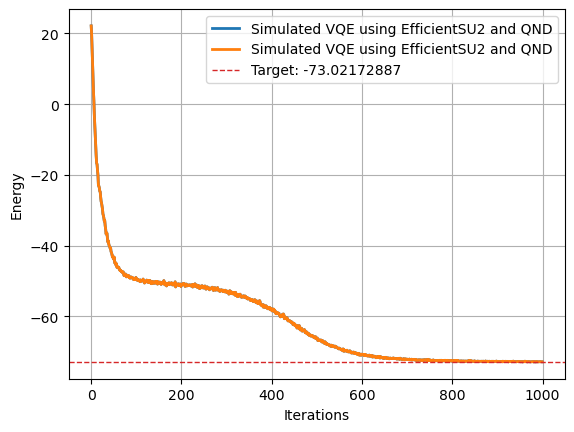

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
# %matplotlib widget

gs_energy = -73.02172887 

plt.plot(data9, lw=2, label='Simulated VQE using EfficientSU2 and QND')
plt.plot(data10, lw=2, label='Simulated VQE using EfficientSU2 and QND' )
# plt.plot(data7, lw=2, label='Simulated VQE with EfficientSU2 and GNGD')

plt.ylabel('Energy')
plt.xlabel('Iterations')
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=1, label="Target: " + str(gs_energy))
# Exact ground state energy value
# plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

Hệ của anh Truyền

In [ ]:
data11 = [1.685546875, 1.623291015625, 1.640869140625, 1.548828125, 1.552001953125, 1.48779296875, 1.421142578125, 1.464111328125, 1.419677734375, 1.408935546875, 1.336669921875, 1.33740234375, 1.34423828125, 1.345458984375, 1.253662109375, 1.268798828125, 1.25, 1.18603515625, 1.173828125, 1.0791015625, 1.07275390625, 1.095947265625, 1.02685546875, 1.0322265625, 1.00048828125, 0.97705078125, 0.88916015625, 0.8798828125, 0.783447265625, 0.728271484375, 0.7734375, 0.708740234375, 0.71630859375, 0.6962890625, 0.628662109375, 0.621826171875, 0.576904296875, 0.58251953125, 0.554931640625, 0.50048828125, 0.494140625, 0.4765625, 0.4833984375, 0.38720703125, 0.4599609375, 0.4423828125, 0.43896484375, 0.37158203125, 0.353759765625, 0.279296875, 0.3125, 0.279052734375, 0.33544921875, 0.294921875, 0.35595703125, 0.216796875, 0.177978515625, 0.20654296875, 0.134765625, 0.1611328125, 0.130126953125, 0.2060546875, 0.1474609375, 0.14208984375, 0.0986328125, 0.137939453125, 0.100341796875, 0.1552734375, 0.14453125, 0.211181640625, 0.11962890625, 0.17822265625, 0.1298828125, 0.0625, 0.0625, 0.08984375, 0.068359375, 0.112060546875, 0.065185546875, 0.018798828125, 0.0380859375, -0.042724609375, -0.0380859375, -0.09765625, -0.066162109375, -0.089111328125, -0.115478515625, -0.10888671875, -0.119384765625, -0.1455078125, -0.10498046875, -0.20263671875, -0.16845703125, -0.238037109375, -0.2197265625, -0.2255859375, -0.238037109375, -0.223388671875, -0.321533203125, -0.294189453125, -0.34033203125, -0.3662109375, -0.406982421875, -0.451904296875, -0.532470703125, -0.4775390625, -0.47607421875, -0.431396484375, -0.4638671875, -0.594970703125, -0.59912109375, -0.6630859375, -0.67041015625, -0.71337890625, -0.72900390625, -0.691650390625, -0.754638671875, -0.812744140625, -0.8193359375, -0.845947265625, -0.893310546875, -0.9150390625, -0.930419921875, -0.924560546875, -0.9638671875, -1.021240234375, -0.973388671875, -1.012451171875, -1.06201171875, -1.1416015625, -1.164306640625, -1.19921875, -1.179931640625, -1.213623046875, -1.24755859375, -1.32177734375, -1.344970703125, -1.406005859375, -1.46728515625, -1.49169921875, -1.649169921875, -1.55810546875, -1.59765625, -1.591552734375, -1.595947265625, -1.645751953125, -1.716796875, -1.721435546875, -1.739013671875, -1.781982421875, -1.83154296875, -1.76513671875, -1.848388671875, -1.80126953125, -1.82763671875, -1.841552734375, -1.93896484375, -1.88818359375, -1.981201171875, -1.958251953125, -2.001708984375, -2.06005859375, -2.12158203125, -2.1474609375, -2.194091796875, -2.227783203125, -2.201416015625, -2.2421875, -2.26953125, -2.27587890625, -2.26025390625, -2.3330078125, -2.353759765625, -2.343505859375, -2.415283203125, -2.427490234375, -2.441162109375, -2.462158203125, -2.443115234375, -2.483154296875, -2.490478515625, -2.4326171875, -2.458984375, -2.52880859375, -2.6083984375, -2.611083984375, -2.6689453125, -2.671630859375, -2.69580078125, -2.712890625, -2.6845703125, -2.7421875, -2.71923828125, -2.7705078125, -2.748779296875, -2.7724609375, -2.7529296875, -2.771484375, -2.8203125, -2.8515625, -2.886962890625, -2.8994140625, -2.926025390625, -2.924072265625, -3.00341796875, -2.98486328125, -3.061279296875, -3.0556640625, -3.0419921875, -3.019287109375, -3.0830078125, -3.095947265625, -3.03466796875, -3.1064453125, -3.10888671875, -3.0986328125, -3.088623046875, -3.107421875, -3.138427734375, -3.1240234375, -3.112548828125, -3.09716796875, -3.082763671875, -3.099365234375, -3.1142578125, -3.1337890625, -3.10986328125, -3.083984375, -3.14453125, -3.108154296875, -3.1044921875, -3.140380859375, -3.17626953125, -3.14111328125, -3.142822265625, -3.176513671875, -3.200927734375, -3.1728515625, -3.203125, -3.19384765625, -3.181640625, -3.193603515625, -3.18896484375, -3.203857421875, -3.210693359375, -3.17626953125, -3.19189453125, -3.179931640625, -3.19775390625, -3.198486328125, -3.19775390625, -3.183837890625, -3.208251953125, -3.23779296875, -3.2255859375, -3.27880859375, -3.29150390625, -3.239990234375, -3.248291015625, -3.220947265625, -3.20166015625, -3.226806640625, -3.22021484375, -3.25537109375, -3.248779296875, -3.234130859375, -3.24267578125, -3.22265625, -3.241943359375, -3.258056640625, -3.2822265625, -3.2880859375, -3.309814453125, -3.302001953125, -3.26416015625, -3.28955078125, -3.289306640625, -3.25146484375, -3.281494140625, -3.2998046875, -3.236572265625, -3.28369140625, -3.303955078125, -3.281005859375, -3.26904296875, -3.28857421875, -3.309814453125, -3.30322265625, -3.271484375, -3.309326171875, -3.30322265625, -3.28564453125, -3.300048828125, -3.273193359375, -3.29150390625, -3.328857421875, -3.2939453125, -3.290283203125, -3.323974609375, -3.349365234375, -3.28955078125, -3.338134765625, -3.325927734375, -3.328125, -3.331298828125, -3.328857421875, -3.343017578125, -3.34423828125, -3.31396484375, -3.332275390625, -3.317626953125, -3.336669921875, -3.335693359375, -3.318603515625, -3.35107421875, -3.366455078125, -3.358642578125, -3.3525390625, -3.353759765625, -3.3544921875, -3.336669921875, -3.36181640625, -3.369384765625, -3.35400390625, -3.35888671875, -3.3720703125, -3.385986328125, -3.348876953125, -3.352294921875, -3.36767578125, -3.326416015625, -3.34326171875, -3.36181640625, -3.35107421875, -3.353515625, -3.38330078125, -3.37109375, -3.36865234375, -3.384033203125, -3.373046875, -3.366455078125, -3.329345703125, -3.365966796875, -3.408447265625, -3.353271484375, -3.36572265625, -3.347412109375, -3.40771484375, -3.363525390625, -3.35400390625, -3.337158203125, -3.39013671875, -3.385986328125, -3.3837890625, -3.387451171875, -3.38427734375, -3.392822265625, -3.382568359375, -3.402587890625, -3.383544921875, -3.36474609375, -3.414306640625, -3.419189453125, -3.4208984375, -3.399658203125, -3.395751953125, -3.423583984375, -3.408935546875, -3.41455078125, -3.4189453125, -3.41015625, -3.41796875, -3.390869140625, -3.426513671875, -3.412841796875, -3.427490234375, -3.43505859375, -3.419677734375, -3.421630859375, -3.407958984375, -3.414306640625, -3.396728515625, -3.435791015625, -3.41015625, -3.45703125, -3.4306640625, -3.4384765625, -3.464599609375, -3.419921875, -3.414794921875, -3.450927734375, -3.447265625, -3.418701171875, -3.4365234375, -3.40673828125, -3.39794921875, -3.40380859375, -3.4169921875, -3.423583984375, -3.400390625, -3.43896484375, -3.430908203125, -3.433349609375, -3.380615234375, -3.43896484375, -3.41259765625, -3.412353515625, -3.4326171875, -3.41845703125, -3.4111328125, -3.421630859375, -3.45751953125, -3.402099609375, -3.45849609375, -3.423828125, -3.42578125, -3.465576171875, -3.424560546875, -3.44775390625, -3.43505859375, -3.437744140625, -3.420166015625, -3.4208984375, -3.400390625, -3.4033203125, -3.4365234375, -3.445068359375, -3.391845703125, -3.438720703125, -3.404541015625, -3.412841796875, -3.3994140625, -3.414794921875, -3.430419921875, -3.408935546875, -3.44091796875, -3.4384765625, -3.426513671875, -3.44287109375, -3.41943359375, -3.418701171875, -3.423583984375, -3.411376953125, -3.40771484375, -3.3955078125, -3.438720703125, -3.431396484375, -3.406494140625, -3.400390625, -3.43310546875, -3.417724609375, -3.385009765625, -3.411376953125, -3.408935546875, -3.4453125, -3.418701171875, -3.397705078125, -3.4150390625, -3.4091796875, -3.38427734375, -3.393310546875, -3.4140625, -3.406982421875, -3.4365234375, -3.4306640625, -3.4345703125, -3.3984375, -3.42138671875, -3.42578125, -3.411376953125, -3.405517578125, -3.41845703125, -3.39111328125, -3.393310546875, -3.40234375, -3.397216796875, -3.419677734375, -3.375, -3.404541015625, -3.4111328125, -3.380859375, -3.400390625, -3.395751953125, -3.41064453125, -3.380126953125, -3.3984375, -3.4033203125, -3.40478515625, -3.436279296875, -3.4150390625, -3.39892578125, -3.40185546875, -3.424560546875, -3.4052734375, -3.40185546875, -3.393798828125, -3.39013671875, -3.40478515625, -3.41943359375, -3.448486328125, -3.448974609375, -3.42138671875, -3.44189453125, -3.42822265625, -3.40869140625, -3.41845703125, -3.450927734375, -3.432861328125, -3.42431640625, -3.429931640625, -3.419677734375, -3.423583984375, -3.40673828125, -3.454833984375, -3.4345703125, -3.41064453125, -3.432373046875, -3.434814453125, -3.416259765625, -3.42626953125, -3.438232421875, -3.42236328125, -3.466064453125, -3.45654296875, -3.465576171875, -3.441162109375, -3.468994140625, -3.454833984375, -3.469970703125, -3.4599609375, -3.483154296875, -3.4619140625, -3.471435546875, -3.48876953125, -3.5009765625, -3.506591796875, -3.475830078125, -3.48974609375, -3.464599609375, -3.49853515625, -3.43798828125, -3.5029296875, -3.467041015625, -3.494140625, -3.484375, -3.453857421875, -3.497314453125, -3.505859375, -3.481201171875, -3.453857421875, -3.51513671875, -3.492919921875, -3.504150390625, -3.49658203125, -3.50390625, -3.497314453125, -3.4736328125, -3.446533203125, -3.49462890625, -3.505126953125, -3.486328125, -3.504150390625, -3.5478515625, -3.497802734375, -3.53271484375, -3.4755859375, -3.509765625, -3.49755859375, -3.47998046875, -3.52490234375, -3.476318359375, -3.495361328125, -3.4892578125, -3.51513671875, -3.5048828125, -3.49658203125, -3.491455078125, -3.475341796875, -3.476806640625, -3.488525390625, -3.462890625, -3.4697265625, -3.4912109375, -3.47265625, -3.47607421875, -3.4697265625, -3.479248046875, -3.4921875, -3.48486328125, -3.481689453125, -3.49853515625, -3.473876953125, -3.452880859375, -3.456298828125, -3.477294921875, -3.5, -3.47314453125, -3.480712890625, -3.479248046875, -3.481689453125, -3.47265625, -3.49658203125, -3.516845703125, -3.47314453125, -3.4951171875, -3.48193359375, -3.496826171875, -3.478271484375, -3.46044921875, -3.48974609375, -3.522216796875, -3.516845703125, -3.5029296875, -3.5166015625, -3.506591796875, -3.505615234375, -3.505859375, -3.5048828125, -3.527099609375, -3.5224609375, -3.52978515625, -3.514404296875, -3.509765625, -3.5185546875, -3.52685546875, -3.52099609375, -3.486083984375, -3.5087890625, -3.496826171875, -3.531005859375, -3.528076171875, -3.52734375, -3.48486328125, -3.509521484375, -3.519287109375, -3.528564453125, -3.51904296875, -3.5166015625, -3.501708984375, -3.5126953125, -3.529296875, -3.545166015625, -3.537109375, -3.55517578125, -3.532958984375, -3.52587890625, -3.562255859375, -3.504150390625, -3.530029296875, -3.553955078125, -3.563232421875, -3.556884765625, -3.545166015625, -3.562255859375, -3.544189453125, -3.551025390625, -3.57177734375, -3.548095703125, -3.53271484375, -3.545654296875, -3.558349609375, -3.548828125, -3.537353515625, -3.546142578125, -3.515869140625, -3.53173828125, -3.534423828125, -3.563232421875, -3.524169921875, -3.5478515625, -3.487060546875, -3.537109375, -3.5380859375, -3.546142578125, -3.523193359375, -3.575927734375, -3.55126953125, -3.56005859375, -3.581298828125, -3.567626953125, -3.53857421875, -3.568359375, -3.543212890625, -3.580078125, -3.540283203125, -3.551513671875, -3.540283203125, -3.53076171875, -3.546875, -3.555908203125, -3.5498046875, -3.53564453125, -3.5654296875, -3.57080078125, -3.571044921875, -3.5458984375, -3.53125, -3.524658203125, -3.517578125, -3.498291015625, -3.5, -3.54443359375, -3.49560546875, -3.505126953125, -3.52294921875, -3.511474609375, -3.49609375, -3.49658203125, -3.527099609375, -3.531494140625, -3.543212890625, -3.508056640625, -3.52587890625, -3.501708984375, -3.49658203125, -3.509765625, -3.503662109375, -3.522705078125, -3.509765625, -3.515869140625, -3.525390625, -3.549072265625, -3.507080078125, -3.5009765625, -3.522705078125, -3.536376953125, -3.516357421875, -3.51611328125, -3.533447265625, -3.509033203125, -3.519287109375, -3.5234375, -3.4970703125, -3.51123046875, -3.541259765625, -3.519775390625, -3.551025390625, -3.506591796875, -3.532470703125, -3.542236328125, -3.54736328125, -3.517333984375, -3.527587890625, -3.546630859375, -3.529052734375, -3.530517578125, -3.519287109375, -3.57080078125, -3.509765625, -3.5634765625, -3.529541015625, -3.542236328125, -3.537353515625, -3.545654296875, -3.504150390625, -3.52978515625, -3.508056640625, -3.54833984375, -3.505615234375, -3.540771484375, -3.531494140625, -3.521728515625, -3.53857421875, -3.5400390625, -3.5078125, -3.5263671875, -3.54248046875, -3.556884765625, -3.555908203125, -3.5498046875, -3.538818359375, -3.516357421875, -3.558837890625, -3.53076171875, -3.532470703125, -3.55322265625, -3.54150390625, -3.522216796875, -3.564453125, -3.5517578125, -3.5478515625, -3.546875, -3.558349609375, -3.60498046875, -3.562255859375, -3.567138671875, -3.53857421875, -3.571044921875, -3.54541015625, -3.54736328125, -3.529052734375, -3.52978515625, -3.564453125, -3.56494140625, -3.53173828125, -3.552001953125, -3.5546875, -3.53564453125, -3.5146484375, -3.52978515625, -3.531494140625, -3.560791015625, -3.564453125, -3.54248046875, -3.54638671875, -3.56640625, -3.55712890625, -3.534912109375, -3.551513671875, -3.56884765625, -3.556884765625, -3.528076171875, -3.582763671875, -3.56591796875, -3.587646484375, -3.576904296875, -3.549072265625, -3.564208984375, -3.5947265625, -3.587158203125, -3.540771484375, -3.58642578125, -3.551025390625, -3.577392578125, -3.55126953125, -3.567138671875, -3.5517578125, -3.5390625, -3.547119140625, -3.58935546875, -3.565673828125, -3.563720703125, -3.5732421875, -3.564208984375, -3.555908203125, -3.569580078125, -3.539794921875, -3.53271484375, -3.5517578125, -3.54833984375, -3.564208984375, -3.521728515625, -3.53662109375, -3.542724609375, -3.537841796875, -3.551025390625, -3.5732421875, -3.5419921875, -3.562255859375, -3.5302734375, -3.535400390625, -3.5380859375, -3.52587890625, -3.546630859375, -3.52783203125, -3.536376953125, -3.52392578125, -3.51513671875, -3.555419921875, -3.55712890625, -3.56005859375, -3.522216796875, -3.5283203125, -3.5654296875, -3.547119140625, -3.566162109375, -3.553466796875, -3.553466796875, -3.545654296875, -3.54248046875, -3.563720703125, -3.56689453125, -3.555908203125, -3.5830078125, -3.605224609375, -3.5498046875, -3.560302734375, -3.55029296875, -3.612060546875, -3.55078125, -3.5400390625, -3.56494140625, -3.552001953125, -3.55224609375, -3.58544921875, -3.5791015625, -3.567626953125, -3.557861328125, -3.54443359375, -3.55126953125, -3.51708984375, -3.579345703125, -3.53076171875, -3.54443359375, -3.560791015625, -3.583984375, -3.558349609375, -3.604248046875, -3.538818359375, -3.5615234375, -3.6015625, -3.58935546875, -3.564697265625, -3.587646484375, -3.556640625, -3.59033203125, -3.601806640625, -3.604736328125, -3.56298828125, -3.5859375, -3.5595703125, -3.573486328125, -3.595458984375, -3.59814453125, -3.57470703125, -3.573974609375, -3.57958984375, -3.5849609375, -3.560791015625, -3.572265625, -3.5625, -3.56787109375, -3.5908203125, -3.564208984375, -3.56103515625, -3.563232421875, -3.549072265625, -3.59912109375, -3.56884765625, -3.54443359375, -3.56640625, -3.553466796875, -3.56494140625, -3.536376953125, -3.566162109375, -3.53564453125, -3.54296875, -3.560302734375, -3.583740234375, -3.551025390625, -3.5498046875, -3.552978515625, -3.547119140625, -3.532470703125, -3.576416015625, -3.5595703125, -3.5302734375, -3.5546875, -3.55126953125, -3.54345703125, -3.5283203125, -3.55419921875, -3.553466796875, -3.578369140625, -3.5625, -3.538818359375, -3.55615234375, -3.55859375, -3.562255859375, -3.574951171875, -3.600830078125, -3.592041015625, -3.582763671875, -3.55810546875, -3.551513671875, -3.56689453125, -3.583984375, -3.5927734375, -3.5634765625, -3.58935546875, -3.591064453125, -3.54931640625, -3.5625, -3.57958984375, -3.541259765625, -3.58642578125, -3.55908203125, -3.5888671875, -3.568603515625, -3.587158203125, -3.59619140625, -3.60546875, -3.59521484375, -3.58935546875, -3.593017578125, -3.612060546875, -3.58349609375, -3.545166015625, -3.5625, -3.56591796875, -3.58154296875, -3.57177734375, -3.5986328125, -3.567138671875, -3.5712890625, -3.53564453125, -3.596923828125, -3.582275390625, -3.578857421875, -3.59130859375]


In [ ]:
data12 = [1.566650390625, 1.411376953125, 1.15625, 0.859375, 0.4853515625, 0.099365234375, -0.311279296875, -0.582275390625, -0.85791015625, -1.11181640625, -1.335205078125, -1.529052734375, -1.605712890625, -1.73486328125, -1.783203125, -1.891845703125, -1.95703125, -2.070556640625, -2.08642578125, -2.20068359375, -2.243408203125, -2.259765625, -2.32080078125, -2.389404296875, -2.390380859375, -2.43701171875, -2.544921875, -2.51708984375, -2.574951171875, -2.60302734375, -2.638427734375, -2.69873046875, -2.73388671875, -2.7158203125, -2.75634765625, -2.770751953125, -2.806396484375, -2.84375, -2.9111328125, -2.912353515625, -2.92626953125, -2.95068359375, -2.96435546875, -2.99267578125, -2.984130859375, -3.03564453125, -3.0498046875, -3.056640625, -3.056640625, -3.068603515625, -3.098388671875, -3.104736328125, -3.126953125, -3.14453125, -3.142333984375, -3.1396484375, -3.1826171875, -3.15576171875, -3.158935546875, -3.176025390625, -3.183349609375, -3.169189453125, -3.202392578125, -3.19873046875, -3.198486328125, -3.239013671875, -3.205810546875, -3.212158203125, -3.256103515625, -3.251953125, -3.24951171875, -3.23974609375, -3.29150390625, -3.257568359375, -3.27197265625, -3.28125, -3.267822265625, -3.253662109375, -3.261474609375, -3.27783203125, -3.286865234375, -3.275634765625, -3.28564453125, -3.2958984375, -3.285888671875, -3.247802734375, -3.279541015625, -3.23193359375, -3.260986328125, -3.2880859375, -3.290771484375, -3.2783203125, -3.294189453125, -3.279541015625, -3.28173828125, -3.308837890625, -3.294921875, -3.2861328125, -3.30322265625, -3.30322265625, -3.279052734375, -3.236328125, -3.3037109375, -3.3134765625, -3.318115234375, -3.28076171875, -3.24951171875, -3.276611328125, -3.308349609375, -3.311767578125, -3.333251953125, -3.322509765625, -3.293701171875, -3.30029296875, -3.291748046875, -3.3203125, -3.291748046875, -3.284423828125, -3.285400390625, -3.287109375, -3.278564453125, -3.296630859375, -3.2744140625, -3.272705078125, -3.2890625, -3.32177734375, -3.29833984375, -3.32275390625, -3.299072265625, -3.27392578125, -3.3037109375, -3.31201171875, -3.28564453125, -3.278076171875, -3.305419921875, -3.296142578125, -3.327880859375, -3.300048828125, -3.29052734375, -3.292724609375, -3.3017578125, -3.311767578125, -3.335205078125, -3.310302734375, -3.28564453125, -3.326904296875, -3.300048828125, -3.303466796875, -3.270751953125, -3.287109375, -3.33154296875, -3.330322265625, -3.2861328125, -3.28857421875, -3.28564453125, -3.267333984375, -3.318115234375, -3.311279296875, -3.295166015625, -3.28955078125, -3.288818359375, -3.298828125, -3.30078125, -3.302978515625, -3.316650390625, -3.29345703125, -3.267822265625, -3.3017578125, -3.299560546875, -3.276123046875, -3.30224609375, -3.3095703125, -3.287353515625, -3.276123046875, -3.291259765625, -3.282958984375, -3.28759765625, -3.306396484375, -3.298583984375, -3.286376953125, -3.298583984375, -3.269287109375, -3.28759765625, -3.304931640625, -3.3017578125, -3.2958984375, -3.296630859375, -3.296630859375, -3.28955078125, -3.271240234375, -3.2822265625, -3.294189453125, -3.313720703125, -3.282958984375, -3.299072265625, -3.281982421875, -3.290283203125, -3.299560546875, -3.308349609375, -3.306884765625, -3.298095703125, -3.2998046875, -3.292724609375, -3.3291015625, -3.325927734375, -3.310546875, -3.30224609375, -3.30615234375, -3.2939453125, -3.288330078125, -3.265869140625, -3.28271484375, -3.324951171875, -3.285400390625, -3.282958984375, -3.296142578125, -3.281494140625, -3.303466796875, -3.3193359375, -3.29443359375, -3.30419921875, -3.293212890625, -3.2919921875, -3.30810546875, -3.3154296875, -3.320068359375, -3.333251953125, -3.304443359375, -3.309814453125, -3.29541015625, -3.306884765625, -3.286376953125, -3.303466796875, -3.300048828125, -3.291259765625, -3.314453125, -3.2939453125, -3.303955078125, -3.325927734375, -3.269775390625, -3.292724609375, -3.2998046875, -3.278076171875, -3.31982421875, -3.3193359375, -3.283935546875, -3.260498046875, -3.334716796875, -3.302490234375, -3.277587890625, -3.281005859375, -3.2978515625, -3.275146484375, -3.302734375, -3.278564453125, -3.307373046875, -3.325439453125, -3.30078125, -3.296630859375, -3.278564453125, -3.34228515625, -3.28125, -3.313232421875, -3.283935546875, -3.312744140625, -3.299072265625, -3.2705078125, -3.282470703125, -3.271728515625, -3.26318359375, -3.295166015625, -3.306884765625, -3.304931640625, -3.298828125, -3.311279296875, -3.28125, -3.29736328125, -3.308349609375, -3.2841796875, -3.28369140625, -3.298828125, -3.282470703125, -3.282470703125, -3.297607421875, -3.343505859375, -3.3125, -3.302978515625, -3.3173828125, -3.302734375, -3.326171875, -3.279296875, -3.307373046875, -3.326171875, -3.294921875, -3.309814453125, -3.331787109375, -3.293212890625, -3.31884765625, -3.31298828125, -3.282958984375, -3.304443359375, -3.31884765625, -3.297607421875, -3.3134765625, -3.342529296875, -3.29052734375, -3.28759765625, -3.3095703125, -3.30078125, -3.312744140625, -3.31494140625, -3.295654296875, -3.26904296875, -3.27978515625, -3.29443359375, -3.314453125, -3.318603515625, -3.3369140625, -3.274658203125, -3.3193359375, -3.30419921875, -3.30126953125, -3.329345703125, -3.305419921875, -3.30419921875, -3.32958984375, -3.3232421875, -3.3046875, -3.306396484375, -3.308837890625, -3.302978515625, -3.311767578125, -3.327392578125, -3.304931640625, -3.2734375, -3.29833984375, -3.292236328125, -3.3349609375, -3.30810546875, -3.307861328125, -3.30712890625, -3.312255859375, -3.290771484375, -3.313720703125, -3.279296875, -3.311279296875, -3.307373046875, -3.316162109375, -3.306396484375, -3.31494140625, -3.268310546875, -3.283447265625, -3.2978515625, -3.3291015625, -3.28564453125, -3.32275390625, -3.27783203125, -3.338623046875, -3.303955078125, -3.3359375, -3.301513671875, -3.282958984375, -3.307373046875, -3.317138671875, -3.3271484375, -3.323486328125, -3.263671875, -3.311767578125, -3.312255859375, -3.329345703125, -3.322265625, -3.28662109375, -3.311767578125, -3.325439453125, -3.2802734375, -3.31298828125, -3.325439453125, -3.330078125, -3.288818359375, -3.31103515625, -3.314697265625, -3.30126953125, -3.31005859375, -3.296875, -3.31396484375, -3.296630859375, -3.302734375, -3.324951171875, -3.312744140625, -3.324951171875, -3.31494140625, -3.339111328125, -3.29931640625, -3.28662109375, -3.287353515625, -3.29443359375, -3.313720703125, -3.321533203125, -3.333984375, -3.30615234375, -3.28564453125, -3.32763671875, -3.311767578125, -3.283203125, -3.27001953125, -3.349853515625, -3.294189453125, -3.294921875, -3.309326171875, -3.2880859375, -3.312255859375, -3.3056640625, -3.3017578125, -3.328125, -3.32177734375, -3.31591796875, -3.270751953125, -3.30810546875, -3.31689453125, -3.33349609375, -3.2724609375, -3.2998046875, -3.265380859375, -3.318115234375, -3.30322265625, -3.318359375, -3.302978515625, -3.310546875, -3.32373046875, -3.294921875, -3.301025390625, -3.296630859375, -3.305419921875, -3.26318359375, -3.32666015625, -3.279541015625, -3.34130859375, -3.303466796875, -3.303955078125, -3.325927734375, -3.32470703125, -3.30810546875, -3.32568359375, -3.301513671875, -3.3046875, -3.3212890625, -3.306884765625, -3.29248046875, -3.305419921875, -3.29736328125, -3.287109375, -3.275634765625, -3.295166015625, -3.329833984375, -3.289306640625, -3.276611328125, -3.31396484375, -3.29052734375, -3.31787109375, -3.298828125, -3.30126953125, -3.331787109375, -3.330810546875, -3.29638671875, -3.30517578125, -3.276611328125, -3.293212890625, -3.306396484375, -3.32373046875, -3.307861328125, -3.325439453125, -3.308349609375, -3.328369140625, -3.260498046875, -3.30615234375, -3.3076171875, -3.3037109375, -3.289794921875, -3.28369140625, -3.30126953125, -3.29638671875, -3.308837890625, -3.32666015625, -3.2734375, -3.264404296875, -3.326171875, -3.326416015625, -3.311279296875, -3.3173828125, -3.304443359375, -3.302490234375, -3.30615234375, -3.299560546875, -3.303466796875, -3.302001953125, -3.2724609375, -3.31201171875, -3.311767578125, -3.31298828125, -3.3017578125, -3.27880859375, -3.324951171875, -3.29736328125, -3.294189453125, -3.2763671875, -3.320556640625, -3.263916015625, -3.296630859375, -3.291748046875, -3.310791015625, -3.3076171875, -3.329345703125, -3.30712890625, -3.31689453125, -3.295654296875, -3.318115234375, -3.32421875, -3.310791015625, -3.301025390625, -3.292724609375, -3.3154296875, -3.304931640625, -3.2783203125, -3.3203125, -3.316162109375, -3.306640625, -3.289306640625, -3.295654296875, -3.32080078125, -3.290283203125, -3.296630859375, -3.313720703125, -3.3486328125, -3.3388671875, -3.2880859375, -3.321044921875, -3.3046875, -3.27685546875, -3.34765625, -3.282470703125, -3.309326171875, -3.281494140625, -3.29833984375, -3.292236328125, -3.282470703125, -3.331298828125, -3.321533203125, -3.311279296875, -3.303955078125, -3.29345703125, -3.304443359375, -3.327880859375, -3.30859375, -3.29052734375, -3.32470703125, -3.29833984375, -3.330810546875, -3.30810546875, -3.315673828125, -3.309814453125, -3.2822265625, -3.342041015625, -3.301025390625, -3.29833984375, -3.301513671875, -3.281982421875, -3.320556640625, -3.31689453125, -3.308837890625, -3.29296875, -3.31787109375, -3.2998046875, -3.30908203125, -3.31591796875, -3.299072265625, -3.296142578125, -3.314453125, -3.304931640625, -3.2880859375, -3.25830078125, -3.287109375, -3.29736328125, -3.291259765625, -3.3134765625, -3.29248046875, -3.340576171875, -3.30126953125, -3.311767578125, -3.32421875, -3.303466796875, -3.289794921875, -3.314697265625, -3.32373046875, -3.31591796875, -3.283203125, -3.30517578125, -3.318115234375, -3.31982421875, -3.297119140625, -3.321044921875, -3.3330078125, -3.272705078125, -3.316650390625, -3.316162109375, -3.29541015625, -3.32080078125, -3.322265625, -3.309326171875, -3.3466796875, -3.28857421875, -3.309326171875, -3.296630859375, -3.28955078125, -3.3173828125, -3.306640625, -3.28076171875, -3.3173828125, -3.2919921875, -3.30419921875, -3.31884765625, -3.299072265625, -3.282470703125, -3.263427734375, -3.283935546875, -3.30859375, -3.314208984375, -3.323486328125, -3.301513671875, -3.3330078125, -3.27294921875, -3.308349609375, -3.32861328125, -3.31298828125, -3.314453125, -3.293701171875, -3.339111328125, -3.317626953125, -3.290771484375, -3.29736328125, -3.31787109375, -3.314453125, -3.3173828125, -3.330078125, -3.3115234375, -3.3173828125, -3.341064453125, -3.3037109375, -3.310302734375, -3.301513671875, -3.326416015625, -3.298095703125, -3.294921875, -3.311767578125, -3.30029296875, -3.322265625, -3.31787109375, -3.32958984375, -3.296875, -3.2958984375, -3.29736328125, -3.287353515625, -3.30078125, -3.31494140625, -3.318603515625, -3.30859375, -3.32275390625, -3.304443359375, -3.319091796875, -3.291748046875, -3.30029296875, -3.291748046875, -3.301513671875, -3.291259765625, -3.3212890625, -3.321533203125, -3.27880859375, -3.25341796875, -3.32470703125, -3.30908203125, -3.32568359375, -3.306640625, -3.26708984375, -3.275634765625, -3.31103515625, -3.298095703125, -3.31689453125, -3.308837890625, -3.295654296875, -3.317138671875, -3.29296875, -3.300537109375, -3.3125, -3.29931640625, -3.297607421875, -3.3134765625, -3.303466796875, -3.314697265625, -3.303466796875, -3.28759765625, -3.330322265625, -3.325927734375, -3.31982421875, -3.33740234375, -3.33544921875, -3.281494140625, -3.306884765625, -3.32470703125, -3.278076171875, -3.27490234375, -3.322998046875, -3.284423828125, -3.289794921875, -3.293212890625, -3.28271484375, -3.291748046875, -3.288330078125, -3.327880859375, -3.34375, -3.315673828125, -3.301025390625, -3.30712890625, -3.326904296875, -3.312744140625, -3.30126953125, -3.364990234375, -3.298828125, -3.2978515625, -3.300048828125, -3.284423828125, -3.317626953125, -3.300537109375, -3.284912109375, -3.31103515625, -3.2646484375, -3.285888671875, -3.291015625, -3.311767578125, -3.30712890625, -3.3388671875, -3.291748046875, -3.29736328125, -3.32568359375, -3.300048828125, -3.3056640625, -3.34619140625, -3.28857421875, -3.30419921875, -3.322021484375, -3.320068359375, -3.343994140625, -3.3115234375, -3.286865234375, -3.34423828125, -3.31884765625, -3.291748046875, -3.311279296875, -3.295166015625, -3.27490234375, -3.25, -3.292236328125, -3.29296875, -3.301025390625, -3.310546875, -3.2919921875, -3.322509765625, -3.302490234375, -3.310791015625, -3.32666015625, -3.3125, -3.3056640625, -3.304931640625, -3.30224609375, -3.281982421875, -3.281494140625, -3.309326171875, -3.297607421875, -3.332763671875, -3.272216796875, -3.301513671875, -3.310546875, -3.316162109375, -3.332763671875, -3.285888671875, -3.31689453125, -3.304443359375, -3.329833984375, -3.31787109375, -3.333251953125, -3.328125, -3.322998046875, -3.318603515625, -3.32373046875, -3.2822265625, -3.299072265625, -3.327392578125, -3.32568359375, -3.3173828125, -3.312255859375, -3.30322265625, -3.299072265625, -3.322021484375, -3.28271484375, -3.32763671875, -3.306640625, -3.31298828125, -3.33349609375, -3.301513671875, -3.282958984375, -3.3134765625, -3.32470703125, -3.326416015625, -3.31787109375, -3.30908203125, -3.312255859375, -3.315673828125, -3.31787109375, -3.3134765625, -3.3095703125, -3.302734375, -3.316650390625, -3.31982421875, -3.30712890625, -3.30712890625, -3.328857421875, -3.30712890625, -3.322265625, -3.30517578125, -3.309814453125, -3.299072265625, -3.31005859375, -3.279052734375, -3.314208984375, -3.311279296875, -3.3095703125, -3.29931640625, -3.3291015625, -3.301513671875, -3.30517578125, -3.292724609375, -3.34521484375, -3.2958984375, -3.3125, -3.32763671875, -3.327880859375, -3.2685546875, -3.3095703125, -3.33935546875, -3.30810546875, -3.326171875, -3.291015625, -3.314208984375, -3.279541015625, -3.32177734375, -3.3134765625, -3.30224609375, -3.302001953125, -3.310302734375, -3.275390625, -3.3134765625, -3.330810546875, -3.330322265625, -3.302490234375, -3.29638671875, -3.323974609375, -3.2978515625, -3.30712890625, -3.333984375, -3.275634765625, -3.33251953125, -3.314453125, -3.324951171875, -3.301025390625, -3.293701171875, -3.282958984375, -3.295654296875, -3.299072265625, -3.295166015625, -3.304931640625, -3.286376953125, -3.322998046875, -3.33349609375, -3.2841796875, -3.29833984375, -3.31787109375, -3.3251953125, -3.305908203125, -3.2998046875, -3.30224609375, -3.286376953125, -3.30419921875, -3.332763671875, -3.31396484375, -3.29833984375, -3.329345703125, -3.291015625, -3.28369140625, -3.302978515625, -3.331298828125, -3.294921875, -3.2880859375, -3.307861328125, -3.316162109375, -3.299560546875, -3.28271484375, -3.307861328125, -3.305419921875, -3.359619140625, -3.288330078125, -3.3095703125, -3.33447265625, -3.292236328125, -3.29443359375, -3.31689453125, -3.3037109375, -3.3251953125, -3.32470703125, -3.323974609375, -3.289306640625, -3.314453125, -3.30615234375, -3.311279296875, -3.29248046875, -3.33447265625, -3.30517578125, -3.309814453125, -3.320556640625, -3.28662109375, -3.2939453125, -3.26806640625, -3.318115234375, -3.31787109375, -3.294677734375, -3.3017578125, -3.264404296875, -3.295654296875, -3.305908203125, -3.31982421875, -3.318359375, -3.3232421875, -3.29736328125, -3.318115234375, -3.310302734375, -3.2919921875, -3.31103515625, -3.316162109375, -3.287841796875, -3.30810546875, -3.30029296875, -3.331298828125, -3.322021484375, -3.294677734375, -3.33056640625, -3.3173828125, -3.293701171875, -3.3125, -3.3125, -3.286865234375, -3.293701171875, -3.279296875, -3.32373046875, -3.32666015625, -3.2998046875, -3.3017578125, -3.31640625, -3.286376953125, -3.3271484375, -3.279296875, -3.322509765625, -3.3349609375, -3.306884765625, -3.319091796875, -3.298583984375, -3.286376953125, -3.297607421875, -3.308837890625, -3.32666015625, -3.318603515625, -3.294677734375, -3.300537109375, -3.320556640625, -3.30419921875, -3.3095703125, -3.293701171875, -3.30908203125, -3.31005859375, -3.302734375, -3.302490234375, -3.29638671875, -3.27392578125, -3.287353515625, -3.296142578125, -3.31591796875, -3.30712890625, -3.312744140625, -3.284423828125, -3.311279296875, -3.312255859375, -3.323974609375, -3.3095703125, -3.279541015625]

In [ ]:
data13 = [0.8015, 0.04849999999999999, -0.8203, -1.5426, -2.046, -2.2801, -2.3834999999999997, -2.4865000000000004, -2.5587999999999997, -2.6235, -2.6268, -2.6755, -2.7124, -2.7223, -2.7827, -2.8065, -2.8067999999999995, -2.8285000000000005, -2.8167, -2.8404999999999996, -2.8522, -2.9027000000000003, -2.8920999999999997, -2.8842, -2.8776999999999995, -2.9265, -2.9158999999999997, -2.8916000000000004, -2.9376, -2.9258, -2.9225999999999996, -2.9417999999999997, -2.968, -2.9566, -2.9699999999999998, -2.9461000000000004, -2.9769, -2.9785, -2.9659, -2.9967999999999995, -2.9607, -3.0058, -3.022, -3.0113, -2.9927, -2.9909, -3.0249, -3.016, -3.0162, -3.0458, -3.0351999999999997, -3.0173, -3.0843, -3.0686000000000004, -3.0816000000000003, -3.0904000000000003, -3.0867000000000004, -3.0958, -3.1350000000000002, -3.1272, -3.1357, -3.1499, -3.1559, -3.1710000000000003, -3.1959000000000004, -3.1959, -3.2443999999999997, -3.2469, -3.2908, -3.3136999999999994, -3.3053, -3.3282999999999996, -3.3628, -3.3701999999999996, -3.4169, -3.4493, -3.4474, -3.4611, -3.4655, -3.4989000000000003, -3.5311000000000003, -3.5206, -3.5254, -3.5552, -3.5503, -3.5564, -3.5625, -3.5702999999999996, -3.5839, -3.5818000000000003, -3.5896000000000003, -3.5811, -3.5825, -3.6050000000000004, -3.572, -3.5852, -3.5807, -3.5940000000000003, -3.6092999999999997, -3.5936, -3.5913, -3.5898, -3.6072999999999995, -3.6041999999999996, -3.6143, -3.5905000000000005, -3.5918, -3.5998, -3.5991999999999997, -3.5931, -3.5837, -3.6090999999999998, -3.5901000000000005, -3.6056, -3.6124, -3.5891, -3.6094, -3.6083, -3.6163, -3.5982000000000003, -3.6251, -3.6191000000000004, -3.6019000000000005, -3.6024000000000003, -3.597, -3.6128, -3.6039, -3.6088, -3.6041, -3.6103000000000005, -3.6066000000000003, -3.5924, -3.5894, -3.6022999999999996, -3.6023, -3.6003, -3.6007000000000002, -3.6077999999999997, -3.621, -3.5938, -3.6033, -3.6093, -3.5941, -3.6120000000000005, -3.6121999999999996, -3.585, -3.6148, -3.6223, -3.6097, -3.6006, -3.6334, -3.5960000000000005, -3.6074, -3.5964, -3.5942000000000003, -3.6102999999999996, -3.6074, -3.5995, -3.6072, -3.6073, -3.5744000000000002, -3.6123, -3.6246, -3.6029, -3.6186999999999996, -3.6168000000000005, -3.6103999999999994, -3.6041, -3.6314, -3.5951, -3.625, -3.6068999999999996, -3.6041999999999996, -3.6161, -3.5928, -3.6231, -3.6093, -3.6141, -3.6051, -3.6169000000000002, -3.5951, -3.6205, -3.6062, -3.6197, -3.5888999999999998, -3.6037, -3.5985, -3.5999999999999996, -3.5989, -3.5892000000000004, -3.6007, -3.6085999999999996, -3.5939, -3.6028000000000002, -3.5948, -3.6080000000000005, -3.6074, -3.6048, -3.6097, -3.6300999999999997]


In [ ]:
data14 = [1.4763, 0.5817999999999999, 0.0915, -0.47220000000000006, -0.7622, -0.8966999999999999, -1.6412, -1.863, -1.8654, -1.8791, -2.1847, -2.3646000000000003, -2.5549999999999997, -2.5457, -2.6987000000000005, -2.7302999999999997, -2.6215, -2.7357, -2.7112, -2.7098, -2.7061999999999995, -2.6363, -2.6928, -2.7082, -2.6108000000000002, -2.673, -2.7247000000000003, -2.6723000000000003, -2.7615, -2.7103, -2.7629, -2.8101, -2.7704999999999997, -2.7870999999999997, -2.6908000000000003, -2.6807, -2.6696, -2.6334999999999997, -2.6375999999999995, -2.6826999999999996, -2.8210999999999995, -2.7981, -2.7378, -2.7641, -2.8223000000000003, -2.6313999999999997, -2.7273, -2.7535, -2.912, -2.9008000000000003, -2.8062000000000005, -2.9032999999999998, -2.8438, -2.9481, -3.0325, -3.0452000000000004, -3.1163999999999996, -3.0927999999999995, -3.0778, -3.0849, -3.0169000000000006, -3.0202, -3.0364999999999998, -3.2508, -3.2232000000000003, -3.2390999999999996, -3.183, -3.0972, -3.2957, -3.2698, -3.2214, -3.2871, -3.4039, -3.3801000000000005, -3.3903000000000003, -3.4128000000000003, -3.4285000000000005, -3.4181, -3.5147, -3.5473999999999997, -3.4526000000000003, -3.452, -3.4415999999999998, -3.3898, -3.4212, -3.4455999999999998, -3.4789000000000003, -3.5434, -3.454, -3.3474999999999997, -3.5097, -3.5293, -3.548, -3.5376999999999996, -3.4513, -3.4833000000000003, -3.4730999999999996, -3.5328, -3.4227, -3.4192, -3.4689, -3.4873000000000003, -3.5027, -3.5365, -3.5568, -3.4366, -3.4463, -3.5155000000000003, -3.5244999999999997, -3.4828, -3.5472, -3.5338, -3.4898000000000002, -3.4978, -3.5757, -3.5368000000000004, -3.5562000000000005, -3.553, -3.4939, -3.5292000000000003, -3.5186, -3.4763, -3.4973, -3.4417, -3.4751999999999996, -3.4792, -3.5580999999999996, -3.5031, -3.3669, -3.3302, -3.2897000000000003, -3.4654000000000003, -3.4452000000000003, -3.477, -3.5276, -3.3930999999999996, -3.4638999999999998, -3.4314, -3.5055, -3.4592, -3.4269, -3.2274000000000003, -3.4206000000000003, -3.3922, -3.4114999999999998, -3.3630000000000004, -3.5503, -3.4959000000000002, -3.4711999999999996, -3.4145, -3.4805, -3.5235, -3.4801, -3.4763, -3.4292000000000002, -3.3949, -3.4667000000000003, -3.5526, -3.5336, -3.5468, -3.5125, -3.5524999999999998, -3.4862, -3.5098000000000003, -3.4909999999999997, -3.5712999999999995, -3.484, -3.4958, -3.4397, -3.4768, -3.3993, -3.4726, -3.4246, -3.4708, -3.474, -3.4531, -3.3247999999999998, -3.2546999999999997, -3.413, -3.3293999999999997, -3.3115, -3.3144, -3.4897, -3.5168999999999997, -3.4459, -3.5664, -3.5277000000000003, -3.4644999999999997, -3.4363, -3.3363, -3.3777999999999997, -3.368, -3.4296, -3.4644, -3.2718, -3.5093000000000005, -3.3533, -3.4703999999999997, -3.4707, -3.3853999999999997]


In [ ]:
data15 = [1.1433, 1.0005, 0.6787000000000001, 0.4353, 0.2424, 0.00740000000000003, -0.1169, -0.2614, -0.16569999999999996, -0.27799999999999997, -0.5194, -0.6527999999999999, -0.8929000000000001, -1.0357999999999998, -1.3538000000000001, -1.7105000000000001, -1.8875, -2.0631, -2.1321999999999997, -2.3126, -2.4359000000000006, -2.5187, -2.5303, -2.5164, -2.6235999999999997, -2.6677, -2.6768, -2.7141999999999995, -2.7056, -2.8030000000000004, -2.8815000000000004, -2.9657000000000004, -2.909, -2.9175, -2.9387, -2.9865999999999993, -3.0215, -3.0728999999999997, -3.0599, -3.0975, -3.1136999999999997, -3.0646999999999998, -3.0369, -3.0940000000000003, -3.0330000000000004, -3.0721, -3.1331999999999995, -3.1461, -3.2221999999999995, -3.1974, -3.2023, -3.1904, -3.1891, -3.2076000000000002, -3.2310999999999996, -3.1952, -3.2522, -3.1979, -3.2347, -3.2541, -3.2725, -3.2553, -3.2552000000000003, -3.1661, -3.1775999999999995, -3.1866, -3.1841999999999997, -3.2422999999999997, -3.2344, -3.2409, -3.2230999999999996, -3.2323999999999997, -3.2466, -3.2132, -3.2407000000000004, -3.2485999999999997, -3.2338999999999998, -3.2056999999999998, -3.2567, -3.2274000000000003, -3.2506999999999997, -3.2709, -3.2596000000000003, -3.2552, -3.2365000000000004, -3.268, -3.237, -3.2582999999999998, -3.2133, -3.2339, -3.238, -3.2214, -3.2184999999999997, -3.2001, -3.2483000000000004, -3.2524, -3.2074000000000003, -3.2573999999999996, -3.2773000000000003, -3.2616, -3.2731, -3.2826000000000004, -3.2292000000000005, -3.2156, -3.2116000000000002, -3.2651000000000003, -3.2481999999999998, -3.2401, -3.2493999999999996, -3.284, -3.274, -3.2711, -3.2671, -3.2606, -3.2722, -3.2466, -3.2335000000000003, -3.2666, -3.2603, -3.2537000000000003, -3.2038, -3.2198, -3.2547, -3.2548000000000004, -3.2455, -3.2672999999999996, -3.2373000000000003, -3.2683999999999997, -3.286, -3.2754000000000003, -3.2359, -3.1605, -3.2492, -3.2558999999999996, -3.2285000000000004, -3.253, -3.2912, -3.2994, -3.2680999999999996, -3.3036, -3.3064999999999998, -3.2476, -3.2824000000000004, -3.2957, -3.2332000000000005, -3.2393, -3.2127999999999997, -3.2087, -3.2390999999999996, -3.2763, -3.2565, -3.2472999999999996, -3.2481, -3.2456, -3.276, -3.2466, -3.2637, -3.2557, -3.2781, -3.2533000000000003, -3.2264999999999997, -3.1609999999999996, -3.2172, -3.1818, -3.1765, -3.2287999999999997, -3.2233, -3.1756, -3.2092, -3.19, -3.2274000000000003, -3.2318, -3.2159, -3.2248000000000006, -3.2266, -3.2348, -3.2194000000000003, -3.1944, -3.1864, -3.1938, -3.217, -3.1838, -3.2178, -3.2397, -3.2082, -3.2356, -3.2305, -3.2379, -3.2507, -3.2507, -3.2525000000000004, -3.2569, -3.23, -3.2668999999999997, -3.2633, -3.2098, -3.2338999999999993, -3.2531999999999996, -3.2399, -3.2752000000000003]


In [ ]:
data16 = [1.6636000000000002, 1.3410000000000002, 0.918, 0.45690000000000003, -0.058, -0.4333, -0.8641000000000001, -1.0703000000000003, -1.2972000000000001, -1.5083, -1.6514, -1.7858, -1.8762999999999999, -1.9455000000000002, -2.0071, -2.0457, -2.1019, -2.1289, -2.1441999999999997, -2.1716, -2.168, -2.1936999999999998, -2.1905, -2.1827000000000005, -2.2036, -2.236, -2.2445999999999997, -2.2506000000000004, -2.2633, -2.29, -2.2882000000000002, -2.2822999999999998, -2.3004, -2.3284, -2.335, -2.355, -2.3915, -2.3992999999999998, -2.46, -2.4647, -2.4727, -2.4968000000000004, -2.5433999999999997, -2.5296, -2.597, -2.6178, -2.6281999999999996, -2.6596, -2.7048, -2.7376, -2.7763999999999998, -2.827, -2.8377999999999997, -2.8695, -2.9079, -2.9298, -2.9754, -3.0263, -3.0182, -3.0613, -3.0934, -3.1142, -3.1224999999999996, -3.1315, -3.1582, -3.1745, -3.1823999999999995, -3.2066999999999997, -3.1983000000000006, -3.2103, -3.2310999999999996, -3.2368, -3.2248, -3.2368, -3.2188999999999997, -3.2532, -3.2575, -3.2371, -3.2420999999999998, -3.2464000000000004, -3.2523999999999997, -3.2752999999999997, -3.2454, -3.2725000000000004, -3.2552, -3.2659, -3.2486, -3.2689999999999997, -3.2624999999999997, -3.2776, -3.2718999999999996, -3.2757, -3.2639, -3.2798000000000003, -3.2752, -3.2716999999999996, -3.2561, -3.2818, -3.3148, -3.2546999999999997, -3.2778, -3.297, -3.2879, -3.2795, -3.2786999999999997, -3.2841000000000005, -3.2581, -3.2911, -3.2832, -3.2672, -3.2942000000000005, -3.2901, -3.2647, -3.2927, -3.303, -3.2843999999999998, -3.2729, -3.2950999999999997, -3.2882, -3.2824, -3.2919, -3.2883, -3.2923999999999998, -3.2723, -3.2766, -3.271, -3.2775999999999996, -3.2983, -3.3014, -3.2876, -3.2971999999999997, -3.2962, -3.3006, -3.2750000000000004, -3.2942, -3.2828, -3.3059000000000003, -3.2828, -3.2739, -3.2822, -3.2771, -3.3075, -3.2908999999999997, -3.2934, -3.2748000000000004, -3.2836, -3.2965999999999998, -3.2960000000000003, -3.2609, -3.3061, -3.2737000000000003, -3.2922000000000002, -3.2862999999999998, -3.2976, -3.2845000000000004, -3.2995, -3.309, -3.2983, -3.2884999999999995, -3.2723999999999998, -3.2922, -3.2723, -3.2796000000000003, -3.2801, -3.2855, -3.2865, -3.2866, -3.2862, -3.2769, -3.2862, -3.2995, -3.3135, -3.2790999999999997, -3.3026999999999997, -3.3068, -3.3181, -3.2949, -3.2995, -3.2995, -3.2805999999999997, -3.3051000000000004, -3.28, -3.2781, -3.2926, -3.302, -3.3048, -3.2843, -3.2965, -3.2921, -3.2971999999999997, -3.3017, -3.2819, -3.2968, -3.3081, -3.2857, -3.3026, -3.2628000000000004, -3.3116999999999996, -3.2891, -3.3026]


In [ ]:
min(data16)

-3.3181

In [ ]:
data17 = [2.29305, 2.07585, 1.84605, 1.5984500000000001, 1.3106, 0.9477500000000001, 0.633, 0.29369999999999996, -0.08659999999999993, -0.5122, -0.95255, -1.37715, -1.78785, -2.1259500000000005, -2.41925, -2.64445, -2.81975, -2.95015, -3.09275, -3.1611, -3.2296500000000004, -3.28045, -3.3236499999999998, -3.35615, -3.39215, -3.41865, -3.4435000000000002, -3.45995, -3.4650499999999997, -3.48705, -3.51255, -3.51715, -3.5353499999999998, -3.5327, -3.5496499999999997, -3.5493, -3.5526500000000003, -3.5790999999999995, -3.5779, -3.5735, -3.58, -3.5905499999999995, -3.5757499999999993, -3.59255, -3.5815, -3.5999, -3.59965, -3.60285, -3.6122, -3.61635, -3.5919, -3.5879000000000003, -3.6056500000000007, -3.6027000000000005, -3.6096, -3.5965000000000003, -3.5926, -3.60945, -3.6029, -3.5999999999999996, -3.60595, -3.5848, -3.6043499999999997, -3.6027, -3.60405, -3.60395, -3.60105, -3.6023499999999995, -3.5994, -3.6024000000000003, -3.6130500000000003, -3.60125, -3.6085, -3.5984000000000003, -3.59905, -3.6024499999999997, -3.6141500000000004, -3.6169000000000002, -3.61325, -3.6098999999999997, -3.6001499999999997, -3.6003499999999997, -3.6098999999999997, -3.6016500000000002, -3.6157, -3.6037, -3.6055, -3.6086, -3.60885, -3.6111999999999997, -3.5978499999999998, -3.6002, -3.5988, -3.6097, -3.614, -3.6028000000000002, -3.5989999999999998, -3.6048, -3.6104, -3.6238, -3.6080499999999995, -3.60445, -3.60675, -3.60555, -3.6141, -3.60755, -3.6081, -3.6041000000000003, -3.5918, -3.6089, -3.6108, -3.6083499999999997, -3.61375, -3.6068499999999997, -3.6213, -3.60425, -3.59425, -3.6181, -3.6084500000000004, -3.6116, -3.62095, -3.6045499999999997, -3.6047, -3.6102, -3.6043000000000003, -3.6008, -3.5917999999999997, -3.6019, -3.59415, -3.58815, -3.6129499999999997, -3.5968, -3.6051, -3.61415, -3.61025, -3.59445, -3.60735, -3.6116, -3.5999, -3.60295, -3.61235, -3.60325, -3.611, -3.60055, -3.6064000000000003, -3.6068000000000002, -3.6078, -3.606, -3.6092, -3.60555, -3.6041, -3.61305, -3.6122499999999995, -3.6071, -3.6215, -3.595, -3.60205, -3.5965999999999996, -3.6049, -3.60155, -3.5947500000000003, -3.6083, -3.5999499999999998, -3.6014500000000003, -3.5987, -3.5968500000000003, -3.6128, -3.6079499999999998, -3.59625, -3.60785, -3.6049499999999997, -3.60945, -3.6033999999999997, -3.6097, -3.5864999999999996, -3.6039999999999996, -3.6005, -3.6043000000000003, -3.59665, -3.6095, -3.6071, -3.6082, -3.6171, -3.60495, -3.5984999999999996, -3.5995, -3.60635, -3.60105, -3.6098500000000002, -3.6054999999999997, -3.6095500000000005, -3.6191500000000003, -3.5940000000000003, -3.6081000000000003, -3.59865, -3.6094, -3.5866, -3.6029500000000003, -3.6008500000000003, -3.61]


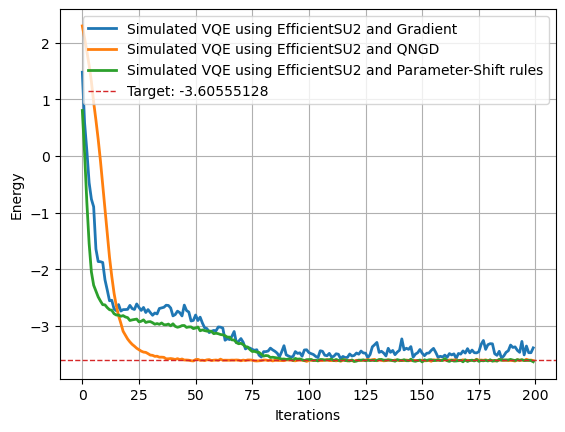

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
# %matplotlib widget


x = np.arange(0, len(data14))


gs_energy = -3.60555128  

plt.plot(data14, lw=2, label='Simulated VQE using EfficientSU2 and Gradient')
plt.plot(data17, lw=2, label='Simulated VQE using EfficientSU2 and QNGD')
plt.plot(data13, lw=2, label='Simulated VQE using EfficientSU2 and Parameter-Shift rules')


plt.ylabel('Energy')
plt.xlabel('Iterations')
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=1, label="Target: " + str(gs_energy))
# Exact ground state energy value
# plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

In [ ]:
PSR = np.array([-5.150000000000002, -7.308000000000001, -9.028000000000002, -11.248000000000001, -12.548000000000002, -14.161999999999999, -15.529999999999998, -16.446, -17.116, -17.914, -18.576, -18.958000000000002, -19.256, -19.592000000000002, -19.748, -19.792, -19.928, -20.224, -20.038, -20.42, -20.484, -20.296, -20.492, -20.517999999999997, -20.372, -20.52, -20.466, -20.632, -20.706, -20.884, -20.712, -20.872, -20.844, -20.778000000000002, -20.762, -20.95, -20.988, -20.971999999999998, -20.786, -20.955999999999996, -21.034, -21.003999999999998, -21.003999999999998, -20.934, -21.020000000000003, -21.048, -21.136, -21.198, -21.292, -21.46, -21.236, -21.172, -21.326, -21.182000000000002, -21.282, -21.388, -21.332, -21.336, -21.355999999999998, -21.322, -21.526, -21.630000000000003, -21.604, -21.708, -21.47, -21.41, -21.592, -21.694000000000003, -21.474, -21.656, -21.706, -21.746, -21.776, -21.954, -21.856, -21.613999999999997, -21.86, -21.808, -21.732000000000003, -21.848, -21.973999999999997, -21.88, -22.022, -21.875999999999998, -22.046, -21.936, -22.194, -21.998, -22.182, -22.004, -22.075999999999997, -22.060000000000002, -22.028, -22.162, -22.14, -21.864, -22.262, -22.104, -22.108, -22.098000000000003, -22.142000000000003, -22.052, -21.986, -22.326, -21.982, -22.262, -22.11, -22.268, -22.164, -22.378, -22.364000000000004, -22.32, -22.21, -22.072, -22.152, -22.25, -22.114, -22.256, -22.22, -22.426, -22.157999999999998, -22.537999999999997, -22.342, -22.266, -22.378, -22.432000000000002, -22.346, -22.484, -22.236, -22.285999999999998, -22.454, -22.436, -22.142, -22.342, -22.062, -22.142, -22.44, -22.5, -22.446, -22.076, -22.488, -22.479999999999997, -22.266000000000002, -22.305999999999997, -22.354, -22.502, -22.416000000000004, -22.302, -21.992, -22.43, -22.264, -22.302000000000003, -22.322, -22.204, -22.312, -22.276000000000003, -22.084, -22.248, -22.242, -22.412, -22.177999999999997, -22.306, -22.414, -22.428, -22.504, -22.490000000000002, -22.018, -22.593999999999998, -22.438000000000002, -22.488, -22.558, -22.33, -22.498, -22.426000000000002, -22.354, -22.274, -22.314, -22.438, -22.204, -22.132, -22.246, -22.436, -22.328, -22.496000000000002, -22.192, -22.434, -22.342, -22.442, -22.234, -22.496, -22.201999999999998, -22.262, -22.326, -22.366, -22.427999999999997, -22.458, -22.267999999999997, -22.266, -22.356, -22.33, -22.308, -22.376, -22.266, -22.346, -22.348, -22.305999999999997, -22.421999999999997, -22.14, -22.278, -22.446, -22.32, -22.422, -22.224, -22.332, -22.270000000000003, -22.105999999999998, -22.244, -22.340000000000003, -22.422, -22.24, -22.418, -22.332, -22.302, -22.36, -22.382, -22.544, -22.308, -22.542, -22.36, -22.532, -22.288000000000004, -22.16, -22.326, -22.413999999999998, -22.648, -22.148, -22.2, -22.282000000000004, -22.442, -22.552, -22.508000000000003, -22.13, -22.366, -22.262, -22.4, -22.426000000000002, -22.416, -22.224, -22.376, -22.116, -22.387999999999998, -22.381999999999998, -22.296, -22.409999999999997, -22.328, -22.344, -22.226, -22.564, -22.48, -22.387999999999998, -22.452, -22.372, -22.451999999999998, -22.362000000000002, -22.446, -22.256, -22.174, -22.42, -22.188000000000002, -22.206000000000003, -22.451999999999998, -22.406, -22.242, -22.368000000000002, -22.476, -22.266, -22.33, -22.226000000000003, -22.434, -22.392, -22.235999999999997, -22.57, -22.328000000000003, -22.348, -22.268, -22.42, -22.452, -22.536, -22.14, -22.378, -22.26, -22.462000000000003, -22.468, -22.29, -22.512, -22.244, -22.568, -22.299999999999997, -22.32, -22.274])

In [ ]:
GD = np.array([-4.49, -8.648, -14.352, -16.212, -16.764000000000003, -17.778000000000002, -17.921999999999997, -18.366, -18.529999999999998, -19.212, -19.736, -19.854000000000003, -19.924, -20.322000000000003, -20.426000000000002, -20.467999999999996, -20.818, -21.022, -20.892, -20.938000000000002, -20.914, -21.182000000000002, -21.304, -21.182000000000002, -21.232, -20.834000000000003, -20.906, -20.892, -21.066, -20.898, -21.458000000000002, -21.396, -21.305999999999997, -21.538, -21.474, -21.36, -21.39, -21.276, -21.02, -21.212, -21.252000000000002, -21.106, -21.080000000000002, -21.272, -21.194, -21.11, -21.505999999999997, -21.11, -21.465999999999998, -21.51, -21.624000000000002, -21.302000000000003, -21.561999999999998, -21.484, -21.634, -21.284, -21.410000000000004, -21.683999999999997, -21.632, -21.536, -21.954, -21.87, -21.64, -21.881999999999998, -21.962, -22.221999999999998, -22.201999999999998, -21.716, -21.844, -21.990000000000002, -21.85, -21.686, -21.704, -22.07, -21.854, -22.014, -21.894, -21.810000000000002, -21.922, -21.986, -22.05, -22.052, -22.009999999999998, -22.008, -22.041999999999998, -22.194, -22.256, -22.184000000000005, -21.869999999999997, -22.136, -22.03, -21.836000000000002, -22.182000000000002, -21.934, -21.994, -21.618, -21.552, -21.366, -21.876, -21.874, -21.708, -22.178, -21.747999999999998, -21.914, -21.852, -21.825999999999997, -22.08, -22.196, -22.165999999999997, -22.163999999999998, -22.058, -22.056, -21.974, -21.96, -21.767999999999997, -21.776, -21.946, -21.992, -22.122, -22.217999999999996, -21.971999999999998, -22.238, -22.05, -22.328, -22.058, -22.232, -22.106, -22.164, -21.926, -22.169999999999998, -22.224, -21.972, -22.346, -22.314, -21.932, -22.144, -22.16, -22.138, -22.204, -22.364, -22.220000000000002, -22.176, -22.358, -22.266, -22.018, -22.119999999999997, -21.926, -22.080000000000002, -22.081999999999997, -22.086, -22.073999999999998, -21.972, -21.862, -21.869999999999997, -21.759999999999998, -21.784000000000002, -21.852, -21.968, -21.900000000000002, -21.664, -22.022, -22.026000000000003, -22.099999999999998, -21.735999999999997, -21.631999999999998, -21.537999999999997, -21.802, -21.694000000000003, -21.734, -21.976, -21.96, -22.17, -22.004, -22.177999999999997, -21.98, -21.968000000000004, -22.242, -22.172, -22.137999999999998, -21.966, -21.814, -22.058, -22.338, -22.108, -22.01, -22.176000000000002, -22.2, -22.184, -22.254, -22.322000000000003, -22.654, -22.404000000000003, -22.32, -22.11, -22.284, -22.364, -22.386, -22.178, -22.349999999999998, -22.2, -22.1, -22.229999999999997, -22.118, -22.15, -21.948, -22.026, -22.096, -21.864, -21.838, -21.924, -22.12, -21.358, -21.406, -21.096, -21.573999999999998, -21.23, -21.756, -22.018, -21.924, -21.778000000000002, -21.63, -22.054, -22.182, -22.163999999999998, -22.418000000000003, -22.164, -22.238, -22.396, -22.348, -22.637999999999998, -22.47, -22.43, -22.414, -22.5, -22.352, -22.198, -22.442, -22.338, -22.441999999999997, -22.396, -22.164, -22.394, -22.402, -22.108, -21.828, -22.084, -21.846000000000004, -22.092000000000002, -22.032000000000004, -22.298, -22.183999999999997, -22.346, -22.278000000000002, -22.503999999999998, -22.368000000000002, -22.356, -22.36, -22.195999999999998, -22.484, -22.424, -22.166, -22.387999999999998, -22.354, -22.404000000000003, -22.29, -22.358, -22.14, -22.483999999999998, -22.561999999999998, -22.616, -22.262, -22.39, -22.183999999999997, -22.3, -22.322, -22.202, -22.244, -22.226, -22.306, -21.868000000000002, -22.202, -22.352, -22.238, -22.342000000000002, -22.324, -22.188000000000002, -22.328000000000003, -22.104, -22.046, -22.15, -21.86, -22.240000000000002, -22.375999999999998, -22.194000000000003, -22.104, -22.470000000000002, -22.35, -22.491999999999997, -22.256, -22.337999999999997])

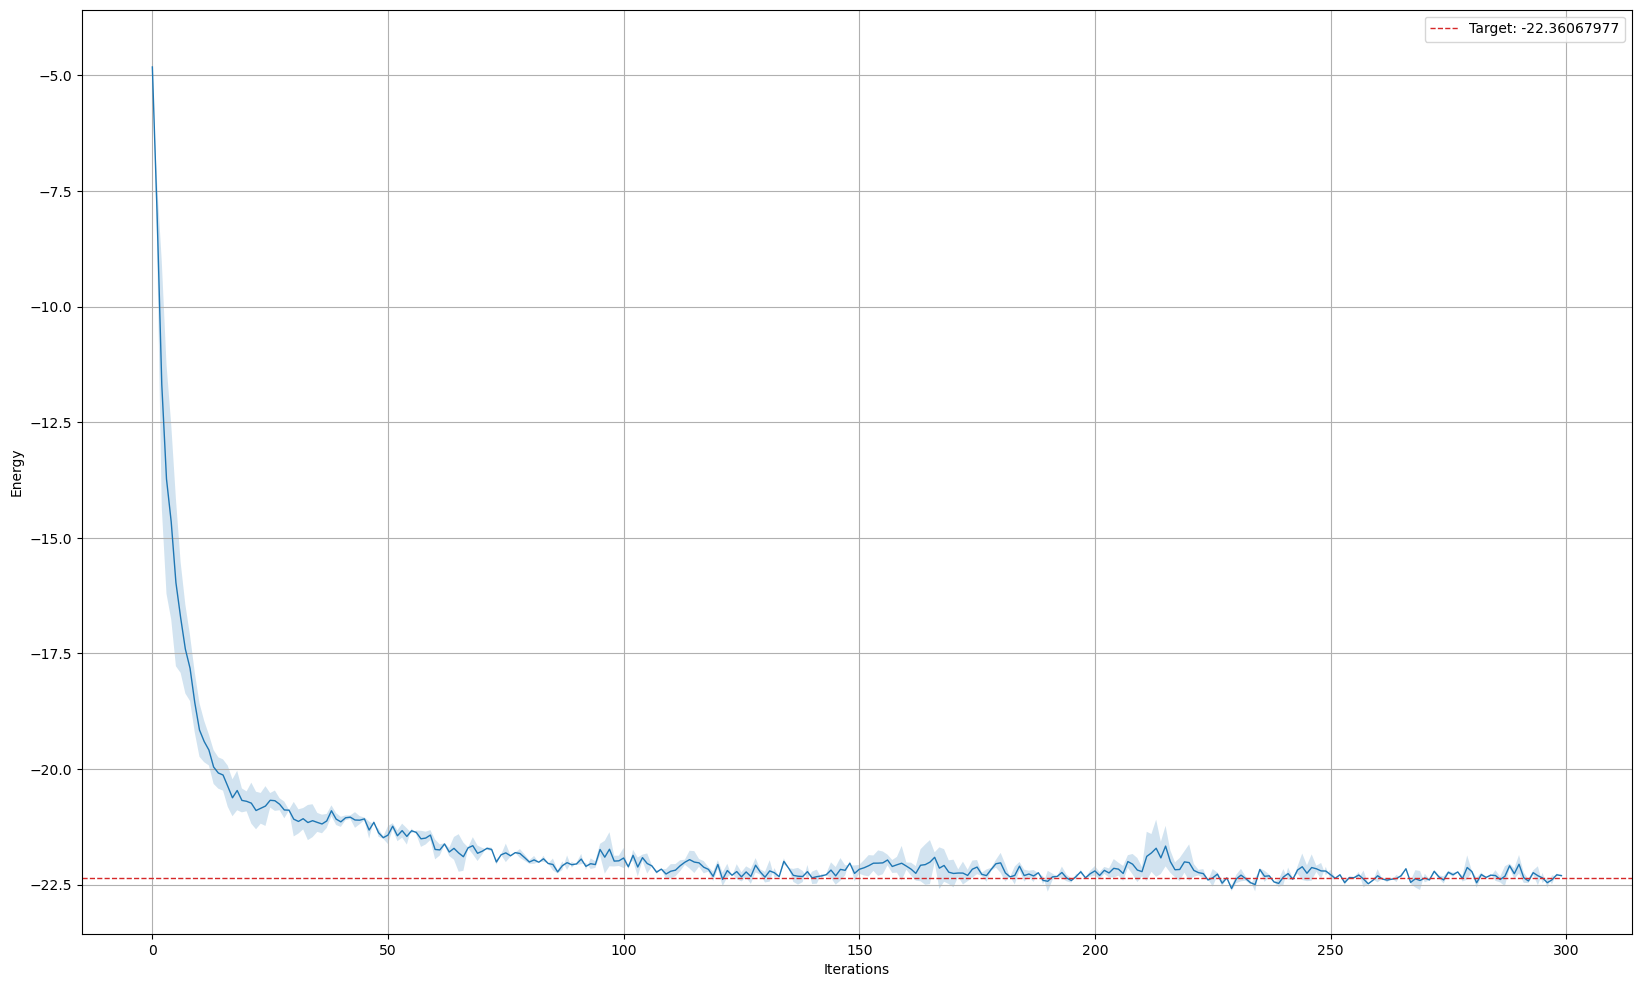

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
# %matplotlib widget

gs_energy = -22.36067977

x = np.arange(0, len(GD))


# plt.plot(PSR, lw=2, label='Simulated VQE with EfficientSU2 and Parameter Shift Rules')
# plt.plot(GD, lw=2, label='Simulated VQE with EfficientSU2 and Gradient Descent')

plt.figure(figsize=(20,12))

plt.plot((PSR+GD)/2, lw=1)

plt.fill_between(x, PSR, GD, alpha=.2)
# plt.plot(data7, lw=2, label='Simulated VQE with EfficientSU2 and GNGD')

plt.ylabel('Energy')
plt.xlabel('Iterations')
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=1, label="Target: " + str(gs_energy))
# Exact ground state energy value
# plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

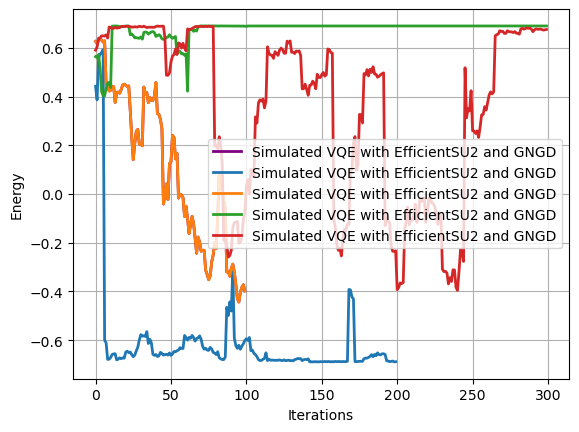

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
# %matplotlib widget

plt.plot(data2, color='purple', lw=2, label='Simulated VQE with EfficientSU2 and GNGD')
plt.plot(data1, lw=2, label='Simulated VQE with EfficientSU2 and GNGD')
plt.plot(data2, lw=2, label='Simulated VQE with EfficientSU2 and GNGD')
plt.plot(data3, lw=2, label='Simulated VQE with EfficientSU2 and GNGD')
plt.plot(data4, lw=2, label='Simulated VQE with EfficientSU2 and GNGD')

plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
# plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

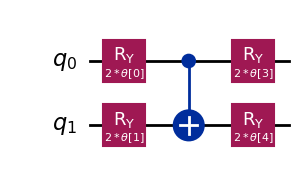

In [ ]:
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit

ansatz = QuantumCircuit(2)

for i in range(2):
    theta1 = Parameter(r'$2*\theta[{}]$'.format(i))
    ansatz.ry(theta1, i)

ansatz.cx(0,1)

for i in range(3,5):
    theta1 = Parameter(r'$2*\theta[{}]$'.format(i))
    ansatz.ry(theta1, i-3)

ansatz.draw('mpl', style='iqx')

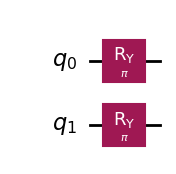

In [ ]:
internal_circuit_cc[0].draw('mpl', style='iqx')

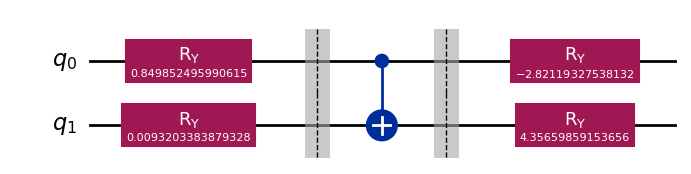

In [ ]:
q = np.pi

parameter = [q, q, q, q]

circuit = Customize_RealAmplidues(2,1)

circuit = circuit.bind_parameters({theta: initial_point[k] for k, theta in enumerate(circuit.parameters)})


circuit_for_measurement = circuit

# initial_point = 
circuit.draw('mpl', style='iqx')




In [ ]:
i = 0
j = 0

# circuit = 

if i != j:
    term1 = ['I']*len(circuit)
    term2 = ['I']*len(circuit)
    term3 = ['I']*len(circuit)
    
    # Change rotation gate to pauli gate
    # Term1
    if circuit[i].operation.name == 'rx':
        term1[i] = 'X'
        term2[i] = 'X'
    if circuit[i].operation.name == 'ry':
        term1[i] = 'Y'
        term2[i] = 'Y'
    if circuit[i].operation.name == 'rz':
        term1[i] = 'Z'
        term2[i] = 'Z'
    
    if circuit[j].operation.name == 'rx':
        term1[j] = 'X'
        term3[j] = 'X'
    if circuit[j].operation.name == 'ry':
        term1[j] = 'Y'
        term3[j] = 'Y'
    if circuit[j].operation.name == 'rz':
        term1[j] = 'Z'
        term3[j] = 'Z'

    
    

    term1 = ''.join(term1)
    term2 = ''.join(term2)
    term3 = ''.join(term3)

    print(term1)
    print(term2)
    print(term3)
    print((Measurement(term1, circuit_for_measurement, shots, backend)[0] - Measurement(term2, circuit_for_measurement, shots, backend)[0]*Measurement(term3, circuit_for_measurement, shots, backend)[0])/4)
else:
    term2 = ['I']*len(circuit)

    if circuit[i].operation.name == 'rx':
        term2[i] = 'X'
    if circuit[i].operation.name == 'ry':
        term2[i] = 'Y'
    if circuit[i].operation.name == 'rz':
        term2[i] = 'Z'

    new_gate = QuantumCircuit(circuit.num_qubits)

    if term2[i] == 'X':
        new_gate.ry(-np.pi/2, i)
    if term2[i] == 'Y':
        new_gate.rx(np.pi/2, i)

    term2 = ''.join(term2)


    

    new_gate = circuit_for_measurement.compose(new_gate)

    new_gate.draw('mpl', style = 'iqx')

    # print(
    #  - Measurement(term2, circuit_for_measurement, shots, backend)[0]**2)/4)

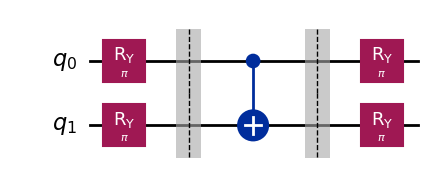

In [ ]:
circuit = Customize_RealAmplidues(2,1)
circuit.draw('mpl', style='iqx')

q = np.pi

initial_point = [q, q, q, q]


circuit = circuit.bind_parameters({theta: initial_point[k] for k, theta in enumerate(circuit.parameters)})

circuit.draw('mpl', style='iqx')

In [ ]:
a = Measurement('II', circuit, shots, backend)

print(a[0]/4)

-0.25


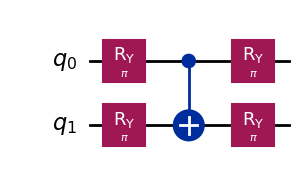

In [ ]:
circuit_a[1].draw('mpl', style = 'iqx')

In [ ]:
# circuit = Customize_RealAmplidues(2,1)

# circuit = circuit.bind_parameters({theta: initial_point[k] for k, theta in enumerate(circuit.parameters)})

# circuit.rx(np.pi/2, 0)


-1.0


In [ ]:
new_gate.draw('mpl', style = 'iqx')

a = (Measurement(term2, new_gate, shots, backend)[0] - Measurement(term2, circuit_for_measurement, shots, backend)[0].real**2)/4

print(a)

-0.25000009


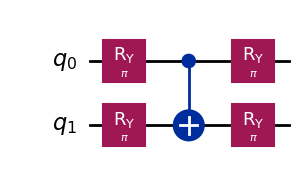

In [ ]:
circuit_a[1].draw('mpl', style = 'iqx')

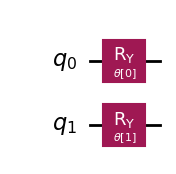

In [ ]:
super_circuit[0].draw('mpl', style = 'iqx')

In [ ]:
from qiskit import Aer

backend = Aer.get_backend('qasm_simulator')

i = 0

g_internal = [[[] for _ in range(super_circuit[i].num_parameters)] for _ in range(super_circuit[i].num_parameters)]

for l in range(super_circuit[i].num_parameters):
    for m in range(super_circuit[i].num_parameters):
        g_internal[l][m] = Measure_element_of_Fubini_Study_metric(super_circuit[i], super_circuit[i], l, m, shots, backend)

# measure = Measure_element_of_Fubini_Study_metric(super_circuit[0], super_circuit[0], 0, 0, 2024, backend)

# print(measure)

Exception: The position of Pauli matrix exceeds the number of qubits

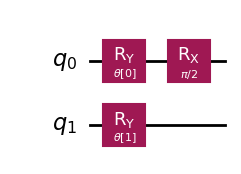

In [ ]:
super_circuit[0].draw('mpl', style = 'iqx')

6


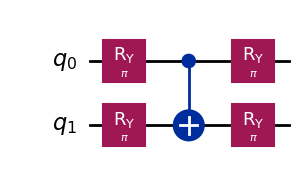

In [ ]:
i = 2
j = 0
# num_parameter = 0

# g_internal = [[[] for _ in range(super_circuit[0].num_parameters)] for _ in range(super_circuit[0].num_parameters)]

# g_internal = [[] for _ in range(super_circuit[0].num_parameters)]


# print(g_internal)
internal_circuit = QuantumCircuit(super_circuit[i].num_qubits)
for j in range(i+1):
    internal_circuit = internal_circuit.compose(super_circuit[j])

internal_circuit = internal_circuit.bind_parameters({theta: initial_point[i] for i, theta in enumerate(internal_circuit.parameters)})
num_parameter += super_circuit[i].num_parameters

print(num_parameter)
internal_circuit.draw('mpl', style = 'iqx')

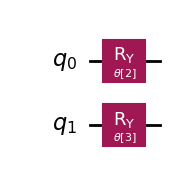

In [ ]:
super_circuit[2].draw('mpl', style = 'iqx')

# Use PennyLane to calculate the Fubini-Study metric

In [ ]:
import pennylane as qml
from pennylane import numpy as np

dev = qml.device("default.qubit", wires=3)


@qml.qnode(dev, interface="autograd")
def circuit(params):
    # # |psi_0>: state preparation
    # qml.RY(np.pi / 4, wires=0)
    # qml.RY(np.pi / 3, wires=1)
    # qml.RY(np.pi / 7, wires=2)

    # # V0(theta0, theta1): Parametrized layer 0
    # qml.RZ(params[0], wires=0)
    # qml.RZ(params[1], wires=1)

    # # W1: non-parametrized gates
    # qml.CNOT(wires=[0, 1])
    # qml.CNOT(wires=[1, 2])

    # # V_1(theta2, theta3): Parametrized layer 1
    # qml.RY(params[2], wires=1)
    # qml.RX(params[3], wires=2)

    # # W2: non-parametrized gates
    # qml.CNOT(wires=[0, 1])
    # qml.CNOT(wires=[1, 2])

    return qml.expval(qml.PauliZ(0))


params =  np.around(np.random.random(qc.num_parameters),5)

a = circuit(params)
print(a)

1.0


In [ ]:
from qiskit import QuantumCircuit
import numpy as np
from qiskit.circuit import Parameter



qc = QuantumCircuit(3)
qc.ry(np.pi/4, 0)
qc.ry(np.pi/3, 1)
qc.ry(np.pi/7, 2)

params = Parameter(r'$\theta[{}]$'.format(0))
qc.rz(params, 0)

params = Parameter(r'$\theta[{}]$'.format(1))
qc.rz(params, 1)

params = Parameter(r'$\theta[{}]$'.format(2))
qc.ry(params, 0)

params = Parameter(r'$\theta[{}]$'.format(3))
qc.rx(params, 1)

qc.cx(0,1)
qc.cx(1,2)

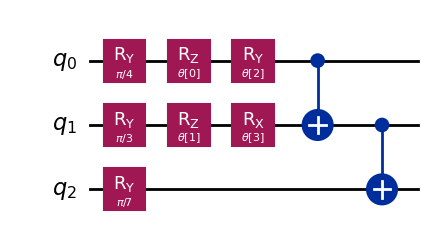

In [ ]:
qc.draw('mpl', style = 'iqx')

In [ ]:
from qiskit import Aer
backend = Aer.get_backend('qasm_simulator')


initial_point = [0.432, -0.123, 0.543, 0.233]

# qc = qc.bind_parameters({theta: initial_point[i] for i, theta in enumerate(qc.parameters)})

qc = QuantumCircuit(3)

# qc.draw('mpl', style = 'iqx')

shots = 2000

q = Measurement('YII', qc, shots, backend)

print(q[0])

-0.001


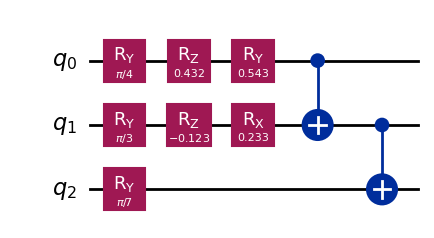

In [ ]:
qc.draw('mpl', style = 'iqx')


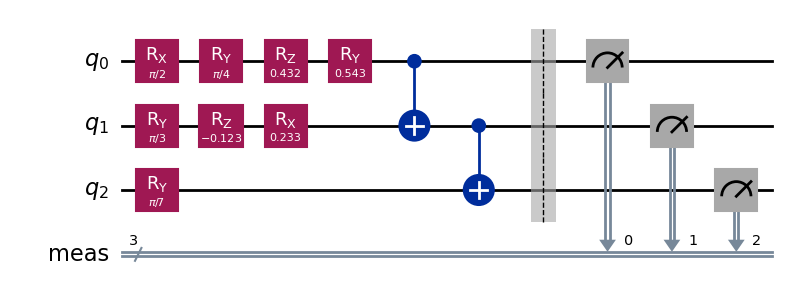

In [ ]:
q[2].draw('mpl', style='iqx')

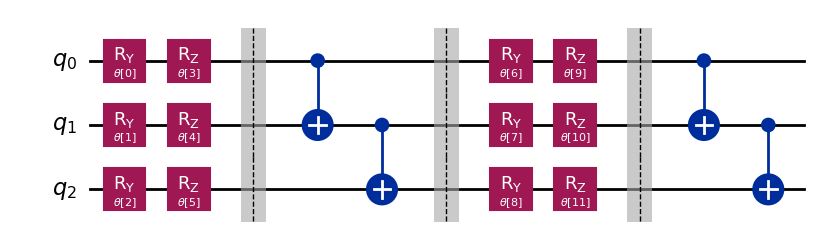

In [ ]:
qc = Customize_EfficientSU2(3,2)
qc.draw('mpl', style = 'iqx')

In [ ]:
import pennylane as qml
from pennylane import numpy as np

dev = qml.device("default.qubit", wires=3)


@qml.qnode(dev, interface="autograd")
def circuit(params):
    # |psi_0>: state preparation
    qml.RY(params[0], wires=0)
    qml.RY(params[1], wires=1)
    qml.RY(params[2], wires=2)
    # V0(theta0, theta1): Parametrized layer 0
    qml.RZ(params[3], wires=0)
    qml.RZ(params[4], wires=1)
    qml.RZ(params[5], wires=1)
    # W1: non-parametrized gates
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    # # |psi_0>: state preparation
    # qml.RY(params[6], wires=0)
    # qml.RY(params[7], wires=1)
    # qml.RY(params[8], wires=2)
    # # V0(theta0, theta1): Parametrized layer 0
    # qml.RZ(params[9], wires=0)
    # qml.RZ(params[10], wires=1)
    # qml.RZ(params[11], wires=1)
    # # W2: non-parametrized gates
    # qml.CNOT(wires=[0, 1])
    # qml.CNOT(wires=[1, 2])

    return qml.expval(qml.PauliZ(0))


params = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]

print(qml.metric_tensor(circuit, approx='diag')(params))

a = (np.round(qml.metric_tensor(    , approx="block-diag")(params), 8))

print(a)

()
[]


d:\Users\DELL\anaconda3\lib\site-packages\pennylane\transforms\metric_tensor.py:397: UserWarning: Attempted to compute the metric tensor of a QNode with no trainable parameters. If this is unintended, please add trainable parameters in accordance with the chosen auto differentiation framework.
  warnings.warn(


In [ ]:
params = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]

qc = Customize_EfficientSU2(3,2)


[0.80809085 0.90136693 0.22754408 0.29345346 0.16095086 0.79647083
 0.87238822 0.72783551 0.87484024 0.14693104 0.34391556]


[ 7 20 66 16 35]


In [ ]:
hamiltonian.coeffs

array([18.75+0.j,  2.75+0.j,  0.5 +0.j,  0.75+0.j,  1.  +0.j,  5.5 +0.j,
        8.25+0.j, 11.  +0.j,  1.5 +0.j,  2.  +0.j,  3.  +0.j])

In [ ]:
hamiltonian[0]

PauliSumOp(SparsePauliOp(['IIIII'],
              coeffs=[18.75+0.j]), coeff=1.0)

In [ ]:
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit.opflow.primitive_ops.pauli_sum_op import PauliSumOp

hamiltonian = PauliSumOp(SparsePauliOp(['IIIII', 'IZIII', 'IZZII', 'IZIZI', 'IZIIZ', 'IIZII', 'IIIZI', 'IIIIZ', 'IIZZI', 'IIZIZ', 'IIIZZ'],
              coeffs=[18.75+0.j,  2.75+0.j,  0.5 +0.j,  0.75+0.j,  1.  +0.j,  5.5 +0.j,
  8.25+0.j, 11.  +0.j,  1.5 +0.j,  2.  +0.j,  3.  +0.j]), coeff=1.0)

In [ ]:
hamiltonian[0].coeffs[0].real

18.75

In [ ]:
len(hamiltonian)

11

In [ ]:
print(hamiltonian.primitive._pauli_list)
print(hamiltonian.coeffs.real)

['IIIII', 'IZIII', 'IZZII', 'IZIZI', 'IZIIZ', 'IIZII', 'IIIZI', 'IIIIZ',
 'IIZZI', 'IIZIZ', 'IIIZZ']
[18.75  2.75  0.5   0.75  1.    5.5   8.25 11.    1.5   2.    3.  ]


In [ ]:
from qiskit.quantum_info import SparsePauliOp

H2_op = SparsePauliOp.from_list(
    [
        ("II", -1.052373245772859),
        ("IZ", 0.39793742484318045),
        ("ZI", -0.39793742484318045),
        ("ZZ", -0.01128010425623538),
        ("XX", 0.18093119978423156),
    ]
)

print(f"Number of qubits: {H2_op.num_qubits}")

Number of qubits: 2


In [ ]:
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit.opflow import PauliSumOp

numpy_solver = NumPyMinimumEigensolver()
result = numpy_solver.compute_minimum_eigenvalue(operator=PauliSumOp(H2_op))
ref_value = result.eigenvalue.real
print(f"Reference value: {ref_value:.5f}")

Reference value: -1.85728


In [ ]:
PauliSumOp(H2_op)._instance_id

776

In [ ]:
def main_process(callback):
    print("Main process started.")
    print("Doing some tasks.")
    result = "Task completed."
    callback(result)  # Call the callback function with the result
    print("Main process finished.")

def my_callback_function(message):
    print(f"Inside the callback: {message}")

# Run the example
main_process(my_callback_function)

Main process started.
Doing some tasks.
Inside the callback: Task completed.
Main process finished.


# Test 

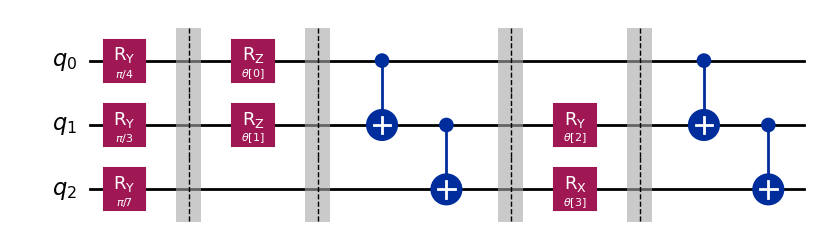

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
import numpy as np

circuit = QuantumCircuit(3)
circuit.ry(np.pi/4, 0)
circuit.ry(np.pi/3, 1)
circuit.ry(np.pi/7, 2)

circuit.barrier()

params = Parameter(r'$\theta[{}]$'.format(0))
circuit.rz(params, 0)
params = Parameter(r'$\theta[{}]$'.format(1))
circuit.rz(params, 1)

circuit.barrier()

circuit.cx(0,1)
circuit.cx(1,2)

circuit.barrier()

params = Parameter(r'$\theta[{}]$'.format(2))
circuit.ry(params, 1)
params = Parameter(r'$\theta[{}]$'.format(3))
circuit.rx(params, 2)

circuit.barrier()

circuit.cx(0,1)
circuit.cx(1,2)


circuit.draw('mpl', style='iqx')

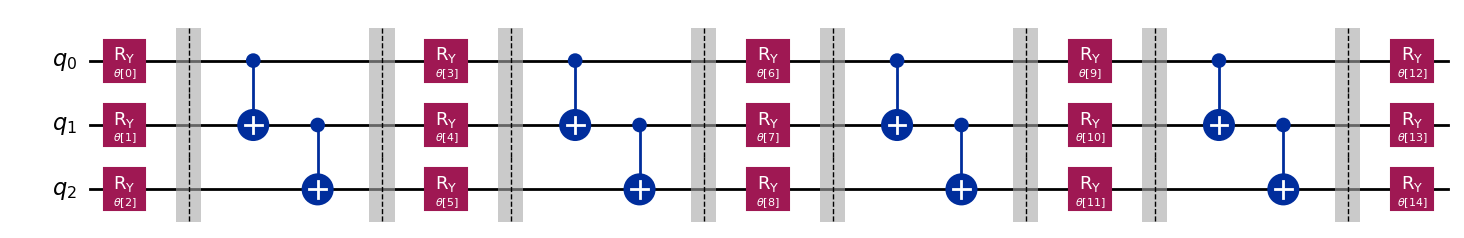

In [ ]:
# print(1-(Measurement('IZI', qc, shots, backend)[0]**2)/4)

ansatz = Customize_RealAmplidues(3, 4)
ansatz.draw('mpl', style='iqx')

In [ ]:
def fubini_stydy_metric(ansatz, parameter, shots, backend):
    def Measure_element_of_Fubini_Study_metric(circuit, circuit_for_measurement, i, j, shots, backend):
        if i != j:
            term1 = ['I']*len(circuit)
            term2 = ['I']*len(circuit)
            term3 = ['I']*len(circuit)
            
            # Change rotation gate to pauli gate
            # Term1
            if circuit[i].operation.name == 'rx':
                term1[i] = 'X'
                term2[i] = 'X'
            if circuit[i].operation.name == 'ry':
                term1[i] = 'Y'
                term2[i] = 'Y'
            if circuit[i].operation.name == 'rz':
                term1[i] = 'Z'
                term2[i] = 'Z'
            
            if circuit[j].operation.name == 'rx':
                term1[j] = 'X'
                term3[j] = 'X'
            if circuit[j].operation.name == 'ry':
                term1[j] = 'Y'
                term3[j] = 'Y'
            if circuit[j].operation.name == 'rz':
                term1[j] = 'Z'
                term3[j] = 'Z'

            # # Term 2
            # if circuit[i].operation.name == 'rx':
            #     term2[i] = 'X'
            # if circuit[i].operation.name == 'ry':
            #     term2[i] = 'Y'
            # if circuit[i].operation.name == 'rz':
            #     term2[i] = 'Z'

            # # Term 3
            # if circuit[j].operation.name == 'rx':
            #     term3[j] = 'X'
            # if circuit[j].operation.name == 'ry':
            #     term3[j] = 'Y'
            # if circuit[j].operation.name == 'rz':
            #     term3[j] = 'Z'
            

            term1 = ''.join(term1)
            term2 = ''.join(term2)
            term3 = ''.join(term3)

            return  (Measurement(term1, circuit_for_measurement, shots, backend)[0] - Measurement(term2, circuit_for_measurement, shots, backend)[0]*Measurement(term3, circuit_for_measurement, shots, backend)[0])/4
        else:
            # term1 = ['I']*len(circuit)
            term2 = ['I']*len(circuit)

            if circuit[i].operation.name == 'rx':
                term2[i] = 'X'
            if circuit[i].operation.name == 'ry':
                term2[i] = 'Y'
            if circuit[i].operation.name == 'rz':
                term2[i] = 'Z'

            term2 = ''.join(term2)

            # new_gate = circuit_for_measurement.compose(new_gate)

            # return (Measurement(term1, circuit_for_measurement, shots, backend)[0] - Measurement(term2, circuit_for_measurement, shots, backend)[0].real**2)/4
            return (1 - Measurement(term2, circuit_for_measurement, shots, backend)[0].real**2)/4
        
        

    # Divide the circuit to subcircuit of parameter circuit and non parameter circuit
    super_circuit = []
    no_name = 0

    ansatz_barrier = 0 

    for i in range(len(ansatz)):
        if ansatz[i].operation.name == 'barrier':
            ansatz_barrier += 1

    while no_name < (ansatz.size() + ansatz_barrier - 1):
        if ansatz[no_name].operation.params:
            sub_circuit = QuantumCircuit(ansatz.num_qubits)
            for i in range(no_name, ansatz.num_qubits + no_name):
                if ansatz[i].operation.name != 'barrier': 
                    sub_circuit.append(ansatz[i])
            super_circuit.append(sub_circuit)
            no_name += ansatz.num_qubits 
            
        elif ansatz[no_name].operation.name == 'barrier':
            no_name += 1
            
        else:
            sub_circuit = QuantumCircuit(ansatz.num_qubits)
            
            while not ansatz[no_name].operation.params:
                if ansatz[no_name].operation.name == 'barrier':
                    no_name += 1
                    break
                sub_circuit.append(ansatz[no_name])
                no_name += 1 

                if no_name == (ansatz.size() + ansatz.count_ops()['barrier'] - 1):
                    break

            super_circuit.append(sub_circuit)
    # Caculate the Fubini_study_metric
    g = []
    initial_point = parameter
    num_parameter = 0


    for i in range(len(super_circuit)):
        if super_circuit[i][0].operation.params:
            g_internal = [[[] for _ in range(super_circuit[i].num_parameters)] for _ in range(super_circuit[i].num_parameters)]
            internal_circuit = QuantumCircuit(super_circuit[i].num_qubits)
            for j in range(i+1):
                internal_circuit = internal_circuit.compose(super_circuit[j])

            internal_circuit = internal_circuit.bind_parameters({theta: initial_point[i] for i, theta in enumerate(internal_circuit.parameters)})
            num_parameter += super_circuit[i].num_parameters

            # print(num_parameter)
            
            for l in range(super_circuit[i].num_parameters):
                for m in range(super_circuit[i].num_parameters):
                    g_internal[l][m] = Measure_element_of_Fubini_Study_metric(super_circuit[i], internal_circuit, l, m, shots, backend)
            # print(np.round(g_internal,2))
            if g != []:
                g = block_diag(g, g_internal)
            else:
                g = block_diag(g_internal)
    
    return g, super_circuit

from qiskit import Aer

backend = Aer.get_backend('qasm_simulator')


parameter = np.array([0.432, -0.123, 0.543, 0.233])

shots = 200000

g, super_circuit = fubini_stydy_metric(ansatz, parameter, shots, backend)

print(np.round(g,5))

[[0.25]]


Exception: The position of Pauli matrix exceeds the number of qubits

In [ ]:
import pennylane as qml

dev = qml.device("default.qubit", wires=2)

@qml.qnode(dev)
def circuit(x):
    qml.RX(x, wires=0)
    qml.Hadamard(wires=1)
    qml.CNOT(wires=[0, 1])
    return qml.expval(qml.PauliY(0))

In [ ]:
print(qml.draw(circuit)(x=0.5))

0: ──RX(0.50)─╭●─┤  <Y>
1: ──H────────╰X─┤     


In [ ]:
circuit(0.5)

tensor(-0.47942554, requires_grad=True)

In [ ]:
from qiskit import QuantumCircuit, Aer, execute
from qiskit import QuantumCircuit

qc = QuantumCircuit(2)

qc.rx(0.5, 0)
qc.h(1)
qc.cx(0,1)

# qc.draw('mpl', style='iqx')


print(qc.to_gate())

Instruction(name='circuit-867024', num_qubits=2, num_clbits=0, params=[])


In [ ]:
print(initial_point)

[0.70117753 0.56426092]


Ground State Energy:  -22.614  θ =  1.933  φ =  0.0


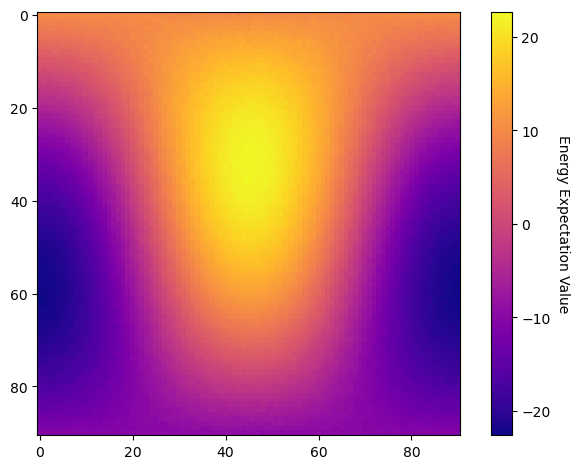

In [ ]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
import math as m
import Our_Qiskit_Functions as oq

import matplotlib.pyplot as plt

t1 = 91
t2 = 91
Shots = 10000
Parameter_Space = np.zeros(shape=(t1,t2))
Ground_State = [100,0,0]
# H = {'X':3,'Y':-2,'Z':1}
H = {'X':20,'Y': 0,'Z':-10}
Hk = list( H.keys() )
#--------------------------------------------------

# @jit(nopython=True, P)
def single_qubit(Parameter_Space, Ground_State):
    for i in np.arange( t1 ):
        theta = m.pi*(i/t1)
        for j in np.arange( t2 ):
            phi = 2*m.pi*(j/t2)
            Measures = []
            for k in np.arange(len(Hk)):
                q = QuantumRegister( 1, name='q' )
                c = ClassicalRegister( 1, name='c' )
                qc= QuantumCircuit( q, c, name='qc')
                oq.Single_Qubit_Ansatz( qc, q[0], [theta, phi] )
                if( Hk[k] == 'X' ):
                    qc.ry( -m.pi/2, q[0])
                if( Hk[k] == 'Y' ):
                    qc.rx(m.pi/2, q[0])
                qc.measure( q,c )
                M = {'0':0,'1':0}
                M.update( oq.Measurement( qc, shots=Shots, print_M=False, return_M=True ) )
                Measures.append( M )
            Parameter_Space[i,j] = H['X']*(Measures[0]['0'] - Measures[0]['1'])/Shots + H['Y']*(Measures[1]['0'] - Measures[1]['1'])/Shots + H['Z']*(Measures[2]['0'] - Measures[2]['1'])/Shots
            if( Parameter_Space[i,j] < Ground_State[0] ):
                Ground_State[0] = Parameter_Space[i,j]
                Ground_State[1] = theta
                Ground_State[2] = phi
    return Parameter_Space, Ground_State
#==================================================

Parameter_Space, Ground_State = single_qubit(Parameter_Space, Ground_State)

print('Ground State Energy: ',round(Ground_State[0],5),' \u03B8 = ',round(Ground_State[1],3),' \u03C6 = ',round(Ground_State[2],3))
fig, ax = plt.subplots()
show_text = False
show_ticks = False
oq.Heatmap(Parameter_Space, show_text, show_ticks, ax, "plasma", "Energy Expectation Value")
fig.tight_layout()
plt.show()

In [204]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
import math as m
import Our_Qiskit_Functions as oq

import matplotlib.pyplot as plt

t1 = 91
t2 = 91
Shots = 10000
Parameter_Space = np.zeros(shape=(t1,t2))
Ground_State = [100,0,0]
# H = {'X':3,'Y':-2,'Z':1}
H = {'X':-20,'Y': 0,'Z':10}
Hk = list( H.keys() )
#--------------------------------------------------

# @jit(nopython=True, P)
def single_qubit(Parameter_Space, Ground_State):
    for i in np.arange( t1 ):
        theta = m.pi*(i/t1)
        for j in np.arange( t2 ):
            phi = 2*m.pi*(j/t2)
            Measures = []
            for k in np.arange(len(Hk)):
                q = QuantumRegister( 1, name='q' )
                c = ClassicalRegister( 1, name='c' )
                qc= QuantumCircuit( q, c, name='qc')
                oq.Single_Qubit_Ansatz( qc, q[0], [theta, phi] )
                if( Hk[k] == 'X' ):
                    qc.ry( -m.pi/2, q[0])
                if( Hk[k] == 'Y' ):
                    qc.rx(m.pi/2, q[0])
                qc.measure( q,c )
                M = {'0':0,'1':0}
                M.update( oq.Measurement( qc, shots=Shots, print_M=False, return_M=True ) )
                Measures.append( M )
            Parameter_Space[i,j] = H['X']*(Measures[0]['0'] - Measures[0]['1'])/Shots + H['Y']*(Measures[1]['0'] - Measures[1]['1'])/Shots + H['Z']*(Measures[2]['0'] - Measures[2]['1'])/Shots
            if( Parameter_Space[i,j] < Ground_State[0] ):
                Ground_State[0] = Parameter_Space[i,j]
                Ground_State[1] = theta
                Ground_State[2] = phi
    return Parameter_Space, Ground_State
#==================================================

Parameter_Space, Ground_State = single_qubit(Parameter_Space, Ground_State)

print('Ground State Energy: ',round(Ground_State[0],5),' \u03B8 = ',round(Ground_State[1],3),' \u03C6 = ',round(Ground_State[2],3))
fig, ax = plt.subplots()
show_text = False
show_ticks = False
oq.Heatmap(Parameter_Space, show_text, show_ticks, ax, "plasma", "Energy Expectation Value")
fig.tight_layout()
plt.show()

KeyboardInterrupt: 

In [311]:
a = Parameter_Space.reshape(100*100)

In [140]:
len(a)

8281

In [141]:
91*91

8281

In [ ]:
Parameter_Space

In [312]:
file = open('data_of_Parameter_space.txt', 'w')
for i in range(100*100):
    file.write(f'{str(a[i])}, \n')

file.close()


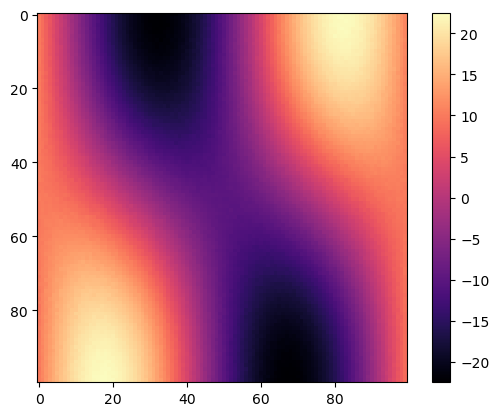

In [303]:
import matplotlib.pyplot as plt
import numpy as np


def heatmap2d(arr: np.ndarray):
    plt.imshow(arr, cmap='magma')
    plt.colorbar()



# test_array = np.arange(100 * 100).reshape(100, 100)
heatmap2d(Parameter_Space)

# x = np.array([0,20,30,40])
# y = np.array([40,50,60,90])

# plt.plot(x, y, 'b+-', markersize  = 5, color = 'white', linewidth = 0.3)
plt.show()

In [ ]:


import numpy as np
from qiskit.algorithms.optimizers import SPSA

optimizer = SPSA(maxiter=1000)

qbackend = Aer.get_backend('qasm_simulator')
# seed = 170

np.random.seed(500)  # seed for reproducibility
initial_point = np.random.random(ansatz.num_parameters)

intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
}

def callback(nfev, parameters, energy, stddev):
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)
    intermediate_info['stddev'].append(stddev)

from qiskit.providers.basicaer import QasmSimulatorPy  # local simulator
from qiskit.algorithms import VQE
from qiskit import Aer, transpile, assemble



local_vqe = VQE(ansatz=ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                # quantum_instance=qi,
                quantum_instance=QasmSimulatorPy(),
                callback=callback)

 
# H = QHO_hamiltionian(num_qubits, omegaQ, alpha)


hamiltonian = PauliSumOp(SparsePauliOp(['ZY', 'XX'],
              coeffs=[10, -20]), coeff=1.0)

local_result = local_vqe.compute_minimum_eigenvalue(hamiltonian)

# print(local_result.real)


┌─────────────────┐┌─────────────────┐ ░       ░ ┌─────────────────┐»
q_0: ┤ Ry($\theta[0]$) ├┤ Rz($\theta[2]$) ├─░───■───░─┤ Ry($\theta[4]$) ├»
     ├─────────────────┤├─────────────────┤ ░ ┌─┴─┐ ░ ├─────────────────┤»
q_1: ┤ Ry($\theta[1]$) ├┤ Rz($\theta[3]$) ├─░─┤ X ├─░─┤ Ry($\theta[5]$) ├»
     └─────────────────┘└─────────────────┘ ░ └───┘ ░ └─────────────────┘»
«     ┌─────────────────┐
«q_0: ┤ Rz($\theta[6]$) ├
«     ├─────────────────┤
«q_1: ┤ Rz($\theta[7]$) ├
«     └─────────────────┘